In [12]:
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import torch.nn.functional as F
import torch.nn.parallel as parallel
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt
from IPython.display import display

In [13]:
# Vision Transformer Components
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        num_patches = (image_size // patch_size) ** 2
        self.positions = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02) #nn.Parameter(torch.randn((image_size // patch_size) ** 2 + 1, embed_dim))
        self.positions.data += torch.randn_like(self.positions) * 0.01
        
    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        qkv = self.qkv(x)
        qkv = rearrange(qkv, 'b n (h d qkv) -> qkv b h n d', 
                       h=self.num_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scaled_dot = torch.matmul(q, k.transpose(-1, -2)) * (self.head_dim ** -0.5)
        attention = F.softmax(scaled_dot, dim=-1)
        attention = self.att_drop(attention)
        
        x = torch.matmul(attention, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.projection(x)
        return x, attention

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, attention = self.attn(x_norm)
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x, attention

In [16]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, 
                 num_classes=1000, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)
        attention_maps = []
        
        for block in self.transformer:
            x, attention = block(x)
            attention_maps.append(attention)
            
        x = self.norm(x)
        cls_token = x[:, 0]
        output = self.head(cls_token)
        
        if return_attention:
            return output, attention_maps
        return output

In [17]:
class HemorrhageDataset(Dataset):
    def __init__(self, root_dir, transform=None, silent=False):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.file_paths = []
        self.labels = []
        self.hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                               'subarachnoid', 'subdural', 'any']
        
        # Initialize patient_folders here
        self.patient_folders = [f for f in self.root_dir.iterdir() if f.is_dir()] if root_dir else []
        
        if root_dir and not silent:  # Only load dataset if root_dir is provided and not silent
            print("Loading dataset...")
            self._load_dataset()
            print(f"Found {len(self.file_paths)} valid samples")

    def _load_dataset(self):
        for patient_folder in self.patient_folders:
            # Find the NIFTI file
            nifti_files = list(patient_folder.glob(f"{patient_folder.name}_*.nii.gz"))
            if not nifti_files:
                continue
            
            # Get the labels file
            labels_file = patient_folder / "hemorrhage_labels.csv"
            if not labels_file.exists():
                continue
                
            # Read labels
            labels_df = pd.read_csv(labels_file)
            
            # Extract labels for all hemorrhage types
            try:
                labels = [int(labels_df[labels_df['hemorrhage_type'] == htype]['label'].values[0])
                         for htype in self.hemorrhage_types]
                
                # Store file path and labels
                self.file_paths.append(nifti_files[0])
                self.labels.append(labels)
            except Exception as e:
                print(f"Error processing {patient_folder}: {e}")
                continue
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load NIFTI file
        nifti_path = self.file_paths[idx]
        nifti_img = nib.load(nifti_path)
        image = nifti_img.get_fdata()
        
        # Take middle slice if 3D
        if len(image.shape) == 3:
            middle_slice = image.shape[2] // 2
            image = image[:, :, middle_slice]
        
        # Normalize the image
        image = self.normalize_image(image)
        
        # Convert to torch tensor
        image = torch.from_numpy(image).float()
        
        # Add channel dimension
        image = image.unsqueeze(0)
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        # Get labels
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return image, labels

    def normalize_image(self, image):
        """Normalize image values to [0, 1] range"""
        min_val = np.min(image)
        max_val = np.max(image)
        if max_val != min_val:
            image = (image - min_val) / (max_val - min_val)
        return image

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def save_activation(module, input, output):
            if isinstance(output, tuple):
                self.activations = output[0]
            else:
                self.activations = output
        
        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_full_backward_hook(save_gradient)
    
    def generate_cam(self, input_image, target_class):
        b, c, h, w = input_image.shape
        
        # Forward pass
        self.model.zero_grad()
        output, attention_maps = self.model(input_image, return_attention=True)
        
        # Target for backprop
        if target_class is None:
            target_class = output.argmax(dim=1)
            
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Generate CAM
        with torch.no_grad():
            # Get gradients and activations
            gradients = self.gradients[0]  # [num_tokens, embed_dim]
            activations = self.activations[0]  # [num_tokens, embed_dim]
            
            # Remove CLS token
            gradients = gradients[1:]  # [num_patches, embed_dim]
            activations = activations[1:]  # [num_patches, embed_dim]
            
            # Calculate importance weights
            weights = gradients.mean(dim=0).unsqueeze(0)  # [1, embed_dim]
            
            # Weighted combination of activation maps
            cam = torch.matmul(activations, weights.transpose(0, 1))  # [num_patches]
            
            # Reshape to square grid
            num_patches = int(np.sqrt(cam.shape[0]))
            cam = cam.reshape(num_patches, num_patches)
            
            # Normalize
            cam = F.relu(cam)
            if torch.max(cam) != 0:  # Avoid division by zero
                cam = (cam - torch.min(cam)) / (torch.max(cam) - torch.min(cam))
            
            # Resize to input resolution
            cam = cam.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            cam = F.interpolate(cam, size=(h, w), mode='bilinear', align_corners=False)
            cam = cam.squeeze()
            
        return cam, attention_maps

In [22]:
class BCEWithLogitsLossSmooth(torch.nn.Module):
    def __init__(self, smooth=0.1):
        super(BCEWithLogitsLossSmooth, self).__init__()
        self.smooth = smooth
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        # Apply label smoothing
        smooth_targets = targets * (1 - self.smooth) + 0.5 * self.smooth
        return self.bce(logits, smooth_targets)


In [30]:
# Modify ViT for multi-label classification
class HemorrhageViT(nn.Module):
    def __init__(self, image_size=224, patch_size=8, in_channels=1, 
                 num_hemorrhage_types=6, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4, dropout=0.3):
        super().__init__()
        self.vit = VisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            num_classes=embed_dim,  # Use embed_dim as intermediate dimension
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        )
        # Add multi-label classification head
        self.multilabel_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_hemorrhage_types),
            nn.Sigmoid()
        )

    def forward(self, x, return_attention=False):
        if return_attention:
            features, attention_maps = self.vit(x, return_attention=True)
            output = self.multilabel_head(features)
            return output, attention_maps
        else:
            features = self.vit(x)
            output = self.multilabel_head(features)
            return output
        
def save_training_metrics(batch_losses, epoch_losses, timestamp=None):
    """Save training metrics to CSV files"""
    if timestamp is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save batch losses
    batch_df = pd.DataFrame({'batch_number': range(len(batch_losses)), 'loss': batch_losses})
    batch_df.to_csv(f'batch_losses_ben_{timestamp}.csv', index=False)
    
    # Save epoch losses
    epoch_df = pd.DataFrame({'epoch_number': range(len(epoch_losses)), 'loss': epoch_losses})
    epoch_df.to_csv(f'epoch_losses_ben_{timestamp}.csv', index=False)
    
    return timestamp


def plot_training_metrics(csv_path, metric_type='batch', save_path=None, display=True):
    """Generate publication-quality training metric plots"""
    print(f"Reading metrics from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Found {len(df)} {metric_type} records")
    
    plt.figure(figsize=(12, 6))
    
    # Create the plot
    plt.plot(df[f'{metric_type}_number'], df['loss'], 
            color='#2671b8', linewidth=2, 
            marker='o' if metric_type == 'epoch' else None)
    
    # Customize the plot
    plt.title(f'{metric_type.capitalize()} Loss During Training', 
             fontsize=14, pad=20)
    plt.xlabel(f'{metric_type.capitalize()} Number', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    if save_path is None:
        save_path = f'{metric_type}_losses_plot_publication.pdf'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")
    
    # Display in notebook if requested
    if display:
        plt.show()
    else:
        plt.close()

        
def train_hemorrhage_model(root_dir, num_epochs=10, batch_size=8):
    # Set up GPU devices and metrics tracking
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    batch_losses = []
    epoch_losses = []
    
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Using {num_gpus} GPUs!")
        device = torch.device("cuda")
    else:
        print("No GPU available, using CPU")
        device = torch.device("cpu")
    
    # Prepare dataset
    transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.Normalize(mean=[0.485], std=[0.229])
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    dataset = HemorrhageDataset(root_dir=root_dir, transform=transform)
    if len(dataset) == 0:
        raise ValueError("No valid samples found in the dataset!")
        
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size * num_gpus if torch.cuda.is_available() else batch_size, 
        shuffle=True, 
        num_workers=4 * num_gpus if torch.cuda.is_available() else 4
    )
    
    # Initialize model
    model = HemorrhageViT(
        image_size=224,
        patch_size=16,
        in_channels=1,
        num_hemorrhage_types=6
    )
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
#     criterion = nn.BCELoss()
#     criterion = BCEWithLogitsLoss(smooth=0.1)
    criterion = nn.BCEWithLogitsLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, weight_decay=1e-2)
    
    total_batches = len(dataloader)
    print(f"Total batches per epoch: {total_batches}")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("=" * 50)
        
        pbar = tqdm(enumerate(dataloader), total=total_batches, 
                   desc=f"Epoch {epoch+1}/{num_epochs}",
                   bar_format='{l_bar}{bar:30}{r_bar}')
        
        for batch_idx, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item()
            epoch_loss += batch_loss
            batch_losses.append(batch_loss)
            
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | Loss: {batch_loss:.4f}")
            print(f"Batch [{batch_idx+1}/{total_batches}] Loss: {batch_loss:.4f}")
        
        avg_epoch_loss = epoch_loss / total_batches
        epoch_losses.append(avg_epoch_loss)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Average Loss: {avg_epoch_loss:.4f}")
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
            'batch_losses': batch_losses,
            'epoch_losses': epoch_losses
        }
        torch.save(checkpoint, f'hemorrhage_model_epochBen_{epoch+1}.pth')
    
    # Save metrics
    save_training_metrics(batch_losses, epoch_losses, timestamp)
    
    print("\nTraining completed!")
    return model.eval(), timestamp  # Return both model and timestamp


def analyze_hemorrhage_with_gradcam(model, nifti_path):
    """Analyze a CT scan for hemorrhages and visualize with Grad-CAM"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and preprocess the image
    nifti_img = nib.load(nifti_path)
    image = nifti_img.get_fdata()
    
    # Take middle slice if 3D
    if len(image.shape) == 3:
        middle_slice = image.shape[2] // 2
        image = image[:, :, middle_slice]
    
    # Create temporary dataset instance for normalization
    temp_dataset = HemorrhageDataset(root_dir="", silent=True)
    image = temp_dataset.normalize_image(image)
    
    # Prepare image tensor
    image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    image = F.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
    image = image.to(device)
    
    # Initialize Grad-CAM
    target_layer = model.module.vit.transformer[-1] if hasattr(model, 'module') else model.vit.transformer[-1]
    grad_cam = GradCAM(model, target_layer)
    
    # Get predictions and CAM for each hemorrhage type
    hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                       'subarachnoid', 'subdural', 'any']
    results = []
    
    with torch.no_grad():
        predictions = model(image)
        
    # Print predictions
    print("\nPredicted Hemorrhage Types:")
    print("-" * 40)
    detected_types = []
    
    for idx, h_type in enumerate(hemorrhage_types):
        prob = predictions[0, idx].item()
        if prob > 0.5:
            detected_types.append(h_type)
            print(f"{h_type}: {prob:.3f}")
        
        cam, attention_maps = grad_cam.generate_cam(image, target_class=idx)
        results.append({
            'type': h_type,
            'probability': prob,
            'cam': cam,
            'attention_maps': attention_maps
        })
    
    if not detected_types:
        print("No hemorrhages detected")
    
    return results, image


def visualize_gradcam_results(image, results, save_dir='gradcam_results', display=True):
    """
    Visualize and save Grad-CAM results for each detected hemorrhage type
    """
    # Move tensors to CPU before visualization
    image = image.cpu().detach() if isinstance(image, torch.Tensor) else image
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Convert image to numpy for visualization
    orig_image = image.squeeze().numpy()
    
    if not results:
        print("No hemorrhages detected above threshold. Displaying all predictions anyway.")
    
    for result in results:
        h_type = result['type']
        prob = result['probability']
        cam = result['cam'].squeeze().cpu().detach().numpy()
        
        # Create figure with subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # Original image
        ax1.imshow(orig_image, cmap='gray')
        ax1.set_title('Original CT Scan')
        ax1.axis('off')
        
        # Grad-CAM heatmap
        ax2.imshow(orig_image, cmap='gray')
        heatmap = ax2.imshow(cam, cmap='jet', alpha=0.5)
        ax2.set_title(f'{h_type} Hemorrhage\nProbability: {prob:.3f}')
        ax2.axis('off')
        plt.colorbar(heatmap, ax=ax2)
        
        # Attention map
        if result['attention_maps']:
            att_map = result['attention_maps'][-1][0, 0].mean(0).cpu().detach().numpy()
            att_size = int(np.sqrt(att_map.shape[0] - 1))
            att_map = att_map[1:].reshape(att_size, att_size)
            ax3.imshow(att_map, cmap='viridis')
            ax3.set_title('Attention Map')
            ax3.axis('off')
            plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax3)
        
        plt.suptitle(f'Grad-CAM Visualization for {h_type} Hemorrhage', y=1.05)
        plt.tight_layout()
        
        # Save figure
        save_path = os.path.join(save_dir, f'gradcam_{h_type.lower()}.pdf')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        # Display in notebook if requested
        if display:
            plt.show()
        else:
            plt.close()
        
        print(f"Saved Grad-CAM visualization for {h_type} to {save_path}")

In [33]:
if __name__ == "__main__":
    ROOT_DIR = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned"
    
    print("Starting model training...")
    model, training_timestamp = train_hemorrhage_model(
        root_dir=ROOT_DIR,
        num_epochs=10,
        batch_size=8
    )
    
    # Save the trained model
    torch.save(model.state_dict(), 'hemorrhage_model_ben.pth')
    print("Model saved to hemorrhage_model_ben.pth")
    
    # Plot the training metrics
    print("\nPlotting training metrics...")
    plot_training_metrics(f'batch_losses_ben_{training_timestamp}.csv', metric_type='batch', display=True)
    plot_training_metrics(f'epoch_losses_ben_{training_timestamp}.csv', metric_type='epoch', display=True)
    
    # Test and visualize a specific case
    print("\nAnalyzing a specific case...")
    test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_0000298a7d/ID_0000298a7d.nii.gz"
    
    results, image = analyze_hemorrhage_with_gradcam(model, test_file)
    
    # Visualize all results
    visualize_gradcam_results(image, results, display=True)

Starting model training...
Using 1 GPUs!
Loading dataset...
Found 1831 valid samples
Total batches per epoch: 229

Epoch 1/10


Epoch 1/10 | Loss: 0.8643:   1%|▍                             | 3/229 [00:01<01:35,  2.37it/s]

Batch [1/229] Loss: 0.9078
Batch [2/229] Loss: 0.8756
Batch [3/229] Loss: 0.8961
Batch [4/229] Loss: 0.8643


Epoch 1/10 | Loss: 0.8321:   3%|█                             | 8/229 [00:02<01:00,  3.67it/s]

Batch [5/229] Loss: 0.8448
Batch [6/229] Loss: 0.8118
Batch [7/229] Loss: 0.8141
Batch [8/229] Loss: 0.8321


Epoch 1/10 | Loss: 0.7906:   4%|█▎                            | 10/229 [00:04<01:29,  2.45it/s]

Batch [9/229] Loss: 0.8063
Batch [10/229] Loss: 0.8284
Batch [11/229] Loss: 0.7906


Epoch 1/10 | Loss: 0.7693:   5%|█▌                            | 12/229 [00:04<01:07,  3.21it/s]

Batch [12/229] Loss: 0.7693


Epoch 1/10 | Loss: 0.8108:   6%|█▋                            | 13/229 [00:05<01:38,  2.20it/s]

Batch [13/229] Loss: 0.7831
Batch [14/229] Loss: 0.7866
Batch [15/229] Loss: 0.8108


Epoch 1/10 | Loss: 0.7604:   7%|██                            | 16/229 [00:05<01:04,  3.31it/s]

Batch [16/229] Loss: 0.7604


Epoch 1/10 | Loss: 0.7668:   7%|██▏                           | 17/229 [00:07<01:40,  2.11it/s]

Batch [17/229] Loss: 0.8116
Batch [18/229] Loss: 0.7753
Batch [19/229] Loss: 0.7668


Epoch 1/10 | Loss: 0.7478:   9%|██▌                           | 20/229 [00:07<01:04,  3.23it/s]

Batch [20/229] Loss: 0.7478


Epoch 1/10 | Loss: 0.7878:   9%|██▊                           | 21/229 [00:08<01:33,  2.23it/s]

Batch [21/229] Loss: 0.7599
Batch [22/229] Loss: 0.7688
Batch [23/229] Loss: 0.7878


Epoch 1/10 | Loss: 0.7649:  10%|███▏                          | 24/229 [00:08<00:59,  3.42it/s]

Batch [24/229] Loss: 0.7649


Epoch 1/10 | Loss: 0.7477:  12%|███▋                          | 28/229 [00:10<00:54,  3.69it/s]

Batch [25/229] Loss: 0.7422
Batch [26/229] Loss: 0.7447
Batch [27/229] Loss: 0.7425
Batch [28/229] Loss: 0.7477


Epoch 1/10 | Loss: 0.7520:  14%|████▏                         | 32/229 [00:11<00:54,  3.63it/s]

Batch [29/229] Loss: 0.7563
Batch [30/229] Loss: 0.7446
Batch [31/229] Loss: 0.7623
Batch [32/229] Loss: 0.7520


Epoch 1/10 | Loss: 0.7409:  15%|████▍                         | 34/229 [00:12<01:13,  2.65it/s]

Batch [33/229] Loss: 0.7767
Batch [34/229] Loss: 0.7271
Batch [35/229] Loss: 0.7409


Epoch 1/10 | Loss: 0.7346:  16%|████▋                         | 36/229 [00:13<00:59,  3.25it/s]

Batch [36/229] Loss: 0.7346


Epoch 1/10 | Loss: 0.7617:  17%|█████                         | 39/229 [00:14<01:03,  3.01it/s]

Batch [37/229] Loss: 0.7574
Batch [38/229] Loss: 0.7432
Batch [39/229] Loss: 0.7439
Batch [40/229] Loss: 0.7617


Epoch 1/10 | Loss: 0.7301:  19%|█████▊                        | 44/229 [00:15<00:50,  3.63it/s]

Batch [41/229] Loss: 0.7204
Batch [42/229] Loss: 0.7360
Batch [43/229] Loss: 0.7439
Batch [44/229] Loss: 0.7301


Epoch 1/10 | Loss: 0.7195:  20%|██████                        | 46/229 [00:17<01:12,  2.52it/s]

Batch [45/229] Loss: 0.7434
Batch [46/229] Loss: 0.7302
Batch [47/229] Loss: 0.7293
Batch [48/229] Loss: 0.7195


Epoch 1/10 | Loss: 0.7262:  23%|██████▊                       | 52/229 [00:18<00:50,  3.53it/s]

Batch [49/229] Loss: 0.7125
Batch [50/229] Loss: 0.7314
Batch [51/229] Loss: 0.7346
Batch [52/229] Loss: 0.7262


Epoch 1/10 | Loss: 0.7194:  24%|███████                       | 54/229 [00:20<01:07,  2.61it/s]

Batch [53/229] Loss: 0.7327
Batch [54/229] Loss: 0.7169
Batch [55/229] Loss: 0.7134
Batch [56/229] Loss: 0.7194


Epoch 1/10 | Loss: 0.7258:  26%|███████▊                      | 60/229 [00:21<00:47,  3.53it/s]

Batch [57/229] Loss: 0.7185
Batch [58/229] Loss: 0.7100
Batch [59/229] Loss: 0.7122
Batch [60/229] Loss: 0.7258


Epoch 1/10 | Loss: 0.7136:  27%|████████                      | 62/229 [00:22<01:02,  2.66it/s]

Batch [61/229] Loss: 0.7077
Batch [62/229] Loss: 0.7114
Batch [63/229] Loss: 0.7265
Batch [64/229] Loss: 0.7136


Epoch 1/10 | Loss: 0.7163:  30%|████████▉                     | 68/229 [00:24<00:46,  3.49it/s]

Batch [65/229] Loss: 0.7107
Batch [66/229] Loss: 0.7256
Batch [67/229] Loss: 0.7134
Batch [68/229] Loss: 0.7163


Epoch 1/10 | Loss: 0.7234:  31%|█████████▏                    | 70/229 [00:25<01:02,  2.56it/s]

Batch [69/229] Loss: 0.7107
Batch [70/229] Loss: 0.7233
Batch [71/229] Loss: 0.7079
Batch [72/229] Loss: 0.7234


Epoch 1/10 | Loss: 0.7129:  33%|█████████▉                    | 76/229 [00:27<00:44,  3.41it/s]

Batch [73/229] Loss: 0.7151
Batch [74/229] Loss: 0.7023
Batch [75/229] Loss: 0.7107
Batch [76/229] Loss: 0.7129


Epoch 1/10 | Loss: 0.7019:  34%|██████████▏                   | 78/229 [00:28<00:57,  2.61it/s]

Batch [77/229] Loss: 0.7255
Batch [78/229] Loss: 0.7175
Batch [79/229] Loss: 0.7142
Batch [80/229] Loss: 0.7019


Epoch 1/10 | Loss: 0.7149:  37%|███████████                   | 84/229 [00:30<00:43,  3.33it/s]

Batch [81/229] Loss: 0.7172
Batch [82/229] Loss: 0.6918
Batch [83/229] Loss: 0.7138
Batch [84/229] Loss: 0.7149


Epoch 1/10 | Loss: 0.7047:  38%|███████████▎                  | 86/229 [00:31<00:53,  2.69it/s]

Batch [85/229] Loss: 0.6954
Batch [86/229] Loss: 0.7093
Batch [87/229] Loss: 0.7080
Batch [88/229] Loss: 0.7047


Epoch 1/10 | Loss: 0.7020:  40%|████████████                  | 92/229 [00:33<00:41,  3.30it/s]

Batch [89/229] Loss: 0.7065
Batch [90/229] Loss: 0.7011
Batch [91/229] Loss: 0.6991
Batch [92/229] Loss: 0.7020


Epoch 1/10 | Loss: 0.6925:  41%|████████████▎                 | 94/229 [00:34<00:52,  2.57it/s]

Batch [93/229] Loss: 0.6927
Batch [94/229] Loss: 0.7274
Batch [95/229] Loss: 0.6989
Batch [96/229] Loss: 0.6925


Epoch 1/10 | Loss: 0.6989:  44%|█████████████                 | 100/229 [00:36<00:37,  3.47it/s]

Batch [97/229] Loss: 0.7021
Batch [98/229] Loss: 0.7070
Batch [99/229] Loss: 0.6837
Batch [100/229] Loss: 0.6989


Epoch 1/10 | Loss: 0.7130:  45%|█████████████▎                | 102/229 [00:37<00:47,  2.65it/s]

Batch [101/229] Loss: 0.7079
Batch [102/229] Loss: 0.7103
Batch [103/229] Loss: 0.7003
Batch [104/229] Loss: 0.7130


Epoch 1/10 | Loss: 0.7094:  47%|██████████████▏               | 108/229 [00:38<00:34,  3.50it/s]

Batch [105/229] Loss: 0.7086
Batch [106/229] Loss: 0.6890
Batch [107/229] Loss: 0.6987
Batch [108/229] Loss: 0.7094


Epoch 1/10 | Loss: 0.7045:  48%|██████████████▍               | 110/229 [00:40<00:43,  2.72it/s]

Batch [109/229] Loss: 0.6873
Batch [110/229] Loss: 0.7121
Batch [111/229] Loss: 0.7021
Batch [112/229] Loss: 0.7045


Epoch 1/10 | Loss: 0.7059:  51%|███████████████▏              | 116/229 [00:41<00:32,  3.53it/s]

Batch [113/229] Loss: 0.7126
Batch [114/229] Loss: 0.7117
Batch [115/229] Loss: 0.6968
Batch [116/229] Loss: 0.7059


Epoch 1/10 | Loss: 0.6927:  52%|███████████████▍              | 118/229 [00:43<00:42,  2.60it/s]

Batch [117/229] Loss: 0.7095
Batch [118/229] Loss: 0.7081
Batch [119/229] Loss: 0.7043
Batch [120/229] Loss: 0.6927


Epoch 1/10 | Loss: 0.7074:  54%|████████████████▏             | 124/229 [00:44<00:27,  3.75it/s]

Batch [121/229] Loss: 0.6827
Batch [122/229] Loss: 0.7115
Batch [123/229] Loss: 0.7032
Batch [124/229] Loss: 0.7074


Epoch 1/10 | Loss: 0.6935:  55%|████████████████▌             | 126/229 [00:45<00:37,  2.75it/s]

Batch [125/229] Loss: 0.7063
Batch [126/229] Loss: 0.6961
Batch [127/229] Loss: 0.7016
Batch [128/229] Loss: 0.6935


Epoch 1/10 | Loss: 0.6959:  58%|█████████████████▎            | 132/229 [00:47<00:28,  3.41it/s]

Batch [129/229] Loss: 0.7023
Batch [130/229] Loss: 0.6991
Batch [131/229] Loss: 0.6775
Batch [132/229] Loss: 0.6959


Epoch 1/10 | Loss: 0.7065:  59%|█████████████████▌            | 134/229 [00:48<00:35,  2.64it/s]

Batch [133/229] Loss: 0.6986
Batch [134/229] Loss: 0.7009
Batch [135/229] Loss: 0.6963
Batch [136/229] Loss: 0.7065


Epoch 1/10 | Loss: 0.6867:  61%|██████████████████▎           | 140/229 [00:50<00:26,  3.40it/s]

Batch [137/229] Loss: 0.7072
Batch [138/229] Loss: 0.7029
Batch [139/229] Loss: 0.6948
Batch [140/229] Loss: 0.6867


Epoch 1/10 | Loss: 0.6998:  62%|██████████████████▌           | 142/229 [00:51<00:30,  2.83it/s]

Batch [141/229] Loss: 0.6854
Batch [142/229] Loss: 0.6859
Batch [143/229] Loss: 0.7206
Batch [144/229] Loss: 0.6998


Epoch 1/10 | Loss: 0.6835:  65%|███████████████████▍          | 148/229 [00:52<00:22,  3.62it/s]

Batch [145/229] Loss: 0.6949
Batch [146/229] Loss: 0.6976
Batch [147/229] Loss: 0.6949
Batch [148/229] Loss: 0.6835


Epoch 1/10 | Loss: 0.6973:  66%|███████████████████▋          | 150/229 [00:54<00:30,  2.62it/s]

Batch [149/229] Loss: 0.6939
Batch [150/229] Loss: 0.6863
Batch [151/229] Loss: 0.6974
Batch [152/229] Loss: 0.6973


Epoch 1/10 | Loss: 0.7016:  68%|████████████████████▍         | 156/229 [00:55<00:20,  3.60it/s]

Batch [153/229] Loss: 0.7013
Batch [154/229] Loss: 0.6844
Batch [155/229] Loss: 0.6922
Batch [156/229] Loss: 0.7016


Epoch 1/10 | Loss: 0.6815:  69%|████████████████████▋         | 158/229 [00:56<00:25,  2.82it/s]

Batch [157/229] Loss: 0.6932
Batch [158/229] Loss: 0.6831
Batch [159/229] Loss: 0.6777
Batch [160/229] Loss: 0.6815


Epoch 1/10 | Loss: 0.6888:  72%|█████████████████████▍        | 164/229 [00:58<00:18,  3.60it/s]

Batch [161/229] Loss: 0.7098
Batch [162/229] Loss: 0.6844
Batch [163/229] Loss: 0.6894
Batch [164/229] Loss: 0.6888


Epoch 1/10 | Loss: 0.6984:  72%|█████████████████████▋        | 166/229 [00:59<00:22,  2.83it/s]

Batch [165/229] Loss: 0.7007
Batch [166/229] Loss: 0.6934
Batch [167/229] Loss: 0.6881
Batch [168/229] Loss: 0.6984


Epoch 1/10 | Loss: 0.7022:  75%|██████████████████████▌       | 172/229 [01:00<00:16,  3.48it/s]

Batch [169/229] Loss: 0.7116
Batch [170/229] Loss: 0.6964
Batch [171/229] Loss: 0.6923
Batch [172/229] Loss: 0.7022


Epoch 1/10 | Loss: 0.6981:  76%|██████████████████████▊       | 174/229 [01:02<00:21,  2.61it/s]

Batch [173/229] Loss: 0.6936
Batch [174/229] Loss: 0.6879
Batch [175/229] Loss: 0.6913
Batch [176/229] Loss: 0.6981


Epoch 1/10 | Loss: 0.6870:  79%|███████████████████████▌      | 180/229 [01:03<00:14,  3.48it/s]

Batch [177/229] Loss: 0.6961
Batch [178/229] Loss: 0.6868
Batch [179/229] Loss: 0.6947
Batch [180/229] Loss: 0.6870


Epoch 1/10 | Loss: 0.6979:  79%|███████████████████████▊      | 182/229 [01:05<00:16,  2.84it/s]

Batch [181/229] Loss: 0.7044
Batch [182/229] Loss: 0.6870
Batch [183/229] Loss: 0.6980
Batch [184/229] Loss: 0.6979


Epoch 1/10 | Loss: 0.6990:  82%|████████████████████████▋     | 188/229 [01:06<00:11,  3.57it/s]

Batch [185/229] Loss: 0.7025
Batch [186/229] Loss: 0.6915
Batch [187/229] Loss: 0.6892
Batch [188/229] Loss: 0.6990


Epoch 1/10 | Loss: 0.6871:  83%|████████████████████████▉     | 190/229 [01:07<00:14,  2.73it/s]

Batch [189/229] Loss: 0.6995
Batch [190/229] Loss: 0.7012
Batch [191/229] Loss: 0.7072
Batch [192/229] Loss: 0.6871


Epoch 1/10 | Loss: 0.6918:  86%|█████████████████████████▋    | 196/229 [01:09<00:09,  3.62it/s]

Batch [193/229] Loss: 0.6989
Batch [194/229] Loss: 0.6974
Batch [195/229] Loss: 0.6847
Batch [196/229] Loss: 0.6918


Epoch 1/10 | Loss: 0.6828:  86%|█████████████████████████▉    | 198/229 [01:10<00:10,  2.84it/s]

Batch [197/229] Loss: 0.6893
Batch [198/229] Loss: 0.6819
Batch [199/229] Loss: 0.6981
Batch [200/229] Loss: 0.6828


Epoch 1/10 | Loss: 0.6778:  89%|██████████████████████████▋   | 204/229 [01:11<00:06,  3.66it/s]

Batch [201/229] Loss: 0.6856
Batch [202/229] Loss: 0.6945
Batch [203/229] Loss: 0.6962
Batch [204/229] Loss: 0.6778


Epoch 1/10 | Loss: 0.6769:  90%|██████████████████████████▉   | 206/229 [01:12<00:07,  3.05it/s]

Batch [205/229] Loss: 0.6772
Batch [206/229] Loss: 0.6861
Batch [207/229] Loss: 0.6843
Batch [208/229] Loss: 0.6769


Epoch 1/10 | Loss: 0.6946:  93%|███████████████████████████▊  | 212/229 [01:14<00:04,  3.74it/s]

Batch [209/229] Loss: 0.7019
Batch [210/229] Loss: 0.6929
Batch [211/229] Loss: 0.7252
Batch [212/229] Loss: 0.6946


Epoch 1/10 | Loss: 0.6901:  93%|████████████████████████████  | 214/229 [01:16<00:05,  2.61it/s]

Batch [213/229] Loss: 0.6837
Batch [214/229] Loss: 0.7036
Batch [215/229] Loss: 0.6904
Batch [216/229] Loss: 0.6901


Epoch 1/10 | Loss: 0.7002:  96%|████████████████████████████▊ | 220/229 [01:17<00:02,  3.28it/s]

Batch [217/229] Loss: 0.6796
Batch [218/229] Loss: 0.6834
Batch [219/229] Loss: 0.6893
Batch [220/229] Loss: 0.7002


Epoch 1/10 | Loss: 0.6936:  97%|█████████████████████████████ | 222/229 [01:19<00:02,  2.44it/s]

Batch [221/229] Loss: 0.7123
Batch [222/229] Loss: 0.7291
Batch [223/229] Loss: 0.6732
Batch [224/229] Loss: 0.6936


Epoch 1/10 | Loss: 0.7076: 100%|█████████████████████████████▊| 228/229 [01:20<00:00,  3.34it/s]

Batch [225/229] Loss: 0.6763
Batch [226/229] Loss: 0.7001
Batch [227/229] Loss: 0.6806
Batch [228/229] Loss: 0.7076


Epoch 1/10 | Loss: 0.6947: 100%|██████████████████████████████| 229/229 [01:21<00:00,  2.81it/s]


Batch [229/229] Loss: 0.6947

Epoch 1 Summary:
Average Loss: 0.7161

Epoch 2/10


Epoch 2/10 | Loss: 0.7006:   1%|▍                             | 3/229 [00:01<01:25,  2.65it/s]

Batch [1/229] Loss: 0.7002
Batch [2/229] Loss: 0.6807
Batch [3/229] Loss: 0.7006


Epoch 2/10 | Loss: 0.6950:   1%|▍                             | 3/229 [00:01<01:25,  2.65it/s]

Batch [4/229] Loss: 0.6950


Epoch 2/10 | Loss: 0.6865:   3%|█                             | 8/229 [00:02<00:59,  3.70it/s]

Batch [5/229] Loss: 0.6814
Batch [6/229] Loss: 0.6964
Batch [7/229] Loss: 0.6817
Batch [8/229] Loss: 0.6865


Epoch 2/10 | Loss: 0.6821:   4%|█▎                            | 10/229 [00:04<01:26,  2.52it/s]

Batch [9/229] Loss: 0.6938
Batch [10/229] Loss: 0.6840
Batch [11/229] Loss: 0.6821


Epoch 2/10 | Loss: 0.6861:   4%|█▎                            | 10/229 [00:04<01:26,  2.52it/s]

Batch [12/229] Loss: 0.6861


Epoch 2/10 | Loss: 0.6918:   6%|█▊                            | 14/229 [00:05<01:10,  3.03it/s]

Batch [13/229] Loss: 0.6671
Batch [14/229] Loss: 0.6918


Epoch 2/10 | Loss: 0.6870:   7%|█▉                            | 15/229 [00:05<01:04,  3.34it/s]

Batch [15/229] Loss: 0.6859
Batch [16/229] Loss: 0.6870


Epoch 2/10 | Loss: 0.6922:   7%|██▏                           | 17/229 [00:06<01:14,  2.83it/s]

Batch [17/229] Loss: 0.6922


Epoch 2/10 | Loss: 0.6827:   8%|██▍                           | 19/229 [00:06<00:59,  3.56it/s]

Batch [18/229] Loss: 0.6891
Batch [19/229] Loss: 0.6827


Epoch 2/10 | Loss: 0.6896:   9%|██▌                           | 20/229 [00:06<00:55,  3.73it/s]

Batch [20/229] Loss: 0.6896


Epoch 2/10 | Loss: 0.6820:   9%|██▊                           | 21/229 [00:07<01:17,  2.70it/s]

Batch [21/229] Loss: 0.6820


Epoch 2/10 | Loss: 0.7115:  10%|██▉                           | 22/229 [00:07<01:14,  2.80it/s]

Batch [22/229] Loss: 0.7115


Epoch 2/10 | Loss: 0.6908:  10%|███                           | 23/229 [00:08<01:07,  3.04it/s]

Batch [23/229] Loss: 0.6908


Epoch 2/10 | Loss: 0.6780:  10%|███▏                          | 24/229 [00:08<01:00,  3.39it/s]

Batch [24/229] Loss: 0.6780


Epoch 2/10 | Loss: 0.6952:  11%|███▎                          | 25/229 [00:09<01:20,  2.54it/s]

Batch [25/229] Loss: 0.6952


Epoch 2/10 | Loss: 0.6814:  11%|███▍                          | 26/229 [00:09<01:14,  2.72it/s]

Batch [26/229] Loss: 0.6850
Batch [27/229] Loss: 0.6814


Epoch 2/10 | Loss: 0.7010:  12%|███▋                          | 28/229 [00:09<00:59,  3.36it/s]

Batch [28/229] Loss: 0.7010


Epoch 2/10 | Loss: 0.6720:  13%|███▊                          | 29/229 [00:10<01:12,  2.75it/s]

Batch [29/229] Loss: 0.6720


Epoch 2/10 | Loss: 0.6711:  13%|███▉                          | 30/229 [00:10<01:05,  3.02it/s]

Batch [30/229] Loss: 0.6711


Epoch 2/10 | Loss: 0.6871:  14%|████▏                         | 32/229 [00:10<00:52,  3.72it/s]

Batch [31/229] Loss: 0.6863
Batch [32/229] Loss: 0.6871


Epoch 2/10 | Loss: 0.6865:  14%|████▎                         | 33/229 [00:11<01:19,  2.47it/s]

Batch [33/229] Loss: 0.6865


Epoch 2/10 | Loss: 0.6965:  15%|████▍                         | 34/229 [00:12<01:12,  2.69it/s]

Batch [34/229] Loss: 0.6803


Epoch 2/10 | Loss: 0.7007:  15%|████▌                         | 35/229 [00:12<01:02,  3.10it/s]

Batch [35/229] Loss: 0.6965
Batch [36/229] Loss: 0.7007


Epoch 2/10 | Loss: 0.6662:  16%|████▊                         | 37/229 [00:12<01:08,  2.80it/s]

Batch [37/229] Loss: 0.6662


Epoch 2/10 | Loss: 0.6773:  17%|████▉                         | 38/229 [00:13<01:05,  2.92it/s]

Batch [38/229] Loss: 0.6773


Epoch 2/10 | Loss: 0.6907:  17%|█████                         | 39/229 [00:13<01:12,  2.61it/s]

Batch [39/229] Loss: 0.6843
Batch [40/229] Loss: 0.6907


Epoch 2/10 | Loss: 0.6812:  18%|█████▎                        | 41/229 [00:14<01:03,  2.96it/s]

Batch [41/229] Loss: 0.6812


Epoch 2/10 | Loss: 0.6782:  18%|█████▌                        | 42/229 [00:14<01:00,  3.08it/s]

Batch [42/229] Loss: 0.6782


Epoch 2/10 | Loss: 0.6936:  19%|█████▋                        | 43/229 [00:15<01:18,  2.38it/s]

Batch [43/229] Loss: 0.6995
Batch [44/229] Loss: 0.6936


Epoch 2/10 | Loss: 0.6757:  20%|██████                        | 46/229 [00:15<00:55,  3.30it/s]

Batch [45/229] Loss: 0.6874
Batch [46/229] Loss: 0.6757


Epoch 2/10 | Loss: 0.6882:  21%|██████▏                       | 47/229 [00:16<01:14,  2.44it/s]

Batch [47/229] Loss: 0.6805
Batch [48/229] Loss: 0.6882


Epoch 2/10 | Loss: 0.6927:  22%|██████▌                       | 50/229 [00:17<00:58,  3.07it/s]

Batch [49/229] Loss: 0.6962
Batch [50/229] Loss: 0.6927


Epoch 2/10 | Loss: 0.6937:  22%|██████▋                       | 51/229 [00:17<01:01,  2.89it/s]

Batch [51/229] Loss: 0.6968
Batch [52/229] Loss: 0.6937


Epoch 2/10 | Loss: 0.6747:  23%|██████▉                       | 53/229 [00:18<01:05,  2.68it/s]

Batch [53/229] Loss: 0.6747


Epoch 2/10 | Loss: 0.6822:  24%|███████▏                      | 55/229 [00:19<00:52,  3.32it/s]

Batch [54/229] Loss: 0.6993
Batch [55/229] Loss: 0.6822


Epoch 2/10 | Loss: 0.6830:  24%|███████▏                      | 55/229 [00:19<00:52,  3.32it/s]

Batch [56/229] Loss: 0.6830


Epoch 2/10 | Loss: 0.6792:  25%|███████▌                      | 58/229 [00:20<00:54,  3.13it/s]

Batch [57/229] Loss: 0.6986
Batch [58/229] Loss: 0.6792


Epoch 2/10 | Loss: 0.6822:  26%|███████▋                      | 59/229 [00:20<00:46,  3.67it/s]

Batch [59/229] Loss: 0.6822


Epoch 2/10 | Loss: 0.6825:  26%|███████▊                      | 60/229 [00:20<00:43,  3.92it/s]

Batch [60/229] Loss: 0.6825


Epoch 2/10 | Loss: 0.6768:  27%|███████▉                      | 61/229 [00:21<01:03,  2.63it/s]

Batch [61/229] Loss: 0.6768


Epoch 2/10 | Loss: 0.6868:  28%|████████▎                     | 63/229 [00:21<00:49,  3.34it/s]

Batch [62/229] Loss: 0.6927
Batch [63/229] Loss: 0.6868


Epoch 2/10 | Loss: 0.6777:  28%|████████▎                     | 63/229 [00:21<00:49,  3.34it/s]

Batch [64/229] Loss: 0.6777


Epoch 2/10 | Loss: 0.6737:  28%|████████▌                     | 65/229 [00:22<01:01,  2.68it/s]

Batch [65/229] Loss: 0.7078
Batch [66/229] Loss: 0.6737


Epoch 2/10 | Loss: 0.6974:  29%|████████▊                     | 67/229 [00:23<00:49,  3.26it/s]

Batch [67/229] Loss: 0.6816
Batch [68/229] Loss: 0.6974


Epoch 2/10 | Loss: 0.6809:  30%|█████████                     | 69/229 [00:23<00:51,  3.09it/s]

Batch [69/229] Loss: 0.6809


Epoch 2/10 | Loss: 0.6833:  31%|█████████▎                    | 71/229 [00:24<00:48,  3.26it/s]

Batch [70/229] Loss: 0.6931
Batch [71/229] Loss: 0.6833


Epoch 2/10 | Loss: 0.6879:  31%|█████████▎                    | 71/229 [00:24<00:48,  3.26it/s]

Batch [72/229] Loss: 0.6879


Epoch 2/10 | Loss: 0.6935:  32%|█████████▌                    | 73/229 [00:25<00:51,  3.04it/s]

Batch [73/229] Loss: 0.6935


Epoch 2/10 | Loss: 0.7000:  32%|█████████▋                    | 74/229 [00:25<00:56,  2.76it/s]

Batch [74/229] Loss: 0.7000


Epoch 2/10 | Loss: 0.6790:  33%|█████████▊                    | 75/229 [00:25<00:51,  2.98it/s]

Batch [75/229] Loss: 0.6857
Batch [76/229] Loss: 0.6790


Epoch 2/10 | Loss: 0.6963:  34%|██████████                    | 77/229 [00:26<00:55,  2.73it/s]

Batch [77/229] Loss: 0.6963


Epoch 2/10 | Loss: 0.6887:  35%|██████████▍                   | 80/229 [00:27<00:38,  3.88it/s]

Batch [78/229] Loss: 0.6751
Batch [79/229] Loss: 0.6672
Batch [80/229] Loss: 0.6887


Epoch 2/10 | Loss: 0.6818:  35%|██████████▌                   | 81/229 [00:27<00:51,  2.90it/s]

Batch [81/229] Loss: 0.6818


Epoch 2/10 | Loss: 0.6710:  37%|███████████                   | 84/229 [00:28<00:37,  3.85it/s]

Batch [82/229] Loss: 0.7057
Batch [83/229] Loss: 0.6807
Batch [84/229] Loss: 0.6710


Epoch 2/10 | Loss: 0.6890:  37%|███████████▏                  | 85/229 [00:29<00:49,  2.93it/s]

Batch [85/229] Loss: 0.6890


Epoch 2/10 | Loss: 0.7023:  38%|███████████▎                  | 86/229 [00:29<00:57,  2.49it/s]

Batch [86/229] Loss: 0.6989
Batch [87/229] Loss: 0.7018
Batch [88/229] Loss: 0.7023


Epoch 2/10 | Loss: 0.6956:  39%|███████████▋                  | 89/229 [00:30<00:48,  2.87it/s]

Batch [89/229] Loss: 0.6956


Epoch 2/10 | Loss: 0.6788:  39%|███████████▊                  | 90/229 [00:31<00:46,  2.97it/s]

Batch [90/229] Loss: 0.6691
Batch [91/229] Loss: 0.6799
Batch [92/229] Loss: 0.6788


Epoch 2/10 | Loss: 0.6691:  41%|████████████▏                 | 93/229 [00:31<00:44,  3.02it/s]

Batch [93/229] Loss: 0.6691


Epoch 2/10 | Loss: 0.7100:  41%|████████████▎                 | 94/229 [00:32<00:47,  2.85it/s]

Batch [94/229] Loss: 0.6843
Batch [95/229] Loss: 0.6959
Batch [96/229] Loss: 0.7100


Epoch 2/10 | Loss: 0.6728:  42%|████████████▋                 | 97/229 [00:33<00:46,  2.87it/s]

Batch [97/229] Loss: 0.6728


Epoch 2/10 | Loss: 0.6889:  43%|████████████▊                 | 98/229 [00:34<00:48,  2.68it/s]

Batch [98/229] Loss: 0.6894
Batch [99/229] Loss: 0.6874
Batch [100/229] Loss: 0.6889


Epoch 2/10 | Loss: 0.7274:  44%|█████████████▏                | 101/229 [00:35<00:47,  2.72it/s]

Batch [101/229] Loss: 0.7274


Epoch 2/10 | Loss: 0.6900:  45%|█████████████▎                | 102/229 [00:35<00:47,  2.65it/s]

Batch [102/229] Loss: 0.6823
Batch [103/229] Loss: 0.6705
Batch [104/229] Loss: 0.6900


Epoch 2/10 | Loss: 0.6832:  46%|█████████████▊                | 105/229 [00:36<00:40,  3.06it/s]

Batch [105/229] Loss: 0.6832


Epoch 2/10 | Loss: 0.6839:  46%|█████████████▉                | 106/229 [00:37<00:48,  2.53it/s]

Batch [106/229] Loss: 0.6930
Batch [107/229] Loss: 0.6890
Batch [108/229] Loss: 0.6839


Epoch 2/10 | Loss: 0.6721:  48%|██████████████▎               | 109/229 [00:37<00:37,  3.21it/s]

Batch [109/229] Loss: 0.6721


Epoch 2/10 | Loss: 0.6971:  48%|██████████████▍               | 110/229 [00:38<00:45,  2.63it/s]

Batch [110/229] Loss: 0.7016
Batch [111/229] Loss: 0.6981
Batch [112/229] Loss: 0.6971


Epoch 2/10 | Loss: 0.6739:  49%|██████████████▊               | 113/229 [00:38<00:35,  3.31it/s]

Batch [113/229] Loss: 0.6739


Epoch 2/10 | Loss: 0.6723:  50%|██████████████▉               | 114/229 [00:39<00:40,  2.87it/s]

Batch [114/229] Loss: 0.6762
Batch [115/229] Loss: 0.6907
Batch [116/229] Loss: 0.6723


Epoch 2/10 | Loss: 0.7003:  51%|███████████████▎              | 117/229 [00:40<00:34,  3.20it/s]

Batch [117/229] Loss: 0.7003


Epoch 2/10 | Loss: 0.6694:  52%|███████████████▍              | 118/229 [00:40<00:37,  2.93it/s]

Batch [118/229] Loss: 0.7069
Batch [119/229] Loss: 0.6812
Batch [120/229] Loss: 0.6694


Epoch 2/10 | Loss: 0.6931:  53%|███████████████▊              | 121/229 [00:41<00:32,  3.29it/s]

Batch [121/229] Loss: 0.6931


Epoch 2/10 | Loss: 0.6707:  53%|███████████████▉              | 122/229 [00:42<00:36,  2.91it/s]

Batch [122/229] Loss: 0.6684
Batch [123/229] Loss: 0.6661
Batch [124/229] Loss: 0.6707


Epoch 2/10 | Loss: 0.6832:  55%|████████████████▍             | 125/229 [00:42<00:34,  3.06it/s]

Batch [125/229] Loss: 0.6832


Epoch 2/10 | Loss: 0.6835:  55%|████████████████▌             | 126/229 [00:43<00:38,  2.66it/s]

Batch [126/229] Loss: 0.6803
Batch [127/229] Loss: 0.6648
Batch [128/229] Loss: 0.6835


Epoch 2/10 | Loss: 0.7003:  56%|████████████████▉             | 129/229 [00:44<00:37,  2.68it/s]

Batch [129/229] Loss: 0.7003


Epoch 2/10 | Loss: 0.6810:  57%|█████████████████             | 130/229 [00:44<00:34,  2.88it/s]

Batch [130/229] Loss: 0.6793
Batch [131/229] Loss: 0.6999
Batch [132/229] Loss: 0.6810


Epoch 2/10 | Loss: 0.6764:  59%|█████████████████▊            | 136/229 [00:46<00:25,  3.70it/s]

Batch [133/229] Loss: 0.6955
Batch [134/229] Loss: 0.6701
Batch [135/229] Loss: 0.7102
Batch [136/229] Loss: 0.6764


Epoch 2/10 | Loss: 0.6961:  61%|██████████████████▏           | 139/229 [00:47<00:29,  3.09it/s]

Batch [137/229] Loss: 0.6735
Batch [138/229] Loss: 0.6875
Batch [139/229] Loss: 0.6875
Batch [140/229] Loss: 0.6961


Epoch 2/10 | Loss: 0.6734:  62%|██████████████████▌           | 142/229 [00:49<00:30,  2.82it/s]

Batch [141/229] Loss: 0.6805
Batch [142/229] Loss: 0.6768
Batch [143/229] Loss: 0.6734


Epoch 2/10 | Loss: 0.6998:  62%|██████████████████▌           | 142/229 [00:49<00:30,  2.82it/s]

Batch [144/229] Loss: 0.6998


Epoch 2/10 | Loss: 0.6963:  64%|███████████████████▏          | 146/229 [00:50<00:27,  2.99it/s]

Batch [145/229] Loss: 0.7006
Batch [146/229] Loss: 0.6963


Epoch 2/10 | Loss: 0.7076:  64%|███████████████████▏          | 146/229 [00:50<00:27,  2.99it/s]

Batch [147/229] Loss: 0.6888
Batch [148/229] Loss: 0.7076


Epoch 2/10 | Loss: 0.6839:  66%|███████████████████▉          | 152/229 [00:52<00:19,  3.86it/s]

Batch [149/229] Loss: 0.7006
Batch [150/229] Loss: 0.7078
Batch [151/229] Loss: 0.6814
Batch [152/229] Loss: 0.6839


Epoch 2/10 | Loss: 0.7139:  67%|████████████████████▏         | 154/229 [00:53<00:25,  2.95it/s]

Batch [153/229] Loss: 0.6705
Batch [154/229] Loss: 0.6943
Batch [155/229] Loss: 0.7139


Epoch 2/10 | Loss: 0.6972:  67%|████████████████████▏         | 154/229 [00:53<00:25,  2.95it/s]

Batch [156/229] Loss: 0.6972


Epoch 2/10 | Loss: 0.6964:  70%|████████████████████▉         | 160/229 [00:54<00:18,  3.73it/s]

Batch [157/229] Loss: 0.6854
Batch [158/229] Loss: 0.6870
Batch [159/229] Loss: 0.6824
Batch [160/229] Loss: 0.6964


Epoch 2/10 | Loss: 0.6790:  72%|█████████████████████▍        | 164/229 [00:56<00:17,  3.61it/s]

Batch [161/229] Loss: 0.6849
Batch [162/229] Loss: 0.6843
Batch [163/229] Loss: 0.6840
Batch [164/229] Loss: 0.6790


Epoch 2/10 | Loss: 0.6880:  72%|█████████████████████▋        | 166/229 [00:57<00:24,  2.62it/s]

Batch [165/229] Loss: 0.7037
Batch [166/229] Loss: 0.6619
Batch [167/229] Loss: 0.6756
Batch [168/229] Loss: 0.6880


Epoch 2/10 | Loss: 0.6893:  75%|██████████████████████▌       | 172/229 [00:59<00:16,  3.55it/s]

Batch [169/229] Loss: 0.6751
Batch [170/229] Loss: 0.6902
Batch [171/229] Loss: 0.6964
Batch [172/229] Loss: 0.6893


Epoch 2/10 | Loss: 0.6799:  76%|██████████████████████▊       | 174/229 [01:00<00:19,  2.76it/s]

Batch [173/229] Loss: 0.6678
Batch [174/229] Loss: 0.6890
Batch [175/229] Loss: 0.6852
Batch [176/229] Loss: 0.6799


Epoch 2/10 | Loss: 0.7036:  78%|███████████████████████▍      | 179/229 [01:01<00:14,  3.35it/s]

Batch [177/229] Loss: 0.6914
Batch [178/229] Loss: 0.6852
Batch [179/229] Loss: 0.6781
Batch [180/229] Loss: 0.7036


Epoch 2/10 | Loss: 0.6738:  80%|████████████████████████      | 184/229 [01:03<00:12,  3.55it/s]

Batch [181/229] Loss: 0.6944
Batch [182/229] Loss: 0.6799
Batch [183/229] Loss: 0.6903
Batch [184/229] Loss: 0.6738


Epoch 2/10 | Loss: 0.7097:  81%|████████████████████████▎     | 186/229 [01:04<00:17,  2.51it/s]

Batch [185/229] Loss: 0.7003
Batch [186/229] Loss: 0.6950
Batch [187/229] Loss: 0.6912
Batch [188/229] Loss: 0.7097


Epoch 2/10 | Loss: 0.6886:  84%|█████████████████████████▏    | 192/229 [01:06<00:11,  3.35it/s]

Batch [189/229] Loss: 0.6946
Batch [190/229] Loss: 0.6934
Batch [191/229] Loss: 0.6800
Batch [192/229] Loss: 0.6886


Epoch 2/10 | Loss: 0.6769:  85%|█████████████████████████▍    | 194/229 [01:07<00:13,  2.61it/s]

Batch [193/229] Loss: 0.6901
Batch [194/229] Loss: 0.6831
Batch [195/229] Loss: 0.6804
Batch [196/229] Loss: 0.6769


Epoch 2/10 | Loss: 0.6866:  87%|██████████████████████████▏   | 200/229 [01:08<00:07,  3.66it/s]

Batch [197/229] Loss: 0.6882
Batch [198/229] Loss: 0.6810
Batch [199/229] Loss: 0.6797
Batch [200/229] Loss: 0.6866


Epoch 2/10 | Loss: 0.6730:  88%|██████████████████████████▍   | 202/229 [01:10<00:10,  2.68it/s]

Batch [201/229] Loss: 0.7049
Batch [202/229] Loss: 0.6876
Batch [203/229] Loss: 0.6730


Epoch 2/10 | Loss: 0.6819:  88%|██████████████████████████▍   | 202/229 [01:10<00:10,  2.68it/s]

Batch [204/229] Loss: 0.6819


Epoch 2/10 | Loss: 0.6812:  90%|██████████████████████████▉   | 206/229 [01:11<00:07,  2.97it/s]

Batch [205/229] Loss: 0.6868
Batch [206/229] Loss: 0.6812


Epoch 2/10 | Loss: 0.6782:  90%|██████████████████████████▉   | 206/229 [01:11<00:07,  2.97it/s]

Batch [207/229] Loss: 0.6864
Batch [208/229] Loss: 0.6782


Epoch 2/10 | Loss: 0.6846:  93%|███████████████████████████▊  | 212/229 [01:12<00:04,  3.80it/s]

Batch [209/229] Loss: 0.6959
Batch [210/229] Loss: 0.6733
Batch [211/229] Loss: 0.6868
Batch [212/229] Loss: 0.6846


Epoch 2/10 | Loss: 0.6821:  94%|████████████████████████████▎ | 216/229 [01:14<00:03,  3.57it/s]

Batch [213/229] Loss: 0.6907
Batch [214/229] Loss: 0.6756
Batch [215/229] Loss: 0.6782
Batch [216/229] Loss: 0.6821


Epoch 2/10 | Loss: 0.7118:  95%|████████████████████████████▌ | 218/229 [01:15<00:04,  2.64it/s]

Batch [217/229] Loss: 0.6786
Batch [218/229] Loss: 0.6981
Batch [219/229] Loss: 0.6739
Batch [220/229] Loss: 0.7118


Epoch 2/10 | Loss: 0.7080:  98%|█████████████████████████████▎| 224/229 [01:17<00:01,  3.77it/s]

Batch [221/229] Loss: 0.6802
Batch [222/229] Loss: 0.6785
Batch [223/229] Loss: 0.6862
Batch [224/229] Loss: 0.7080


Epoch 2/10 | Loss: 0.6630:  99%|█████████████████████████████▌| 226/229 [01:18<00:01,  2.86it/s]

Batch [225/229] Loss: 0.6786
Batch [226/229] Loss: 0.6795
Batch [227/229] Loss: 0.6905
Batch [228/229] Loss: 0.6630


Epoch 2/10 | Loss: 0.6857: 100%|██████████████████████████████| 229/229 [01:19<00:00,  2.88it/s]


Batch [229/229] Loss: 0.6857

Epoch 2 Summary:
Average Loss: 0.6867

Epoch 3/10


Epoch 3/10 | Loss: 0.6947:   1%|▎                             | 2/229 [00:01<02:30,  1.50it/s]

Batch [1/229] Loss: 0.6954
Batch [2/229] Loss: 0.6792
Batch [3/229] Loss: 0.6947


Epoch 3/10 | Loss: 0.6620:   1%|▎                             | 2/229 [00:01<02:30,  1.50it/s]

Batch [4/229] Loss: 0.6620


Epoch 3/10 | Loss: 0.6951:   2%|▋                             | 5/229 [00:02<01:46,  2.10it/s]

Batch [5/229] Loss: 0.6951


Epoch 3/10 | Loss: 0.6703:   3%|▊                             | 6/229 [00:03<01:40,  2.22it/s]

Batch [6/229] Loss: 0.7041
Batch [7/229] Loss: 0.6945
Batch [8/229] Loss: 0.6703


Epoch 3/10 | Loss: 0.6757:   5%|█▌                            | 12/229 [00:04<00:58,  3.72it/s]

Batch [9/229] Loss: 0.6901
Batch [10/229] Loss: 0.6842
Batch [11/229] Loss: 0.6793
Batch [12/229] Loss: 0.6757


Epoch 3/10 | Loss: 0.7247:   7%|██                            | 16/229 [00:06<01:02,  3.43it/s]

Batch [13/229] Loss: 0.6880
Batch [14/229] Loss: 0.6941
Batch [15/229] Loss: 0.6798
Batch [16/229] Loss: 0.7247


Epoch 3/10 | Loss: 0.6644:   8%|██▎                           | 18/229 [00:07<01:17,  2.74it/s]

Batch [17/229] Loss: 0.6812
Batch [18/229] Loss: 0.6801
Batch [19/229] Loss: 0.6947
Batch [20/229] Loss: 0.6644


Epoch 3/10 | Loss: 0.6804:  10%|███▏                          | 24/229 [00:08<00:54,  3.77it/s]

Batch [21/229] Loss: 0.6992
Batch [22/229] Loss: 0.6796
Batch [23/229] Loss: 0.6868
Batch [24/229] Loss: 0.6804


Epoch 3/10 | Loss: 0.7098:  12%|███▌                          | 27/229 [00:09<00:59,  3.37it/s]

Batch [25/229] Loss: 0.6759
Batch [26/229] Loss: 0.6976
Batch [27/229] Loss: 0.7098


Epoch 3/10 | Loss: 0.6806:  12%|███▌                          | 27/229 [00:09<00:59,  3.37it/s]

Batch [28/229] Loss: 0.6806


Epoch 3/10 | Loss: 0.6802:  13%|███▊                          | 29/229 [00:10<01:14,  2.70it/s]

Batch [29/229] Loss: 0.6913
Batch [30/229] Loss: 0.6802


Epoch 3/10 | Loss: 0.6789:  14%|████                          | 31/229 [00:11<01:01,  3.20it/s]

Batch [31/229] Loss: 0.6990
Batch [32/229] Loss: 0.6789


Epoch 3/10 | Loss: 0.6834:  14%|████▎                         | 33/229 [00:12<01:12,  2.71it/s]

Batch [33/229] Loss: 0.6789
Batch [34/229] Loss: 0.6834


Epoch 3/10 | Loss: 0.6994:  15%|████▌                         | 35/229 [00:12<01:00,  3.18it/s]

Batch [35/229] Loss: 0.6916
Batch [36/229] Loss: 0.6994


Epoch 3/10 | Loss: 0.6894:  16%|████▊                         | 37/229 [00:13<01:12,  2.67it/s]

Batch [37/229] Loss: 0.6872
Batch [38/229] Loss: 0.6894


Epoch 3/10 | Loss: 0.6799:  17%|█████                         | 39/229 [00:14<01:01,  3.11it/s]

Batch [39/229] Loss: 0.6844
Batch [40/229] Loss: 0.6799


Epoch 3/10 | Loss: 0.6883:  18%|█████▎                        | 41/229 [00:15<01:12,  2.60it/s]

Batch [41/229] Loss: 0.6863
Batch [42/229] Loss: 0.6883


Epoch 3/10 | Loss: 0.7036:  19%|█████▋                        | 43/229 [00:15<00:58,  3.20it/s]

Batch [43/229] Loss: 0.6809
Batch [44/229] Loss: 0.7036


Epoch 3/10 | Loss: 0.6873:  21%|██████▏                       | 47/229 [00:16<00:53,  3.40it/s]

Batch [45/229] Loss: 0.6717
Batch [46/229] Loss: 0.6876
Batch [47/229] Loss: 0.6873


Epoch 3/10 | Loss: 0.6783:  21%|██████▏                       | 47/229 [00:16<00:53,  3.40it/s]

Batch [48/229] Loss: 0.6783


Epoch 3/10 | Loss: 0.6880:  21%|██████▍                       | 49/229 [00:17<01:06,  2.71it/s]

Batch [49/229] Loss: 0.6808
Batch [50/229] Loss: 0.6880


Epoch 3/10 | Loss: 0.6781:  22%|██████▋                       | 51/229 [00:17<00:52,  3.41it/s]

Batch [51/229] Loss: 0.6876
Batch [52/229] Loss: 0.6781


Epoch 3/10 | Loss: 0.7024:  24%|███████▏                      | 55/229 [00:19<00:48,  3.57it/s]

Batch [53/229] Loss: 0.6765
Batch [54/229] Loss: 0.6907
Batch [55/229] Loss: 0.6841
Batch [56/229] Loss: 0.7024


Epoch 3/10 | Loss: 0.6864:  26%|███████▊                      | 60/229 [00:20<00:43,  3.88it/s]

Batch [57/229] Loss: 0.6809
Batch [58/229] Loss: 0.6991
Batch [59/229] Loss: 0.6949
Batch [60/229] Loss: 0.6864


Epoch 3/10 | Loss: 0.6781:  27%|████████                      | 62/229 [00:21<01:02,  2.68it/s]

Batch [61/229] Loss: 0.6814
Batch [62/229] Loss: 0.6781


Epoch 3/10 | Loss: 0.6619:  28%|████████▎                     | 63/229 [00:22<00:56,  2.93it/s]

Batch [63/229] Loss: 0.6991
Batch [64/229] Loss: 0.6619


Epoch 3/10 | Loss: 0.6716:  29%|████████▊                     | 67/229 [00:23<00:50,  3.20it/s]

Batch [65/229] Loss: 0.6871
Batch [66/229] Loss: 0.7004
Batch [67/229] Loss: 0.6785
Batch [68/229] Loss: 0.6716


Epoch 3/10 | Loss: 0.6865:  31%|█████████▍                    | 72/229 [00:24<00:42,  3.67it/s]

Batch [69/229] Loss: 0.6954
Batch [70/229] Loss: 0.6642
Batch [71/229] Loss: 0.6926
Batch [72/229] Loss: 0.6865


Epoch 3/10 | Loss: 0.6871:  32%|█████████▋                    | 74/229 [00:26<00:56,  2.72it/s]

Batch [73/229] Loss: 0.6718
Batch [74/229] Loss: 0.6783
Batch [75/229] Loss: 0.6862
Batch [76/229] Loss: 0.6871


Epoch 3/10 | Loss: 0.6792:  35%|██████████▍                   | 80/229 [00:27<00:39,  3.73it/s]

Batch [77/229] Loss: 0.6709
Batch [78/229] Loss: 0.6831
Batch [79/229] Loss: 0.6832
Batch [80/229] Loss: 0.6792


Epoch 3/10 | Loss: 0.6943:  36%|██████████▋                   | 82/229 [00:29<00:55,  2.67it/s]

Batch [81/229] Loss: 0.7035
Batch [82/229] Loss: 0.6926
Batch [83/229] Loss: 0.6942
Batch [84/229] Loss: 0.6943


Epoch 3/10 | Loss: 0.6935:  38%|███████████▍                  | 87/229 [00:30<00:45,  3.14it/s]

Batch [85/229] Loss: 0.6856
Batch [86/229] Loss: 0.6630
Batch [87/229] Loss: 0.7062
Batch [88/229] Loss: 0.6935


Epoch 3/10 | Loss: 0.6861:  39%|███████████▋                  | 89/229 [00:31<00:51,  2.74it/s]

Batch [89/229] Loss: 0.6980
Batch [90/229] Loss: 0.6861


Epoch 3/10 | Loss: 0.6873:  40%|███████████▉                  | 91/229 [00:32<00:46,  2.96it/s]

Batch [91/229] Loss: 0.6782
Batch [92/229] Loss: 0.6873


Epoch 3/10 | Loss: 0.6948:  41%|████████████▏                 | 93/229 [00:32<00:45,  2.98it/s]

Batch [93/229] Loss: 0.6780
Batch [94/229] Loss: 0.6948


Epoch 3/10 | Loss: 0.6941:  41%|████████████▍                 | 95/229 [00:33<00:47,  2.82it/s]

Batch [95/229] Loss: 0.6846
Batch [96/229] Loss: 0.6941


Epoch 3/10 | Loss: 0.6788:  42%|████████████▋                 | 97/229 [00:33<00:40,  3.22it/s]

Batch [97/229] Loss: 0.6738
Batch [98/229] Loss: 0.6788


Epoch 3/10 | Loss: 0.6561:  43%|████████████▉                 | 99/229 [00:35<00:51,  2.52it/s]

Batch [99/229] Loss: 0.6934
Batch [100/229] Loss: 0.6561


Epoch 3/10 | Loss: 0.6808:  44%|█████████████▏                | 101/229 [00:35<00:41,  3.05it/s]

Batch [101/229] Loss: 0.6884
Batch [102/229] Loss: 0.6808


Epoch 3/10 | Loss: 0.6786:  45%|█████████████▍                | 103/229 [00:36<00:49,  2.55it/s]

Batch [103/229] Loss: 0.7015
Batch [104/229] Loss: 0.6786


Epoch 3/10 | Loss: 0.6628:  46%|█████████████▊                | 105/229 [00:36<00:41,  2.98it/s]

Batch [105/229] Loss: 0.6939
Batch [106/229] Loss: 0.6628


Epoch 3/10 | Loss: 0.6809:  47%|██████████████                | 107/229 [00:37<00:45,  2.67it/s]

Batch [107/229] Loss: 0.6507
Batch [108/229] Loss: 0.6809


Epoch 3/10 | Loss: 0.6635:  48%|██████████████▎               | 109/229 [00:38<00:41,  2.86it/s]

Batch [109/229] Loss: 0.6725
Batch [110/229] Loss: 0.6635


Epoch 3/10 | Loss: 0.6935:  49%|██████████████▊               | 113/229 [00:39<00:34,  3.32it/s]

Batch [111/229] Loss: 0.6871
Batch [112/229] Loss: 0.6953
Batch [113/229] Loss: 0.6935


Epoch 3/10 | Loss: 0.6933:  49%|██████████████▊               | 113/229 [00:39<00:34,  3.32it/s]

Batch [114/229] Loss: 0.6933


Epoch 3/10 | Loss: 0.6814:  50%|███████████████               | 115/229 [00:40<00:43,  2.62it/s]

Batch [115/229] Loss: 0.6692
Batch [116/229] Loss: 0.6814


Epoch 3/10 | Loss: 0.6913:  51%|███████████████▎              | 117/229 [00:41<00:34,  3.26it/s]

Batch [117/229] Loss: 0.6992
Batch [118/229] Loss: 0.6913


Epoch 3/10 | Loss: 0.6710:  52%|███████████████▌              | 119/229 [00:41<00:38,  2.83it/s]

Batch [119/229] Loss: 0.6784
Batch [120/229] Loss: 0.6710


Epoch 3/10 | Loss: 0.6706:  53%|███████████████▊              | 121/229 [00:42<00:34,  3.09it/s]

Batch [121/229] Loss: 0.6791
Batch [122/229] Loss: 0.6706


Epoch 3/10 | Loss: 0.6941:  54%|████████████████              | 123/229 [00:43<00:35,  2.96it/s]

Batch [123/229] Loss: 0.6824
Batch [124/229] Loss: 0.6941


Epoch 3/10 | Loss: 0.6708:  55%|████████████████▍             | 125/229 [00:43<00:33,  3.09it/s]

Batch [125/229] Loss: 0.6661
Batch [126/229] Loss: 0.6708


Epoch 3/10 | Loss: 0.6988:  55%|████████████████▋             | 127/229 [00:44<00:35,  2.84it/s]

Batch [127/229] Loss: 0.6943
Batch [128/229] Loss: 0.6988


Epoch 3/10 | Loss: 0.6942:  56%|████████████████▉             | 129/229 [00:45<00:33,  2.97it/s]

Batch [129/229] Loss: 0.6787
Batch [130/229] Loss: 0.6942


Epoch 3/10 | Loss: 0.6861:  57%|█████████████████▏            | 131/229 [00:46<00:35,  2.80it/s]

Batch [131/229] Loss: 0.6865
Batch [132/229] Loss: 0.6861


Epoch 3/10 | Loss: 0.6944:  58%|█████████████████▍            | 133/229 [00:46<00:32,  2.94it/s]

Batch [133/229] Loss: 0.6701
Batch [134/229] Loss: 0.6944


Epoch 3/10 | Loss: 0.6932:  59%|█████████████████▋            | 135/229 [00:47<00:32,  2.89it/s]

Batch [135/229] Loss: 0.6716
Batch [136/229] Loss: 0.6932


Epoch 3/10 | Loss: 0.6712:  60%|█████████████████▉            | 137/229 [00:48<00:31,  2.95it/s]

Batch [137/229] Loss: 0.6809
Batch [138/229] Loss: 0.6712


Epoch 3/10 | Loss: 0.6714:  61%|██████████████████▏           | 139/229 [00:48<00:32,  2.77it/s]

Batch [139/229] Loss: 0.6773
Batch [140/229] Loss: 0.6714


Epoch 3/10 | Loss: 0.6808:  62%|██████████████████▍           | 141/229 [00:49<00:31,  2.83it/s]

Batch [141/229] Loss: 0.6862
Batch [142/229] Loss: 0.6808


Epoch 3/10 | Loss: 0.6859:  62%|██████████████████▋           | 143/229 [00:50<00:30,  2.84it/s]

Batch [143/229] Loss: 0.6782
Batch [144/229] Loss: 0.6859


Epoch 3/10 | Loss: 0.6966:  63%|██████████████████▉           | 145/229 [00:51<00:31,  2.69it/s]

Batch [145/229] Loss: 0.6784
Batch [146/229] Loss: 0.6966


Epoch 3/10 | Loss: 0.6867:  64%|███████████████████▎          | 147/229 [00:51<00:26,  3.04it/s]

Batch [147/229] Loss: 0.6854
Batch [148/229] Loss: 0.6867


Epoch 3/10 | Loss: 0.6639:  65%|███████████████████▌          | 149/229 [00:52<00:30,  2.63it/s]

Batch [149/229] Loss: 0.6841
Batch [150/229] Loss: 0.6639


Epoch 3/10 | Loss: 0.6911:  66%|███████████████████▊          | 151/229 [00:53<00:26,  2.91it/s]

Batch [151/229] Loss: 0.6936
Batch [152/229] Loss: 0.6911


Epoch 3/10 | Loss: 0.7183:  67%|████████████████████          | 153/229 [00:54<00:30,  2.49it/s]

Batch [153/229] Loss: 0.6704
Batch [154/229] Loss: 0.7183


Epoch 3/10 | Loss: 0.6836:  68%|████████████████████▎         | 155/229 [00:54<00:24,  3.04it/s]

Batch [155/229] Loss: 0.6772
Batch [156/229] Loss: 0.6836


Epoch 3/10 | Loss: 0.6842:  69%|████████████████████▌         | 157/229 [00:55<00:26,  2.77it/s]

Batch [157/229] Loss: 0.7030
Batch [158/229] Loss: 0.6842


Epoch 3/10 | Loss: 0.6787:  69%|████████████████████▊         | 159/229 [00:55<00:22,  3.12it/s]

Batch [159/229] Loss: 0.6620
Batch [160/229] Loss: 0.6787


Epoch 3/10 | Loss: 0.6919:  70%|█████████████████████         | 161/229 [00:56<00:24,  2.75it/s]

Batch [161/229] Loss: 0.6867
Batch [162/229] Loss: 0.6919


Epoch 3/10 | Loss: 0.6659:  71%|█████████████████████▎        | 163/229 [00:57<00:21,  3.05it/s]

Batch [163/229] Loss: 0.6858
Batch [164/229] Loss: 0.6659


Epoch 3/10 | Loss: 0.6933:  72%|█████████████████████▌        | 165/229 [00:58<00:24,  2.62it/s]

Batch [165/229] Loss: 0.6811
Batch [166/229] Loss: 0.6933


Epoch 3/10 | Loss: 0.6896:  73%|█████████████████████▉        | 167/229 [00:58<00:19,  3.17it/s]

Batch [167/229] Loss: 0.6706
Batch [168/229] Loss: 0.6896


Epoch 3/10 | Loss: 0.6710:  75%|██████████████████████▌       | 172/229 [00:59<00:14,  3.90it/s]

Batch [169/229] Loss: 0.6786
Batch [170/229] Loss: 0.6792
Batch [171/229] Loss: 0.6823
Batch [172/229] Loss: 0.6710


Epoch 3/10 | Loss: 0.6941:  77%|███████████████████████       | 176/229 [01:01<00:14,  3.59it/s]

Batch [173/229] Loss: 0.6986
Batch [174/229] Loss: 0.6837
Batch [175/229] Loss: 0.6639
Batch [176/229] Loss: 0.6941


Epoch 3/10 | Loss: 0.6839:  78%|███████████████████████▎      | 178/229 [01:02<00:17,  2.88it/s]

Batch [177/229] Loss: 0.6814
Batch [178/229] Loss: 0.6861
Batch [179/229] Loss: 0.6832
Batch [180/229] Loss: 0.6839


Epoch 3/10 | Loss: 0.6742:  80%|███████████████████████▉      | 183/229 [01:03<00:13,  3.45it/s]

Batch [181/229] Loss: 0.6712
Batch [182/229] Loss: 0.6795
Batch [183/229] Loss: 0.6767
Batch [184/229] Loss: 0.6742


Epoch 3/10 | Loss: 0.6711:  82%|████████████████████████▋     | 188/229 [01:05<00:11,  3.70it/s]

Batch [185/229] Loss: 0.6859
Batch [186/229] Loss: 0.6874
Batch [187/229] Loss: 0.6938
Batch [188/229] Loss: 0.6711


Epoch 3/10 | Loss: 0.6940:  83%|████████████████████████▉     | 190/229 [01:06<00:14,  2.73it/s]

Batch [189/229] Loss: 0.6906
Batch [190/229] Loss: 0.7042
Batch [191/229] Loss: 0.6638
Batch [192/229] Loss: 0.6940


Epoch 3/10 | Loss: 0.6858:  84%|█████████████████████████▎    | 193/229 [01:07<00:12,  2.78it/s]

Batch [193/229] Loss: 0.6789
Batch [194/229] Loss: 0.6858


Epoch 3/10 | Loss: 0.6783:  85%|█████████████████████████▌    | 195/229 [01:07<00:10,  3.27it/s]

Batch [195/229] Loss: 0.6681
Batch [196/229] Loss: 0.6783


Epoch 3/10 | Loss: 0.7037:  87%|██████████████████████████▏   | 200/229 [01:09<00:07,  3.91it/s]

Batch [197/229] Loss: 0.6900
Batch [198/229] Loss: 0.6650
Batch [199/229] Loss: 0.6763
Batch [200/229] Loss: 0.7037


Epoch 3/10 | Loss: 0.6990:  88%|██████████████████████████▎   | 201/229 [01:10<00:10,  2.78it/s]

Batch [201/229] Loss: 0.6627
Batch [202/229] Loss: 0.6990


Epoch 3/10 | Loss: 0.6705:  89%|██████████████████████████▌   | 203/229 [01:10<00:07,  3.31it/s]

Batch [203/229] Loss: 0.6782
Batch [204/229] Loss: 0.6705


Epoch 3/10 | Loss: 0.6827:  90%|██████████████████████████▊   | 205/229 [01:11<00:08,  2.67it/s]

Batch [205/229] Loss: 0.6851
Batch [206/229] Loss: 0.6827


Epoch 3/10 | Loss: 0.6919:  91%|███████████████████████████▏  | 208/229 [01:11<00:05,  3.53it/s]

Batch [207/229] Loss: 0.6840
Batch [208/229] Loss: 0.6919


Epoch 3/10 | Loss: 0.6720:  93%|███████████████████████████▊  | 212/229 [01:13<00:04,  3.64it/s]

Batch [209/229] Loss: 0.6933
Batch [210/229] Loss: 0.6951
Batch [211/229] Loss: 0.6552
Batch [212/229] Loss: 0.6720


Epoch 3/10 | Loss: 0.6785:  93%|███████████████████████████▉  | 213/229 [01:14<00:06,  2.47it/s]

Batch [213/229] Loss: 0.6707
Batch [214/229] Loss: 0.6804
Batch [215/229] Loss: 0.6785


Epoch 3/10 | Loss: 0.6864:  94%|████████████████████████████▎ | 216/229 [01:14<00:03,  3.54it/s]

Batch [216/229] Loss: 0.6864


Epoch 3/10 | Loss: 0.6704:  95%|████████████████████████████▍ | 217/229 [01:15<00:05,  2.31it/s]

Batch [217/229] Loss: 0.6777
Batch [218/229] Loss: 0.6779
Batch [219/229] Loss: 0.6704


Epoch 3/10 | Loss: 0.6707:  96%|████████████████████████████▊ | 220/229 [01:16<00:02,  3.42it/s]

Batch [220/229] Loss: 0.6707


Epoch 3/10 | Loss: 0.6930:  97%|████████████████████████████▉ | 221/229 [01:17<00:03,  2.39it/s]

Batch [221/229] Loss: 0.6623
Batch [222/229] Loss: 0.6819
Batch [223/229] Loss: 0.6930


Epoch 3/10 | Loss: 0.6847:  98%|█████████████████████████████▎| 224/229 [01:17<00:01,  3.27it/s]

Batch [224/229] Loss: 0.6847


Epoch 3/10 | Loss: 0.6671:  98%|█████████████████████████████▍| 225/229 [01:18<00:01,  2.38it/s]

Batch [225/229] Loss: 0.6773
Batch [226/229] Loss: 0.7001
Batch [227/229] Loss: 0.6671


Epoch 3/10 | Loss: 0.6856: 100%|█████████████████████████████▊| 228/229 [01:18<00:00,  3.31it/s]

Batch [228/229] Loss: 0.6856


Epoch 3/10 | Loss: 0.6894: 100%|██████████████████████████████| 229/229 [01:19<00:00,  2.87it/s]


Batch [229/229] Loss: 0.6894

Epoch 3 Summary:
Average Loss: 0.6837

Epoch 4/10


Epoch 4/10 | Loss: 0.6641:   2%|▌                             | 4/229 [00:01<01:13,  3.05it/s]

Batch [1/229] Loss: 0.6880
Batch [2/229] Loss: 0.6720
Batch [3/229] Loss: 0.6854
Batch [4/229] Loss: 0.6641


Epoch 4/10 | Loss: 0.6658:   3%|█                             | 8/229 [00:03<01:09,  3.17it/s]

Batch [5/229] Loss: 0.6781
Batch [6/229] Loss: 0.6822
Batch [7/229] Loss: 0.6704
Batch [8/229] Loss: 0.6658


Epoch 4/10 | Loss: 0.6993:   4%|█▎                            | 10/229 [00:04<01:42,  2.14it/s]

Batch [9/229] Loss: 0.6721
Batch [10/229] Loss: 0.6993


Epoch 4/10 | Loss: 0.6886:   5%|█▌                            | 12/229 [00:04<01:11,  3.05it/s]

Batch [11/229] Loss: 0.7058
Batch [12/229] Loss: 0.6886


Epoch 4/10 | Loss: 0.6477:   7%|██                            | 16/229 [00:06<01:07,  3.13it/s]

Batch [13/229] Loss: 0.6914
Batch [14/229] Loss: 0.6934
Batch [15/229] Loss: 0.6986
Batch [16/229] Loss: 0.6477


Epoch 4/10 | Loss: 0.6709:   8%|██▎                           | 18/229 [00:07<01:29,  2.35it/s]

Batch [17/229] Loss: 0.6746
Batch [18/229] Loss: 0.6992
Batch [19/229] Loss: 0.7076
Batch [20/229] Loss: 0.6709


Epoch 4/10 | Loss: 0.6831:  10%|██▉                           | 22/229 [00:08<01:16,  2.69it/s]

Batch [21/229] Loss: 0.6782
Batch [22/229] Loss: 0.6831


Epoch 4/10 | Loss: 0.6992:  10%|██▉                           | 22/229 [00:08<01:16,  2.69it/s]

Batch [23/229] Loss: 0.6879
Batch [24/229] Loss: 0.6992


Epoch 4/10 | Loss: 0.7047:  11%|███▎                          | 25/229 [00:10<01:19,  2.56it/s]

Batch [25/229] Loss: 0.7047


Epoch 4/10 | Loss: 0.6706:  11%|███▍                          | 26/229 [00:10<01:17,  2.62it/s]

Batch [26/229] Loss: 0.7191
Batch [27/229] Loss: 0.6789
Batch [28/229] Loss: 0.6706


Epoch 4/10 | Loss: 0.6992:  13%|███▊                          | 29/229 [00:11<01:12,  2.77it/s]

Batch [29/229] Loss: 0.6992


Epoch 4/10 | Loss: 0.6785:  13%|███▉                          | 30/229 [00:12<01:18,  2.53it/s]

Batch [30/229] Loss: 0.6870
Batch [31/229] Loss: 0.6865
Batch [32/229] Loss: 0.6785


Epoch 4/10 | Loss: 0.6625:  14%|████▎                         | 33/229 [00:12<01:04,  3.03it/s]

Batch [33/229] Loss: 0.6625


Epoch 4/10 | Loss: 0.6860:  15%|████▍                         | 34/229 [00:13<01:18,  2.49it/s]

Batch [34/229] Loss: 0.6707
Batch [35/229] Loss: 0.6786
Batch [36/229] Loss: 0.6860


Epoch 4/10 | Loss: 0.6983:  16%|████▊                         | 37/229 [00:14<01:01,  3.13it/s]

Batch [37/229] Loss: 0.6983


Epoch 4/10 | Loss: 0.6779:  17%|████▉                         | 38/229 [00:14<01:12,  2.63it/s]

Batch [38/229] Loss: 0.6940
Batch [39/229] Loss: 0.6859
Batch [40/229] Loss: 0.6779


Epoch 4/10 | Loss: 0.7045:  18%|█████▎                        | 41/229 [00:15<00:58,  3.20it/s]

Batch [41/229] Loss: 0.7045


Epoch 4/10 | Loss: 0.6803:  18%|█████▌                        | 42/229 [00:16<01:06,  2.79it/s]

Batch [42/229] Loss: 0.6630
Batch [43/229] Loss: 0.6781
Batch [44/229] Loss: 0.6803


Epoch 4/10 | Loss: 0.6953:  20%|█████▉                        | 45/229 [00:16<00:56,  3.27it/s]

Batch [45/229] Loss: 0.6953


Epoch 4/10 | Loss: 0.6786:  20%|██████                        | 46/229 [00:17<01:00,  3.01it/s]

Batch [46/229] Loss: 0.6703
Batch [47/229] Loss: 0.6748
Batch [48/229] Loss: 0.6786


Epoch 4/10 | Loss: 0.6622:  21%|██████▍                       | 49/229 [00:18<00:55,  3.22it/s]

Batch [49/229] Loss: 0.6622


Epoch 4/10 | Loss: 0.6978:  22%|██████▌                       | 50/229 [00:18<01:03,  2.84it/s]

Batch [50/229] Loss: 0.7046
Batch [51/229] Loss: 0.6643
Batch [52/229] Loss: 0.6978


Epoch 4/10 | Loss: 0.7057:  23%|██████▉                       | 53/229 [00:19<01:02,  2.81it/s]

Batch [53/229] Loss: 0.7057


Epoch 4/10 | Loss: 0.6671:  24%|███████                       | 54/229 [00:20<01:02,  2.80it/s]

Batch [54/229] Loss: 0.6746
Batch [55/229] Loss: 0.6790
Batch [56/229] Loss: 0.6671


Epoch 4/10 | Loss: 0.6705:  25%|███████▌                      | 58/229 [00:21<00:54,  3.14it/s]

Batch [57/229] Loss: 0.7035
Batch [58/229] Loss: 0.7088
Batch [59/229] Loss: 0.6705


Epoch 4/10 | Loss: 0.6862:  25%|███████▌                      | 58/229 [00:21<00:54,  3.14it/s]

Batch [60/229] Loss: 0.6862


Epoch 4/10 | Loss: 0.6910:  27%|████████                      | 62/229 [00:22<00:55,  2.98it/s]

Batch [61/229] Loss: 0.6754
Batch [62/229] Loss: 0.6910


Epoch 4/10 | Loss: 0.6961:  27%|████████                      | 62/229 [00:22<00:55,  2.98it/s]

Batch [63/229] Loss: 0.7042
Batch [64/229] Loss: 0.6961


Epoch 4/10 | Loss: 0.7044:  28%|████████▌                     | 65/229 [00:23<00:57,  2.84it/s]

Batch [65/229] Loss: 0.7044


Epoch 4/10 | Loss: 0.6673:  29%|████████▋                     | 66/229 [00:24<01:08,  2.38it/s]

Batch [66/229] Loss: 0.7037
Batch [67/229] Loss: 0.6668
Batch [68/229] Loss: 0.6673


Epoch 4/10 | Loss: 0.7189:  30%|█████████                     | 69/229 [00:25<00:54,  2.93it/s]

Batch [69/229] Loss: 0.7189


Epoch 4/10 | Loss: 0.6853:  31%|█████████▏                    | 70/229 [00:26<01:03,  2.49it/s]

Batch [70/229] Loss: 0.7394
Batch [71/229] Loss: 0.7563
Batch [72/229] Loss: 0.6853


Epoch 4/10 | Loss: 0.6879:  32%|█████████▌                    | 73/229 [00:26<00:49,  3.17it/s]

Batch [73/229] Loss: 0.6879


Epoch 4/10 | Loss: 0.6938:  32%|█████████▋                    | 74/229 [00:27<00:59,  2.60it/s]

Batch [74/229] Loss: 0.7132
Batch [75/229] Loss: 0.6879
Batch [76/229] Loss: 0.6938


Epoch 4/10 | Loss: 0.6809:  34%|██████████                    | 77/229 [00:27<00:44,  3.41it/s]

Batch [77/229] Loss: 0.6809


Epoch 4/10 | Loss: 0.6835:  35%|██████████▌                   | 81/229 [00:29<00:40,  3.62it/s]

Batch [78/229] Loss: 0.6881
Batch [79/229] Loss: 0.6807
Batch [80/229] Loss: 0.6671
Batch [81/229] Loss: 0.6835


Epoch 4/10 | Loss: 0.6947:  36%|██████████▋                   | 82/229 [00:30<01:00,  2.43it/s]

Batch [82/229] Loss: 0.6767
Batch [83/229] Loss: 0.6936
Batch [84/229] Loss: 0.6947


Epoch 4/10 | Loss: 0.6872:  37%|███████████▏                  | 85/229 [00:30<00:43,  3.29it/s]

Batch [85/229] Loss: 0.6872


Epoch 4/10 | Loss: 0.7040:  38%|███████████▎                  | 86/229 [00:31<00:59,  2.42it/s]

Batch [86/229] Loss: 0.6869
Batch [87/229] Loss: 0.6936
Batch [88/229] Loss: 0.7040


Epoch 4/10 | Loss: 0.6983:  39%|███████████▋                  | 89/229 [00:32<00:43,  3.21it/s]

Batch [89/229] Loss: 0.6983


Epoch 4/10 | Loss: 0.6874:  39%|███████████▊                  | 90/229 [00:33<00:56,  2.45it/s]

Batch [90/229] Loss: 0.6670
Batch [91/229] Loss: 0.6863
Batch [92/229] Loss: 0.6874


Epoch 4/10 | Loss: 0.6801:  41%|████████████▏                 | 93/229 [00:33<00:41,  3.27it/s]

Batch [93/229] Loss: 0.6801


Epoch 4/10 | Loss: 0.6972:  41%|████████████▎                 | 94/229 [00:34<00:52,  2.57it/s]

Batch [94/229] Loss: 0.6796
Batch [95/229] Loss: 0.7080
Batch [96/229] Loss: 0.6972


Epoch 4/10 | Loss: 0.6931:  42%|████████████▋                 | 97/229 [00:34<00:41,  3.17it/s]

Batch [97/229] Loss: 0.6931


Epoch 4/10 | Loss: 0.6919:  43%|████████████▊                 | 98/229 [00:35<00:48,  2.70it/s]

Batch [98/229] Loss: 0.6815
Batch [99/229] Loss: 0.6737
Batch [100/229] Loss: 0.6919


Epoch 4/10 | Loss: 0.6969:  44%|█████████████▏                | 101/229 [00:36<00:39,  3.27it/s]

Batch [101/229] Loss: 0.6969


Epoch 4/10 | Loss: 0.6809:  45%|█████████████▎                | 102/229 [00:36<00:42,  2.96it/s]

Batch [102/229] Loss: 0.6677
Batch [103/229] Loss: 0.6795
Batch [104/229] Loss: 0.6809


Epoch 4/10 | Loss: 0.6783:  46%|█████████████▊                | 105/229 [00:37<00:40,  3.05it/s]

Batch [105/229] Loss: 0.6783


Epoch 4/10 | Loss: 0.6671:  46%|█████████████▉                | 106/229 [00:38<00:41,  2.97it/s]

Batch [106/229] Loss: 0.6799
Batch [107/229] Loss: 0.6783
Batch [108/229] Loss: 0.6671


Epoch 4/10 | Loss: 0.6919:  48%|██████████████▎               | 109/229 [00:39<00:39,  3.02it/s]

Batch [109/229] Loss: 0.6919


Epoch 4/10 | Loss: 0.6711:  48%|██████████████▍               | 110/229 [00:39<00:39,  3.02it/s]

Batch [110/229] Loss: 0.7155
Batch [111/229] Loss: 0.6791
Batch [112/229] Loss: 0.6711


Epoch 4/10 | Loss: 0.6700:  49%|██████████████▊               | 113/229 [00:40<00:38,  3.05it/s]

Batch [113/229] Loss: 0.6700


Epoch 4/10 | Loss: 0.6937:  50%|██████████████▉               | 114/229 [00:40<00:38,  2.96it/s]

Batch [114/229] Loss: 0.6953
Batch [115/229] Loss: 0.6856
Batch [116/229] Loss: 0.6937


Epoch 4/10 | Loss: 0.6571:  52%|███████████████▍              | 118/229 [00:41<00:34,  3.18it/s]

Batch [117/229] Loss: 0.6778
Batch [118/229] Loss: 0.6571


Epoch 4/10 | Loss: 0.6936:  52%|███████████████▍              | 118/229 [00:42<00:34,  3.18it/s]

Batch [119/229] Loss: 0.6872
Batch [120/229] Loss: 0.6936


Epoch 4/10 | Loss: 0.6713:  54%|████████████████▏             | 124/229 [00:43<00:26,  4.03it/s]

Batch [121/229] Loss: 0.6578
Batch [122/229] Loss: 0.6702
Batch [123/229] Loss: 0.6983
Batch [124/229] Loss: 0.6713


Epoch 4/10 | Loss: 0.6978:  56%|████████████████▊             | 128/229 [00:44<00:25,  3.98it/s]

Batch [125/229] Loss: 0.6932
Batch [126/229] Loss: 0.6779
Batch [127/229] Loss: 0.6749
Batch [128/229] Loss: 0.6978


Epoch 4/10 | Loss: 0.6784:  57%|█████████████████             | 130/229 [00:46<00:36,  2.74it/s]

Batch [129/229] Loss: 0.6932
Batch [130/229] Loss: 0.6701
Batch [131/229] Loss: 0.6702
Batch [132/229] Loss: 0.6784


Epoch 4/10 | Loss: 0.6780:  59%|█████████████████▊            | 136/229 [00:47<00:25,  3.65it/s]

Batch [133/229] Loss: 0.6778
Batch [134/229] Loss: 0.6614
Batch [135/229] Loss: 0.6856
Batch [136/229] Loss: 0.6780


Epoch 4/10 | Loss: 0.6698:  60%|██████████████████            | 138/229 [00:48<00:30,  2.97it/s]

Batch [137/229] Loss: 0.6626
Batch [138/229] Loss: 0.6781
Batch [139/229] Loss: 0.7198
Batch [140/229] Loss: 0.6698


Epoch 4/10 | Loss: 0.6781:  63%|██████████████████▊           | 144/229 [00:49<00:22,  3.81it/s]

Batch [141/229] Loss: 0.6778
Batch [142/229] Loss: 0.6699
Batch [143/229] Loss: 0.6700
Batch [144/229] Loss: 0.6781


Epoch 4/10 | Loss: 0.6880:  64%|███████████████████▏          | 146/229 [00:51<00:32,  2.58it/s]

Batch [145/229] Loss: 0.6933
Batch [146/229] Loss: 0.6855
Batch [147/229] Loss: 0.6627
Batch [148/229] Loss: 0.6880


Epoch 4/10 | Loss: 0.6787:  66%|███████████████████▉          | 152/229 [00:52<00:22,  3.46it/s]

Batch [149/229] Loss: 0.6781
Batch [150/229] Loss: 0.6783
Batch [151/229] Loss: 0.6956
Batch [152/229] Loss: 0.6787


Epoch 4/10 | Loss: 0.6991:  67%|████████████████████▏         | 154/229 [00:54<00:26,  2.81it/s]

Batch [153/229] Loss: 0.6814
Batch [154/229] Loss: 0.6782
Batch [155/229] Loss: 0.6704
Batch [156/229] Loss: 0.6991


Epoch 4/10 | Loss: 0.7129:  70%|████████████████████▉         | 160/229 [00:55<00:18,  3.65it/s]

Batch [157/229] Loss: 0.6857
Batch [158/229] Loss: 0.6706
Batch [159/229] Loss: 0.6937
Batch [160/229] Loss: 0.7129


Epoch 4/10 | Loss: 0.6904:  71%|█████████████████████▏        | 162/229 [00:56<00:23,  2.83it/s]

Batch [161/229] Loss: 0.6966
Batch [162/229] Loss: 0.6879
Batch [163/229] Loss: 0.6913
Batch [164/229] Loss: 0.6904


Epoch 4/10 | Loss: 0.6906:  73%|██████████████████████        | 168/229 [00:58<00:16,  3.64it/s]

Batch [165/229] Loss: 0.6702
Batch [166/229] Loss: 0.6698
Batch [167/229] Loss: 0.6904
Batch [168/229] Loss: 0.6906


Epoch 4/10 | Loss: 0.6700:  74%|██████████████████████▎       | 170/229 [00:59<00:21,  2.79it/s]

Batch [169/229] Loss: 0.6795
Batch [170/229] Loss: 0.6792
Batch [171/229] Loss: 0.6832
Batch [172/229] Loss: 0.6700


Epoch 4/10 | Loss: 0.6630:  77%|███████████████████████       | 176/229 [01:00<00:14,  3.67it/s]

Batch [173/229] Loss: 0.6695
Batch [174/229] Loss: 0.6935
Batch [175/229] Loss: 0.6698
Batch [176/229] Loss: 0.6630


Epoch 4/10 | Loss: 0.6802:  78%|███████████████████████▎      | 178/229 [01:02<00:17,  2.90it/s]

Batch [177/229] Loss: 0.6699
Batch [178/229] Loss: 0.6999
Batch [179/229] Loss: 0.6984
Batch [180/229] Loss: 0.6802


Epoch 4/10 | Loss: 0.6989:  80%|████████████████████████      | 184/229 [01:03<00:12,  3.73it/s]

Batch [181/229] Loss: 0.6907
Batch [182/229] Loss: 0.6567
Batch [183/229] Loss: 0.6830
Batch [184/229] Loss: 0.6989


Epoch 4/10 | Loss: 0.6855:  81%|████████████████████████▎     | 186/229 [01:04<00:15,  2.76it/s]

Batch [185/229] Loss: 0.6854
Batch [186/229] Loss: 0.7063
Batch [187/229] Loss: 0.6780
Batch [188/229] Loss: 0.6855


Epoch 4/10 | Loss: 0.6906:  83%|████████████████████████▊     | 189/229 [01:06<00:14,  2.68it/s]

Batch [189/229] Loss: 0.6906


Epoch 4/10 | Loss: 0.6858:  83%|████████████████████████▉     | 190/229 [01:06<00:14,  2.71it/s]

Batch [190/229] Loss: 0.6702
Batch [191/229] Loss: 0.6856
Batch [192/229] Loss: 0.6858


Epoch 4/10 | Loss: 0.6858:  84%|█████████████████████████▎    | 193/229 [01:07<00:13,  2.68it/s]

Batch [193/229] Loss: 0.6858


Epoch 4/10 | Loss: 0.6907:  85%|█████████████████████████▍    | 194/229 [01:08<00:13,  2.56it/s]

Batch [194/229] Loss: 0.6631
Batch [195/229] Loss: 0.6909
Batch [196/229] Loss: 0.6907


Epoch 4/10 | Loss: 0.6702:  86%|█████████████████████████▊    | 197/229 [01:08<00:11,  2.78it/s]

Batch [197/229] Loss: 0.6702


Epoch 4/10 | Loss: 0.6888:  86%|█████████████████████████▉    | 198/229 [01:09<00:11,  2.74it/s]

Batch [198/229] Loss: 0.6779
Batch [199/229] Loss: 0.6704
Batch [200/229] Loss: 0.6888


Epoch 4/10 | Loss: 0.6715:  89%|██████████████████████████▌   | 203/229 [01:10<00:07,  3.44it/s]

Batch [201/229] Loss: 0.7065
Batch [202/229] Loss: 0.6703
Batch [203/229] Loss: 0.6700
Batch [204/229] Loss: 0.6715


Epoch 4/10 | Loss: 0.6828:  90%|██████████████████████████▉   | 206/229 [01:12<00:08,  2.80it/s]

Batch [205/229] Loss: 0.6789
Batch [206/229] Loss: 0.6828


Epoch 4/10 | Loss: 0.6855:  90%|██████████████████████████▉   | 206/229 [01:12<00:08,  2.80it/s]

Batch [207/229] Loss: 0.6829
Batch [208/229] Loss: 0.6855


Epoch 4/10 | Loss: 0.6780:  93%|███████████████████████████▊  | 212/229 [01:13<00:04,  3.60it/s]

Batch [209/229] Loss: 0.6909
Batch [210/229] Loss: 0.6699
Batch [211/229] Loss: 0.6782
Batch [212/229] Loss: 0.6780


Epoch 4/10 | Loss: 0.6713:  94%|████████████████████████████▎ | 216/229 [01:15<00:03,  3.62it/s]

Batch [213/229] Loss: 0.6868
Batch [214/229] Loss: 0.6829
Batch [215/229] Loss: 0.7038
Batch [216/229] Loss: 0.6713


Epoch 4/10 | Loss: 0.6778:  95%|████████████████████████████▌ | 218/229 [01:16<00:04,  2.69it/s]

Batch [217/229] Loss: 0.6936
Batch [218/229] Loss: 0.6830
Batch [219/229] Loss: 0.6823
Batch [220/229] Loss: 0.6778


Epoch 4/10 | Loss: 0.6698:  98%|█████████████████████████████▎| 224/229 [01:17<00:01,  3.63it/s]

Batch [221/229] Loss: 0.6776
Batch [222/229] Loss: 0.6825
Batch [223/229] Loss: 0.6858
Batch [224/229] Loss: 0.6698


Epoch 4/10 | Loss: 0.6700:  99%|█████████████████████████████▌| 226/229 [01:19<00:01,  2.83it/s]

Batch [225/229] Loss: 0.6935
Batch [226/229] Loss: 0.6621
Batch [227/229] Loss: 0.7193
Batch [228/229] Loss: 0.6700


Epoch 4/10 | Loss: 0.6891: 100%|██████████████████████████████| 229/229 [01:20<00:00,  2.85it/s]


Batch [229/229] Loss: 0.6891

Epoch 4 Summary:
Average Loss: 0.6843

Epoch 5/10


Epoch 5/10 | Loss: 0.6854:   0%|▏                             | 1/229 [00:01<05:12,  1.37s/it]

Batch [1/229] Loss: 0.6854


Epoch 5/10 | Loss: 0.6697:   1%|▎                             | 2/229 [00:01<02:50,  1.33it/s]

Batch [2/229] Loss: 0.7192
Batch [3/229] Loss: 0.6910
Batch [4/229] Loss: 0.6697


Epoch 5/10 | Loss: 0.6778:   2%|▋                             | 5/229 [00:03<02:04,  1.81it/s]

Batch [5/229] Loss: 0.6778


Epoch 5/10 | Loss: 0.6700:   3%|▊                             | 6/229 [00:03<01:45,  2.11it/s]

Batch [6/229] Loss: 0.6700
Batch [7/229] Loss: 0.6859
Batch [8/229] Loss: 0.6700


Epoch 5/10 | Loss: 0.6934:   5%|█▌                            | 12/229 [00:05<01:06,  3.27it/s]

Batch [9/229] Loss: 0.6702
Batch [10/229] Loss: 0.6856
Batch [11/229] Loss: 0.6984
Batch [12/229] Loss: 0.6934


Epoch 5/10 | Loss: 0.6857:   7%|██                            | 16/229 [00:06<00:58,  3.62it/s]

Batch [13/229] Loss: 0.6776
Batch [14/229] Loss: 0.6599
Batch [15/229] Loss: 0.6778
Batch [16/229] Loss: 0.6857


Epoch 5/10 | Loss: 0.6623:   8%|██▎                           | 18/229 [00:07<01:20,  2.64it/s]

Batch [17/229] Loss: 0.6705
Batch [18/229] Loss: 0.6983
Batch [19/229] Loss: 0.6786
Batch [20/229] Loss: 0.6623


Epoch 5/10 | Loss: 0.6779:  10%|███▏                          | 24/229 [00:09<00:58,  3.49it/s]

Batch [21/229] Loss: 0.6777
Batch [22/229] Loss: 0.6780
Batch [23/229] Loss: 0.6858
Batch [24/229] Loss: 0.6779


Epoch 5/10 | Loss: 0.6771:  12%|███▋                          | 28/229 [00:10<00:53,  3.73it/s]

Batch [25/229] Loss: 0.6709
Batch [26/229] Loss: 0.6779
Batch [27/229] Loss: 0.6619
Batch [28/229] Loss: 0.6771


Epoch 5/10 | Loss: 0.6907:  14%|████                          | 31/229 [00:11<00:59,  3.32it/s]

Batch [29/229] Loss: 0.6702
Batch [30/229] Loss: 0.6999
Batch [31/229] Loss: 0.6989
Batch [32/229] Loss: 0.6907


Epoch 5/10 | Loss: 0.6777:  14%|████▎                         | 33/229 [00:12<01:14,  2.62it/s]

Batch [33/229] Loss: 0.6544
Batch [34/229] Loss: 0.6792
Batch [35/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6860:  16%|████▋                         | 36/229 [00:12<00:51,  3.77it/s]

Batch [36/229] Loss: 0.6860


Epoch 5/10 | Loss: 0.6750:  16%|████▊                         | 37/229 [00:13<01:09,  2.77it/s]

Batch [37/229] Loss: 0.6750


Epoch 5/10 | Loss: 0.6392:  17%|█████▏                        | 40/229 [00:14<00:47,  3.98it/s]

Batch [38/229] Loss: 0.6851
Batch [39/229] Loss: 0.6936
Batch [40/229] Loss: 0.6392


Epoch 5/10 | Loss: 0.6543:  18%|█████▎                        | 41/229 [00:15<01:07,  2.78it/s]

Batch [41/229] Loss: 0.6543


Epoch 5/10 | Loss: 0.6776:  18%|█████▌                        | 42/229 [00:15<01:09,  2.70it/s]

Batch [42/229] Loss: 0.6853
Batch [43/229] Loss: 0.6618
Batch [44/229] Loss: 0.6776


Epoch 5/10 | Loss: 0.6781:  20%|█████▉                        | 45/229 [00:16<01:04,  2.85it/s]

Batch [45/229] Loss: 0.6781


Epoch 5/10 | Loss: 0.7062:  21%|██████▎                       | 48/229 [00:16<00:44,  4.10it/s]

Batch [46/229] Loss: 0.6545
Batch [47/229] Loss: 0.6822
Batch [48/229] Loss: 0.7062


Epoch 5/10 | Loss: 0.6778:  21%|██████▍                       | 49/229 [00:18<01:15,  2.39it/s]

Batch [49/229] Loss: 0.6802
Batch [50/229] Loss: 0.6778


Epoch 5/10 | Loss: 0.6783:  22%|██████▋                       | 51/229 [00:18<00:55,  3.21it/s]

Batch [51/229] Loss: 0.6856
Batch [52/229] Loss: 0.6783


Epoch 5/10 | Loss: 0.6779:  23%|██████▉                       | 53/229 [00:19<01:03,  2.78it/s]

Batch [53/229] Loss: 0.6779


Epoch 5/10 | Loss: 0.6937:  24%|███████▏                      | 55/229 [00:19<00:55,  3.15it/s]

Batch [54/229] Loss: 0.6936
Batch [55/229] Loss: 0.6937


Epoch 5/10 | Loss: 0.6774:  24%|███████▏                      | 55/229 [00:19<00:55,  3.15it/s]

Batch [56/229] Loss: 0.6774


Epoch 5/10 | Loss: 0.6905:  25%|███████▍                      | 57/229 [00:20<01:02,  2.77it/s]

Batch [57/229] Loss: 0.6905


Epoch 5/10 | Loss: 0.6986:  25%|███████▌                      | 58/229 [00:21<01:03,  2.71it/s]

Batch [58/229] Loss: 0.6986
Batch [59/229] Loss: 0.6982
Batch [60/229] Loss: 0.6986


Epoch 5/10 | Loss: 0.6700:  27%|████████                      | 62/229 [00:22<00:55,  3.01it/s]

Batch [61/229] Loss: 0.6783
Batch [62/229] Loss: 0.6700


Epoch 5/10 | Loss: 0.6697:  27%|████████                      | 62/229 [00:22<00:55,  3.01it/s]

Batch [63/229] Loss: 0.6705
Batch [64/229] Loss: 0.6697


Epoch 5/10 | Loss: 0.6577:  28%|████████▌                     | 65/229 [00:23<00:57,  2.86it/s]

Batch [65/229] Loss: 0.6577


Epoch 5/10 | Loss: 0.6932:  29%|████████▋                     | 66/229 [00:23<00:52,  3.08it/s]

Batch [66/229] Loss: 0.6698
Batch [67/229] Loss: 0.6701
Batch [68/229] Loss: 0.6932


Epoch 5/10 | Loss: 0.6777:  30%|█████████                     | 69/229 [00:24<00:52,  3.04it/s]

Batch [69/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6750:  31%|█████████▏                    | 70/229 [00:24<00:53,  3.00it/s]

Batch [70/229] Loss: 0.6777
Batch [71/229] Loss: 0.6700
Batch [72/229] Loss: 0.6750


Epoch 5/10 | Loss: 0.6696:  32%|█████████▌                    | 73/229 [00:25<00:52,  2.97it/s]

Batch [73/229] Loss: 0.6696


Epoch 5/10 | Loss: 0.6984:  32%|█████████▋                    | 74/229 [00:26<00:52,  2.98it/s]

Batch [74/229] Loss: 0.6745
Batch [75/229] Loss: 0.7063
Batch [76/229] Loss: 0.6984


Epoch 5/10 | Loss: 0.6776:  35%|██████████▍                   | 80/229 [00:27<00:36,  4.07it/s]

Batch [77/229] Loss: 0.6619
Batch [78/229] Loss: 0.6701
Batch [79/229] Loss: 0.6696
Batch [80/229] Loss: 0.6776


Epoch 5/10 | Loss: 0.6984:  36%|██████████▊                   | 83/229 [00:28<00:42,  3.41it/s]

Batch [81/229] Loss: 0.6620
Batch [82/229] Loss: 0.6987
Batch [83/229] Loss: 0.6984


Epoch 5/10 | Loss: 0.6700:  36%|██████████▊                   | 83/229 [00:28<00:42,  3.41it/s]

Batch [84/229] Loss: 0.6700


Epoch 5/10 | Loss: 0.6783:  37%|███████████▏                  | 85/229 [00:30<00:55,  2.60it/s]

Batch [85/229] Loss: 0.6701
Batch [86/229] Loss: 0.6783


Epoch 5/10 | Loss: 0.6857:  38%|███████████▍                  | 87/229 [00:30<00:44,  3.21it/s]

Batch [87/229] Loss: 0.6856
Batch [88/229] Loss: 0.6857


Epoch 5/10 | Loss: 0.6541:  39%|███████████▋                  | 89/229 [00:31<00:53,  2.62it/s]

Batch [89/229] Loss: 0.6778
Batch [90/229] Loss: 0.6541


Epoch 5/10 | Loss: 0.6877:  40%|███████████▉                  | 91/229 [00:31<00:45,  3.01it/s]

Batch [91/229] Loss: 0.6775
Batch [92/229] Loss: 0.6877


Epoch 5/10 | Loss: 0.6541:  41%|████████████▏                 | 93/229 [00:33<00:52,  2.57it/s]

Batch [93/229] Loss: 0.6856
Batch [94/229] Loss: 0.6541


Epoch 5/10 | Loss: 0.6934:  41%|████████████▍                 | 95/229 [00:33<00:40,  3.27it/s]

Batch [95/229] Loss: 0.6697
Batch [96/229] Loss: 0.6934


Epoch 5/10 | Loss: 0.6935:  44%|█████████████                 | 100/229 [00:34<00:37,  3.49it/s]

Batch [97/229] Loss: 0.6856
Batch [98/229] Loss: 0.6539
Batch [99/229] Loss: 0.6844
Batch [100/229] Loss: 0.6935


Epoch 5/10 | Loss: 0.6619:  45%|█████████████▍                | 103/229 [00:36<00:38,  3.24it/s]

Batch [101/229] Loss: 0.6855
Batch [102/229] Loss: 0.6868
Batch [103/229] Loss: 0.6779
Batch [104/229] Loss: 0.6619


Epoch 5/10 | Loss: 0.7031:  47%|██████████████                | 107/229 [00:37<00:36,  3.37it/s]

Batch [105/229] Loss: 0.6701
Batch [106/229] Loss: 0.6854
Batch [107/229] Loss: 0.6939
Batch [108/229] Loss: 0.7031


Epoch 5/10 | Loss: 0.6783:  49%|██████████████▋               | 112/229 [00:38<00:31,  3.69it/s]

Batch [109/229] Loss: 0.6855
Batch [110/229] Loss: 0.6967
Batch [111/229] Loss: 0.6853
Batch [112/229] Loss: 0.6783


Epoch 5/10 | Loss: 0.6874:  50%|██████████████▉               | 114/229 [00:40<00:44,  2.58it/s]

Batch [113/229] Loss: 0.6776
Batch [114/229] Loss: 0.6935
Batch [115/229] Loss: 0.6857
Batch [116/229] Loss: 0.6874


Epoch 5/10 | Loss: 0.6907:  51%|███████████████▎              | 117/229 [00:41<00:43,  2.58it/s]

Batch [117/229] Loss: 0.6698
Batch [118/229] Loss: 0.6907


Epoch 5/10 | Loss: 0.6987:  52%|███████████████▌              | 119/229 [00:41<00:36,  3.05it/s]

Batch [119/229] Loss: 0.6982
Batch [120/229] Loss: 0.6987


Epoch 5/10 | Loss: 0.6701:  53%|███████████████▊              | 121/229 [00:42<00:39,  2.75it/s]

Batch [121/229] Loss: 0.6780
Batch [122/229] Loss: 0.6701


Epoch 5/10 | Loss: 0.6620:  54%|████████████████              | 123/229 [00:43<00:35,  3.03it/s]

Batch [123/229] Loss: 0.6784
Batch [124/229] Loss: 0.6620


Epoch 5/10 | Loss: 0.6698:  55%|████████████████▍             | 125/229 [00:44<00:37,  2.78it/s]

Batch [125/229] Loss: 0.6778
Batch [126/229] Loss: 0.6698


Epoch 5/10 | Loss: 0.6777:  55%|████████████████▋             | 127/229 [00:44<00:34,  2.94it/s]

Batch [127/229] Loss: 0.6699
Batch [128/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6776:  56%|████████████████▉             | 129/229 [00:45<00:35,  2.79it/s]

Batch [129/229] Loss: 0.6778
Batch [130/229] Loss: 0.6776


Epoch 5/10 | Loss: 0.6697:  57%|█████████████████▏            | 131/229 [00:46<00:33,  2.97it/s]

Batch [131/229] Loss: 0.6778
Batch [132/229] Loss: 0.6697


Epoch 5/10 | Loss: 0.6954:  58%|█████████████████▍            | 133/229 [00:46<00:34,  2.80it/s]

Batch [133/229] Loss: 0.7060
Batch [134/229] Loss: 0.6954


Epoch 5/10 | Loss: 0.7063:  59%|█████████████████▋            | 135/229 [00:47<00:35,  2.67it/s]

Batch [135/229] Loss: 0.6777
Batch [136/229] Loss: 0.7063


Epoch 5/10 | Loss: 0.6856:  60%|█████████████████▉            | 137/229 [00:48<00:33,  2.77it/s]

Batch [137/229] Loss: 0.6779
Batch [138/229] Loss: 0.6856


Epoch 5/10 | Loss: 0.6857:  61%|██████████████████▏           | 139/229 [00:49<00:32,  2.81it/s]

Batch [139/229] Loss: 0.6701
Batch [140/229] Loss: 0.6857


Epoch 5/10 | Loss: 0.6753:  62%|██████████████████▍           | 141/229 [00:49<00:31,  2.79it/s]

Batch [141/229] Loss: 0.6982
Batch [142/229] Loss: 0.6753


Epoch 5/10 | Loss: 0.6699:  62%|██████████████████▋           | 143/229 [00:50<00:28,  3.07it/s]

Batch [143/229] Loss: 0.6931
Batch [144/229] Loss: 0.6699


Epoch 5/10 | Loss: 0.6984:  63%|██████████████████▉           | 145/229 [00:51<00:30,  2.75it/s]

Batch [145/229] Loss: 0.7108
Batch [146/229] Loss: 0.6984


Epoch 5/10 | Loss: 0.6856:  64%|███████████████████▎          | 147/229 [00:51<00:25,  3.24it/s]

Batch [147/229] Loss: 0.6776
Batch [148/229] Loss: 0.6856


Epoch 5/10 | Loss: 0.6777:  65%|███████████████████▌          | 149/229 [00:52<00:28,  2.85it/s]

Batch [149/229] Loss: 0.6777
Batch [150/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6623:  66%|███████████████████▊          | 151/229 [00:52<00:23,  3.28it/s]

Batch [151/229] Loss: 0.6790
Batch [152/229] Loss: 0.6623


Epoch 5/10 | Loss: 0.6855:  67%|████████████████████          | 153/229 [00:53<00:26,  2.85it/s]

Batch [153/229] Loss: 0.6898
Batch [154/229] Loss: 0.6855


Epoch 5/10 | Loss: 0.6981:  68%|████████████████████▎         | 155/229 [00:54<00:22,  3.32it/s]

Batch [155/229] Loss: 0.6700
Batch [156/229] Loss: 0.6981


Epoch 5/10 | Loss: 0.6696:  69%|████████████████████▌         | 157/229 [00:55<00:27,  2.60it/s]

Batch [157/229] Loss: 0.6908
Batch [158/229] Loss: 0.6696


Epoch 5/10 | Loss: 0.6861:  69%|████████████████████▊         | 159/229 [00:55<00:23,  2.96it/s]

Batch [159/229] Loss: 0.6894
Batch [160/229] Loss: 0.6861


Epoch 5/10 | Loss: 0.6540:  70%|█████████████████████         | 161/229 [00:56<00:24,  2.80it/s]

Batch [161/229] Loss: 0.6621
Batch [162/229] Loss: 0.6540


Epoch 5/10 | Loss: 0.6778:  71%|█████████████████████▎        | 163/229 [00:57<00:22,  2.99it/s]

Batch [163/229] Loss: 0.6855
Batch [164/229] Loss: 0.6778


Epoch 5/10 | Loss: 0.6881:  72%|█████████████████████▌        | 165/229 [00:57<00:21,  2.92it/s]

Batch [165/229] Loss: 0.6861
Batch [166/229] Loss: 0.6881


Epoch 5/10 | Loss: 0.6934:  73%|█████████████████████▉        | 167/229 [00:58<00:20,  3.05it/s]

Batch [167/229] Loss: 0.6859
Batch [168/229] Loss: 0.6934


Epoch 5/10 | Loss: 0.7085:  74%|██████████████████████▏       | 169/229 [00:59<00:21,  2.82it/s]

Batch [169/229] Loss: 0.6775
Batch [170/229] Loss: 0.7085


Epoch 5/10 | Loss: 0.6700:  75%|██████████████████████▍       | 171/229 [00:59<00:17,  3.27it/s]

Batch [171/229] Loss: 0.6775
Batch [172/229] Loss: 0.6700


Epoch 5/10 | Loss: 0.7238:  76%|██████████████████████▋       | 173/229 [01:00<00:19,  2.86it/s]

Batch [173/229] Loss: 0.6777
Batch [174/229] Loss: 0.7238


Epoch 5/10 | Loss: 0.6699:  76%|██████████████████████▉       | 175/229 [01:01<00:18,  2.91it/s]

Batch [175/229] Loss: 0.6857
Batch [176/229] Loss: 0.6699


Epoch 5/10 | Loss: 0.6775:  77%|███████████████████████▏      | 177/229 [01:01<00:17,  2.91it/s]

Batch [177/229] Loss: 0.7057
Batch [178/229] Loss: 0.6775


Epoch 5/10 | Loss: 0.6777:  78%|███████████████████████▍      | 179/229 [01:02<00:18,  2.65it/s]

Batch [179/229] Loss: 0.6822
Batch [180/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6777:  79%|███████████████████████▋      | 181/229 [01:03<00:15,  3.10it/s]

Batch [181/229] Loss: 0.6697
Batch [182/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.6986:  80%|███████████████████████▉      | 183/229 [01:04<00:16,  2.79it/s]

Batch [183/229] Loss: 0.6829
Batch [184/229] Loss: 0.6986


Epoch 5/10 | Loss: 0.6777:  81%|████████████████████████▏     | 185/229 [01:04<00:15,  2.90it/s]

Batch [185/229] Loss: 0.6855
Batch [186/229] Loss: 0.6777


Epoch 5/10 | Loss: 0.7189:  82%|████████████████████████▍     | 187/229 [01:05<00:15,  2.78it/s]

Batch [187/229] Loss: 0.6463
Batch [188/229] Loss: 0.7189


Epoch 5/10 | Loss: 0.6940:  83%|████████████████████████▊     | 189/229 [01:06<00:14,  2.85it/s]

Batch [189/229] Loss: 0.6698
Batch [190/229] Loss: 0.6940


Epoch 5/10 | Loss: 0.6698:  84%|█████████████████████████▏    | 192/229 [01:06<00:11,  3.29it/s]

Batch [191/229] Loss: 0.6623
Batch [192/229] Loss: 0.6698


Epoch 5/10 | Loss: 0.6695:  84%|█████████████████████████▎    | 193/229 [01:07<00:14,  2.52it/s]

Batch [193/229] Loss: 0.6778
Batch [194/229] Loss: 0.6695


Epoch 5/10 | Loss: 0.6899:  85%|█████████████████████████▌    | 195/229 [01:08<00:12,  2.80it/s]

Batch [195/229] Loss: 0.6697
Batch [196/229] Loss: 0.6899


Epoch 5/10 | Loss: 0.6622:  86%|█████████████████████████▊    | 197/229 [01:09<00:12,  2.65it/s]

Batch [197/229] Loss: 0.6855
Batch [198/229] Loss: 0.6622


Epoch 5/10 | Loss: 0.6853:  87%|██████████████████████████    | 199/229 [01:09<00:10,  2.74it/s]

Batch [199/229] Loss: 0.6647
Batch [200/229] Loss: 0.6853


Epoch 5/10 | Loss: 0.6780:  88%|██████████████████████████▎   | 201/229 [01:10<00:09,  2.90it/s]

Batch [201/229] Loss: 0.6852
Batch [202/229] Loss: 0.6780


Epoch 5/10 | Loss: 0.6776:  89%|██████████████████████████▌   | 203/229 [01:11<00:08,  2.94it/s]

Batch [203/229] Loss: 0.7175
Batch [204/229] Loss: 0.6776


Epoch 5/10 | Loss: 0.6823:  90%|██████████████████████████▊   | 205/229 [01:11<00:07,  3.31it/s]

Batch [205/229] Loss: 0.7108
Batch [206/229] Loss: 0.6823


Epoch 5/10 | Loss: 0.6936:  90%|███████████████████████████   | 207/229 [01:12<00:07,  2.81it/s]

Batch [207/229] Loss: 0.6824
Batch [208/229] Loss: 0.6936


Epoch 5/10 | Loss: 0.6899:  91%|███████████████████████████▍  | 209/229 [01:12<00:05,  3.37it/s]

Batch [209/229] Loss: 0.6777
Batch [210/229] Loss: 0.6899


Epoch 5/10 | Loss: 0.6957:  93%|████████████████████████████  | 214/229 [01:13<00:03,  4.12it/s]

Batch [211/229] Loss: 0.6907
Batch [212/229] Loss: 0.7032
Batch [213/229] Loss: 0.6463
Batch [214/229] Loss: 0.6957


Epoch 5/10 | Loss: 0.6784:  95%|████████████████████████████▌ | 218/229 [01:15<00:02,  3.92it/s]

Batch [215/229] Loss: 0.6858
Batch [216/229] Loss: 0.6857
Batch [217/229] Loss: 0.6778
Batch [218/229] Loss: 0.6784


Epoch 5/10 | Loss: 0.6978:  96%|████████████████████████████▊ | 220/229 [01:16<00:03,  2.70it/s]

Batch [219/229] Loss: 0.6982
Batch [220/229] Loss: 0.7121
Batch [221/229] Loss: 0.6702
Batch [222/229] Loss: 0.6978


Epoch 5/10 | Loss: 0.6981:  99%|█████████████████████████████▌| 226/229 [01:18<00:00,  3.68it/s]

Batch [223/229] Loss: 0.6806
Batch [224/229] Loss: 0.6702
Batch [225/229] Loss: 0.6858
Batch [226/229] Loss: 0.6981


Epoch 5/10 | Loss: 0.6846: 100%|██████████████████████████████| 229/229 [01:19<00:00,  2.89it/s]


Batch [227/229] Loss: 0.6627
Batch [228/229] Loss: 0.6704
Batch [229/229] Loss: 0.6846

Epoch 5 Summary:
Average Loss: 0.6813

Epoch 6/10


Epoch 6/10 | Loss: 0.6793:   2%|▌                             | 4/229 [00:01<01:10,  3.19it/s]

Batch [1/229] Loss: 0.6777
Batch [2/229] Loss: 0.6624
Batch [3/229] Loss: 0.6556
Batch [4/229] Loss: 0.6793


Epoch 6/10 | Loss: 0.6619:   3%|█                             | 8/229 [00:02<00:58,  3.77it/s]

Batch [5/229] Loss: 0.6855
Batch [6/229] Loss: 0.6985
Batch [7/229] Loss: 0.6705
Batch [8/229] Loss: 0.6619


Epoch 6/10 | Loss: 0.6696:   5%|█▌                            | 12/229 [00:03<00:55,  3.90it/s]

Batch [9/229] Loss: 0.6855
Batch [10/229] Loss: 0.6855
Batch [11/229] Loss: 0.6697
Batch [12/229] Loss: 0.6696


Epoch 6/10 | Loss: 0.6936:   6%|█▊                            | 14/229 [00:05<01:22,  2.60it/s]

Batch [13/229] Loss: 0.6986
Batch [14/229] Loss: 0.6933
Batch [15/229] Loss: 0.6619
Batch [16/229] Loss: 0.6936


Epoch 6/10 | Loss: 0.6775:   9%|██▌                           | 20/229 [00:06<01:00,  3.46it/s]

Batch [17/229] Loss: 0.6698
Batch [18/229] Loss: 0.6697
Batch [19/229] Loss: 0.6697
Batch [20/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6985:  10%|██▉                           | 22/229 [00:08<01:15,  2.74it/s]

Batch [21/229] Loss: 0.6856
Batch [22/229] Loss: 0.6904
Batch [23/229] Loss: 0.6698
Batch [24/229] Loss: 0.6985


Epoch 6/10 | Loss: 0.6853:  11%|███▎                          | 25/229 [00:09<01:14,  2.74it/s]

Batch [25/229] Loss: 0.6826
Batch [26/229] Loss: 0.6934
Batch [27/229] Loss: 0.6853


Epoch 6/10 | Loss: 0.6984:  12%|███▋                          | 28/229 [00:09<00:54,  3.66it/s]

Batch [28/229] Loss: 0.6984


Epoch 6/10 | Loss: 0.6904:  13%|███▊                          | 29/229 [00:10<01:15,  2.66it/s]

Batch [29/229] Loss: 0.6829
Batch [30/229] Loss: 0.6981
Batch [31/229] Loss: 0.6904


Epoch 6/10 | Loss: 0.6933:  14%|████▏                         | 32/229 [00:10<00:58,  3.35it/s]

Batch [32/229] Loss: 0.6933


Epoch 6/10 | Loss: 0.6775:  14%|████▎                         | 33/229 [00:11<01:06,  2.93it/s]

Batch [33/229] Loss: 0.6827
Batch [34/229] Loss: 0.7063
Batch [35/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6618:  16%|████▋                         | 36/229 [00:11<00:52,  3.66it/s]

Batch [36/229] Loss: 0.6618


Epoch 6/10 | Loss: 0.6783:  17%|█████                         | 39/229 [00:12<00:49,  3.87it/s]

Batch [37/229] Loss: 0.6943
Batch [38/229] Loss: 0.6777
Batch [39/229] Loss: 0.6783


Epoch 6/10 | Loss: 0.6698:  17%|█████▏                        | 40/229 [00:13<00:48,  3.93it/s]

Batch [40/229] Loss: 0.6698


Epoch 6/10 | Loss: 0.6776:  18%|█████▎                        | 41/229 [00:14<01:16,  2.45it/s]

Batch [41/229] Loss: 0.6903
Batch [42/229] Loss: 0.6985
Batch [43/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6900:  19%|█████▊                        | 44/229 [00:14<00:51,  3.58it/s]

Batch [44/229] Loss: 0.6900


Epoch 6/10 | Loss: 0.6777:  20%|█████▉                        | 45/229 [00:15<01:09,  2.64it/s]

Batch [45/229] Loss: 0.6983
Batch [46/229] Loss: 0.6617
Batch [47/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6698:  21%|██████▎                       | 48/229 [00:15<00:52,  3.46it/s]

Batch [48/229] Loss: 0.6698


Epoch 6/10 | Loss: 0.6699:  21%|██████▍                       | 49/229 [00:16<01:06,  2.72it/s]

Batch [49/229] Loss: 0.6617
Batch [50/229] Loss: 0.6854
Batch [51/229] Loss: 0.6699


Epoch 6/10 | Loss: 0.6899:  23%|██████▊                       | 52/229 [00:17<00:53,  3.34it/s]

Batch [52/229] Loss: 0.6899


Epoch 6/10 | Loss: 0.6775:  23%|██████▉                       | 53/229 [00:17<01:00,  2.91it/s]

Batch [53/229] Loss: 0.6853
Batch [54/229] Loss: 0.6621
Batch [55/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6623:  24%|███████▎                      | 56/229 [00:18<00:50,  3.44it/s]

Batch [56/229] Loss: 0.6623


Epoch 6/10 | Loss: 0.6623:  25%|███████▌                      | 58/229 [00:19<00:50,  3.36it/s]

Batch [57/229] Loss: 0.6933
Batch [58/229] Loss: 0.6828
Batch [59/229] Loss: 0.6623


Epoch 6/10 | Loss: 0.6933:  26%|███████▊                      | 60/229 [00:19<00:48,  3.46it/s]

Batch [60/229] Loss: 0.6933


Epoch 6/10 | Loss: 0.6776:  27%|████████                      | 62/229 [00:20<00:49,  3.36it/s]

Batch [61/229] Loss: 0.6932
Batch [62/229] Loss: 0.6934
Batch [63/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6883:  28%|████████▍                     | 64/229 [00:20<00:51,  3.22it/s]

Batch [64/229] Loss: 0.6883


Epoch 6/10 | Loss: 0.6620:  29%|████████▋                     | 66/229 [00:21<00:50,  3.21it/s]

Batch [65/229] Loss: 0.6905
Batch [66/229] Loss: 0.6620


Epoch 6/10 | Loss: 0.6618:  29%|████████▋                     | 66/229 [00:21<00:50,  3.21it/s]

Batch [67/229] Loss: 0.6618


Epoch 6/10 | Loss: 0.6750:  30%|████████▉                     | 68/229 [00:22<00:46,  3.45it/s]

Batch [68/229] Loss: 0.6750


Epoch 6/10 | Loss: 0.6863:  30%|█████████                     | 69/229 [00:22<00:50,  3.15it/s]

Batch [69/229] Loss: 0.6863


Epoch 6/10 | Loss: 0.6621:  31%|█████████▏                    | 70/229 [00:23<00:59,  2.68it/s]

Batch [70/229] Loss: 0.6984
Batch [71/229] Loss: 0.6621


Epoch 6/10 | Loss: 0.6777:  31%|█████████▍                    | 72/229 [00:23<00:45,  3.45it/s]

Batch [72/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6932:  32%|█████████▌                    | 73/229 [00:24<00:52,  2.95it/s]

Batch [73/229] Loss: 0.6932


Epoch 6/10 | Loss: 0.6671:  32%|█████████▋                    | 74/229 [00:24<00:57,  2.69it/s]

Batch [74/229] Loss: 0.6699
Batch [75/229] Loss: 0.6671


Epoch 6/10 | Loss: 0.6777:  33%|█████████▉                    | 76/229 [00:24<00:43,  3.52it/s]

Batch [76/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6774:  34%|██████████                    | 77/229 [00:25<00:46,  3.26it/s]

Batch [77/229] Loss: 0.6774


Epoch 6/10 | Loss: 0.6776:  35%|██████████▍                   | 80/229 [00:26<00:40,  3.67it/s]

Batch [78/229] Loss: 0.6856
Batch [79/229] Loss: 0.6826
Batch [80/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6855:  35%|██████████▌                   | 81/229 [00:26<00:41,  3.59it/s]

Batch [81/229] Loss: 0.6855


Epoch 6/10 | Loss: 0.6774:  36%|██████████▋                   | 82/229 [00:27<01:04,  2.29it/s]

Batch [82/229] Loss: 0.6698
Batch [83/229] Loss: 0.6784
Batch [84/229] Loss: 0.6774


Epoch 6/10 | Loss: 0.6697:  37%|███████████▏                  | 85/229 [00:27<00:41,  3.49it/s]

Batch [85/229] Loss: 0.6697


Epoch 6/10 | Loss: 0.6774:  38%|███████████▎                  | 86/229 [00:28<00:59,  2.41it/s]

Batch [86/229] Loss: 0.6855
Batch [87/229] Loss: 0.6984
Batch [88/229] Loss: 0.6774


Epoch 6/10 | Loss: 0.6906:  39%|███████████▋                  | 89/229 [00:29<00:40,  3.44it/s]

Batch [89/229] Loss: 0.6906


Epoch 6/10 | Loss: 0.6699:  39%|███████████▊                  | 90/229 [00:30<00:55,  2.50it/s]

Batch [90/229] Loss: 0.6903
Batch [91/229] Loss: 0.6774
Batch [92/229] Loss: 0.6699


Epoch 6/10 | Loss: 0.6800:  41%|████████████▏                 | 93/229 [00:30<00:39,  3.48it/s]

Batch [93/229] Loss: 0.6800


Epoch 6/10 | Loss: 0.6696:  42%|████████████▋                 | 97/229 [00:31<00:31,  4.14it/s]

Batch [94/229] Loss: 0.6696
Batch [95/229] Loss: 0.6629
Batch [96/229] Loss: 0.6855
Batch [97/229] Loss: 0.6696


Epoch 6/10 | Loss: 0.6904:  44%|█████████████▏                | 101/229 [00:32<00:30,  4.15it/s]

Batch [98/229] Loss: 0.6692
Batch [99/229] Loss: 0.6853
Batch [100/229] Loss: 0.6908
Batch [101/229] Loss: 0.6904


Epoch 6/10 | Loss: 0.6816:  45%|█████████████▍                | 103/229 [00:33<00:40,  3.11it/s]

Batch [102/229] Loss: 0.7037
Batch [103/229] Loss: 0.6777
Batch [104/229] Loss: 0.6816


Epoch 6/10 | Loss: 0.6860:  46%|█████████████▊                | 105/229 [00:34<00:36,  3.44it/s]

Batch [105/229] Loss: 0.6860


Epoch 6/10 | Loss: 0.6696:  46%|█████████████▉                | 106/229 [00:34<00:46,  2.64it/s]

Batch [106/229] Loss: 0.6933
Batch [107/229] Loss: 0.6698
Batch [108/229] Loss: 0.6696


Epoch 6/10 | Loss: 0.6854:  48%|██████████████▎               | 109/229 [00:35<00:33,  3.56it/s]

Batch [109/229] Loss: 0.6854


Epoch 6/10 | Loss: 0.6989:  49%|██████████████▋               | 112/229 [00:36<00:30,  3.88it/s]

Batch [110/229] Loss: 0.6784
Batch [111/229] Loss: 0.6858
Batch [112/229] Loss: 0.6989


Epoch 6/10 | Loss: 0.7063:  49%|██████████████▊               | 113/229 [00:36<00:35,  3.31it/s]

Batch [113/229] Loss: 0.7063


Epoch 6/10 | Loss: 0.6906:  50%|██████████████▉               | 114/229 [00:37<00:39,  2.90it/s]

Batch [114/229] Loss: 0.6785
Batch [115/229] Loss: 0.6748
Batch [116/229] Loss: 0.6906


Epoch 6/10 | Loss: 0.6618:  51%|███████████████▎              | 117/229 [00:38<00:36,  3.03it/s]

Batch [117/229] Loss: 0.6618


Epoch 6/10 | Loss: 0.6982:  52%|███████████████▋              | 120/229 [00:38<00:25,  4.33it/s]

Batch [118/229] Loss: 0.6695
Batch [119/229] Loss: 0.6701
Batch [120/229] Loss: 0.6982


Epoch 6/10 | Loss: 0.6776:  54%|████████████████▏             | 124/229 [00:39<00:24,  4.31it/s]

Batch [121/229] Loss: 0.6902
Batch [122/229] Loss: 0.7159
Batch [123/229] Loss: 0.6620
Batch [124/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6856:  55%|████████████████▋             | 127/229 [00:40<00:28,  3.58it/s]

Batch [125/229] Loss: 0.6776
Batch [126/229] Loss: 0.6854
Batch [127/229] Loss: 0.6856


Epoch 6/10 | Loss: 0.6825:  55%|████████████████▋             | 127/229 [00:40<00:28,  3.58it/s]

Batch [128/229] Loss: 0.6825


Epoch 6/10 | Loss: 0.6953:  57%|█████████████████             | 130/229 [00:42<00:31,  3.17it/s]

Batch [129/229] Loss: 0.6700
Batch [130/229] Loss: 0.6953


Epoch 6/10 | Loss: 0.6893:  57%|█████████████████▏            | 131/229 [00:42<00:27,  3.62it/s]

Batch [131/229] Loss: 0.6983
Batch [132/229] Loss: 0.6893


Epoch 6/10 | Loss: 0.6986:  58%|█████████████████▍            | 133/229 [00:43<00:34,  2.78it/s]

Batch [133/229] Loss: 0.6986


Epoch 6/10 | Loss: 0.6617:  59%|█████████████████▌            | 134/229 [00:43<00:31,  3.01it/s]

Batch [134/229] Loss: 0.6775
Batch [135/229] Loss: 0.7160
Batch [136/229] Loss: 0.6617


Epoch 6/10 | Loss: 0.6777:  60%|██████████████████            | 138/229 [00:44<00:27,  3.32it/s]

Batch [137/229] Loss: 0.6902
Batch [138/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6826:  61%|██████████████████▏           | 139/229 [00:44<00:23,  3.76it/s]

Batch [139/229] Loss: 0.6977
Batch [140/229] Loss: 0.6826


Epoch 6/10 | Loss: 0.6984:  62%|██████████████████▍           | 141/229 [00:45<00:30,  2.87it/s]

Batch [141/229] Loss: 0.6984


Epoch 6/10 | Loss: 0.6720:  62%|██████████████████▌           | 142/229 [00:46<00:30,  2.81it/s]

Batch [142/229] Loss: 0.6985
Batch [143/229] Loss: 0.6776
Batch [144/229] Loss: 0.6720


Epoch 6/10 | Loss: 0.6619:  63%|██████████████████▉           | 145/229 [00:46<00:27,  3.03it/s]

Batch [145/229] Loss: 0.6619


Epoch 6/10 | Loss: 0.6826:  65%|███████████████████▍          | 148/229 [00:47<00:19,  4.09it/s]

Batch [146/229] Loss: 0.6933
Batch [147/229] Loss: 0.7041
Batch [148/229] Loss: 0.6826


Epoch 6/10 | Loss: 0.6714:  65%|███████████████████▌          | 149/229 [00:48<00:25,  3.09it/s]

Batch [149/229] Loss: 0.6714


Epoch 6/10 | Loss: 0.6777:  66%|███████████████████▋          | 150/229 [00:48<00:29,  2.69it/s]

Batch [150/229] Loss: 0.6938
Batch [151/229] Loss: 0.6867
Batch [152/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6904:  67%|████████████████████          | 153/229 [00:49<00:21,  3.59it/s]

Batch [153/229] Loss: 0.6904


Epoch 6/10 | Loss: 0.6971:  68%|████████████████████▎         | 155/229 [00:50<00:23,  3.08it/s]

Batch [154/229] Loss: 0.6827
Batch [155/229] Loss: 0.6971


Epoch 6/10 | Loss: 0.6826:  68%|████████████████████▎         | 155/229 [00:50<00:23,  3.08it/s]

Batch [156/229] Loss: 0.6826


Epoch 6/10 | Loss: 0.6696:  69%|████████████████████▌         | 157/229 [00:50<00:20,  3.48it/s]

Batch [157/229] Loss: 0.6696


Epoch 6/10 | Loss: 0.6694:  69%|████████████████████▋         | 158/229 [00:51<00:24,  2.92it/s]

Batch [158/229] Loss: 0.6694


Epoch 6/10 | Loss: 0.6706:  69%|████████████████████▊         | 159/229 [00:51<00:21,  3.19it/s]

Batch [159/229] Loss: 0.6984
Batch [160/229] Loss: 0.6706


Epoch 6/10 | Loss: 0.6780:  70%|█████████████████████         | 161/229 [00:51<00:18,  3.76it/s]

Batch [161/229] Loss: 0.6780


Epoch 6/10 | Loss: 0.7063:  71%|█████████████████████▏        | 162/229 [00:52<00:26,  2.54it/s]

Batch [162/229] Loss: 0.7063


Epoch 6/10 | Loss: 0.6826:  71%|█████████████████████▎        | 163/229 [00:52<00:23,  2.77it/s]

Batch [163/229] Loss: 0.6986
Batch [164/229] Loss: 0.6853
Batch [165/229] Loss: 0.6826


Epoch 6/10 | Loss: 0.6982:  73%|█████████████████████▉        | 167/229 [00:54<00:19,  3.23it/s]

Batch [166/229] Loss: 0.6819
Batch [167/229] Loss: 0.6855
Batch [168/229] Loss: 0.6982


Epoch 6/10 | Loss: 0.6983:  73%|█████████████████████▉        | 167/229 [00:54<00:19,  3.23it/s]

Batch [169/229] Loss: 0.6983


Epoch 6/10 | Loss: 0.6906:  76%|██████████████████████▋       | 173/229 [00:55<00:13,  4.06it/s]

Batch [170/229] Loss: 0.6697
Batch [171/229] Loss: 0.6699
Batch [172/229] Loss: 0.6699
Batch [173/229] Loss: 0.6906


Epoch 6/10 | Loss: 0.6811:  77%|███████████████████████▏      | 177/229 [00:56<00:13,  3.97it/s]

Batch [174/229] Loss: 0.6853
Batch [175/229] Loss: 0.7184
Batch [176/229] Loss: 0.6848
Batch [177/229] Loss: 0.6811


Epoch 6/10 | Loss: 0.6746:  78%|███████████████████████▍      | 179/229 [00:57<00:16,  2.98it/s]

Batch [178/229] Loss: 0.7066
Batch [179/229] Loss: 0.7075
Batch [180/229] Loss: 0.6620
Batch [181/229] Loss: 0.6746


Epoch 6/10 | Loss: 0.6774:  80%|████████████████████████      | 184/229 [00:59<00:12,  3.56it/s]

Batch [182/229] Loss: 0.6619
Batch [183/229] Loss: 0.6813
Batch [184/229] Loss: 0.6774


Epoch 6/10 | Loss: 0.6885:  80%|████████████████████████      | 184/229 [00:59<00:12,  3.56it/s]

Batch [185/229] Loss: 0.6885


Epoch 6/10 | Loss: 0.6620:  81%|████████████████████████▎     | 186/229 [01:00<00:14,  2.95it/s]

Batch [186/229] Loss: 0.6699
Batch [187/229] Loss: 0.6620


Epoch 6/10 | Loss: 0.6774:  83%|████████████████████████▊     | 189/229 [01:00<00:09,  4.06it/s]

Batch [188/229] Loss: 0.6789
Batch [189/229] Loss: 0.6774


Epoch 6/10 | Loss: 0.6697:  84%|█████████████████████████▎    | 193/229 [01:01<00:08,  4.05it/s]

Batch [190/229] Loss: 0.6780
Batch [191/229] Loss: 0.6952
Batch [192/229] Loss: 0.6825
Batch [193/229] Loss: 0.6697


Epoch 6/10 | Loss: 0.6618:  85%|█████████████████████████▌    | 195/229 [01:02<00:10,  3.15it/s]

Batch [194/229] Loss: 0.6854
Batch [195/229] Loss: 0.6855
Batch [196/229] Loss: 0.6618


Epoch 6/10 | Loss: 0.6697:  86%|█████████████████████████▊    | 197/229 [01:02<00:07,  4.04it/s]

Batch [197/229] Loss: 0.6697


Epoch 6/10 | Loss: 0.6776:  87%|██████████████████████████▏   | 200/229 [01:04<00:08,  3.56it/s]

Batch [198/229] Loss: 0.6775
Batch [199/229] Loss: 0.6854
Batch [200/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6544:  87%|██████████████████████████▏   | 200/229 [01:04<00:08,  3.56it/s]

Batch [201/229] Loss: 0.6544


Epoch 6/10 | Loss: 0.6776:  89%|██████████████████████████▋   | 204/229 [01:05<00:07,  3.49it/s]

Batch [202/229] Loss: 0.6991
Batch [203/229] Loss: 0.6903
Batch [204/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6866:  90%|██████████████████████████▊   | 205/229 [01:05<00:06,  3.71it/s]

Batch [205/229] Loss: 0.6866


Epoch 6/10 | Loss: 0.6779:  90%|██████████████████████████▉   | 206/229 [01:06<00:08,  2.71it/s]

Batch [206/229] Loss: 0.6974
Batch [207/229] Loss: 0.6779


Epoch 6/10 | Loss: 0.6775:  91%|███████████████████████████▏  | 208/229 [01:06<00:05,  3.65it/s]

Batch [208/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6855:  91%|███████████████████████████▍  | 209/229 [01:06<00:05,  3.72it/s]

Batch [209/229] Loss: 0.6855


Epoch 6/10 | Loss: 0.6777:  93%|███████████████████████████▊  | 212/229 [01:07<00:04,  3.67it/s]

Batch [210/229] Loss: 0.6931
Batch [211/229] Loss: 0.6783
Batch [212/229] Loss: 0.6777


Epoch 6/10 | Loss: 0.6874:  93%|███████████████████████████▉  | 213/229 [01:08<00:04,  3.75it/s]

Batch [213/229] Loss: 0.6874


Epoch 6/10 | Loss: 0.6983:  93%|████████████████████████████  | 214/229 [01:08<00:05,  2.54it/s]

Batch [214/229] Loss: 0.6714
Batch [215/229] Loss: 0.6983


Epoch 6/10 | Loss: 0.6723:  94%|████████████████████████████▎ | 216/229 [01:09<00:03,  3.33it/s]

Batch [216/229] Loss: 0.6723


Epoch 6/10 | Loss: 0.6856:  95%|████████████████████████████▍ | 217/229 [01:09<00:03,  3.53it/s]

Batch [217/229] Loss: 0.6856


Epoch 6/10 | Loss: 0.6698:  95%|████████████████████████████▌ | 218/229 [01:10<00:04,  2.61it/s]

Batch [218/229] Loss: 0.6774
Batch [219/229] Loss: 0.6698


Epoch 6/10 | Loss: 0.6776:  97%|████████████████████████████▉ | 221/229 [01:10<00:02,  3.79it/s]

Batch [220/229] Loss: 0.6871
Batch [221/229] Loss: 0.6776


Epoch 6/10 | Loss: 0.6775:  97%|█████████████████████████████ | 222/229 [01:11<00:02,  2.81it/s]

Batch [222/229] Loss: 0.6618
Batch [223/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6817:  98%|█████████████████████████████▎| 224/229 [01:11<00:01,  3.35it/s]

Batch [224/229] Loss: 0.6825
Batch [225/229] Loss: 0.6817


Epoch 6/10 | Loss: 0.6775:  99%|█████████████████████████████▌| 226/229 [01:12<00:01,  2.93it/s]

Batch [226/229] Loss: 0.6714
Batch [227/229] Loss: 0.6775


Epoch 6/10 | Loss: 0.6849: 100%|██████████████████████████████| 229/229 [01:12<00:00,  3.14it/s]


Batch [228/229] Loss: 0.6776
Batch [229/229] Loss: 0.6849

Epoch 6 Summary:
Average Loss: 0.6818

Epoch 7/10


Epoch 7/10 | Loss: 0.6618:   1%|▎                             | 2/229 [00:01<02:13,  1.70it/s]

Batch [1/229] Loss: 0.6776
Batch [2/229] Loss: 0.6856
Batch [3/229] Loss: 0.6618


Epoch 7/10 | Loss: 0.7054:   1%|▎                             | 2/229 [00:01<02:13,  1.70it/s]

Batch [4/229] Loss: 0.7054


Epoch 7/10 | Loss: 0.6696:   3%|█                             | 8/229 [00:02<00:51,  4.25it/s]

Batch [5/229] Loss: 0.6778
Batch [6/229] Loss: 0.6801
Batch [7/229] Loss: 0.6746
Batch [8/229] Loss: 0.6696


Epoch 7/10 | Loss: 0.6853:   3%|█                             | 8/229 [00:03<00:51,  4.25it/s]

Batch [9/229] Loss: 0.6853


Epoch 7/10 | Loss: 0.6774:   4%|█▎                            | 10/229 [00:04<01:26,  2.55it/s]

Batch [10/229] Loss: 0.6983
Batch [11/229] Loss: 0.6908
Batch [12/229] Loss: 0.6774


Epoch 7/10 | Loss: 0.6776:   6%|█▋                            | 13/229 [00:05<01:21,  2.65it/s]

Batch [13/229] Loss: 0.6776


Epoch 7/10 | Loss: 0.6773:   6%|█▊                            | 14/229 [00:05<01:19,  2.70it/s]

Batch [14/229] Loss: 0.6857
Batch [15/229] Loss: 0.6983
Batch [16/229] Loss: 0.6773


Epoch 7/10 | Loss: 0.6815:   7%|██▏                           | 17/229 [00:06<01:08,  3.11it/s]

Batch [17/229] Loss: 0.6815


Epoch 7/10 | Loss: 0.6776:   8%|██▎                           | 18/229 [00:07<01:23,  2.51it/s]

Batch [18/229] Loss: 0.6616
Batch [19/229] Loss: 0.6776
Batch [20/229] Loss: 0.6776


Epoch 7/10 | Loss: 0.6698:   9%|██▊                           | 21/229 [00:07<01:02,  3.35it/s]

Batch [21/229] Loss: 0.6698


Epoch 7/10 | Loss: 0.6697:  10%|██▉                           | 22/229 [00:08<01:22,  2.52it/s]

Batch [22/229] Loss: 0.6828
Batch [23/229] Loss: 0.6854
Batch [24/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6853:  11%|███▎                          | 25/229 [00:08<00:59,  3.45it/s]

Batch [25/229] Loss: 0.6853


Epoch 7/10 | Loss: 0.6774:  11%|███▍                          | 26/229 [00:09<01:20,  2.54it/s]

Batch [26/229] Loss: 0.7064
Batch [27/229] Loss: 0.6981
Batch [28/229] Loss: 0.6774


Epoch 7/10 | Loss: 0.6770:  13%|███▊                          | 29/229 [00:09<00:54,  3.68it/s]

Batch [29/229] Loss: 0.6770


Epoch 7/10 | Loss: 0.6854:  13%|███▉                          | 30/229 [00:11<01:15,  2.64it/s]

Batch [30/229] Loss: 0.6904
Batch [31/229] Loss: 0.6904
Batch [32/229] Loss: 0.6854


Epoch 7/10 | Loss: 0.6774:  14%|████▎                         | 33/229 [00:11<00:52,  3.73it/s]

Batch [33/229] Loss: 0.6774


Epoch 7/10 | Loss: 0.6775:  15%|████▍                         | 34/229 [00:12<01:13,  2.64it/s]

Batch [34/229] Loss: 0.6775
Batch [35/229] Loss: 0.6826
Batch [36/229] Loss: 0.6775


Epoch 7/10 | Loss: 0.6696:  16%|████▊                         | 37/229 [00:12<00:51,  3.73it/s]

Batch [37/229] Loss: 0.6696


Epoch 7/10 | Loss: 0.6653:  18%|█████▎                        | 41/229 [00:13<00:45,  4.10it/s]

Batch [38/229] Loss: 0.6853
Batch [39/229] Loss: 0.6778
Batch [40/229] Loss: 0.6855
Batch [41/229] Loss: 0.6653


Epoch 7/10 | Loss: 0.7061:  18%|█████▌                        | 42/229 [00:14<01:09,  2.71it/s]

Batch [42/229] Loss: 0.6696
Batch [43/229] Loss: 0.6982
Batch [44/229] Loss: 0.7061


Epoch 7/10 | Loss: 0.6856:  20%|█████▉                        | 45/229 [00:14<00:44,  4.09it/s]

Batch [45/229] Loss: 0.6856


Epoch 7/10 | Loss: 0.6913:  21%|██████▍                       | 49/229 [00:16<00:44,  4.04it/s]

Batch [46/229] Loss: 0.6696
Batch [47/229] Loss: 0.6853
Batch [48/229] Loss: 0.6697
Batch [49/229] Loss: 0.6913


Epoch 7/10 | Loss: 0.6776:  23%|██████▉                       | 53/229 [00:17<00:49,  3.58it/s]

Batch [50/229] Loss: 0.6985
Batch [51/229] Loss: 0.6774
Batch [52/229] Loss: 0.6999
Batch [53/229] Loss: 0.6776


Epoch 7/10 | Loss: 0.6903:  24%|███████▏                      | 55/229 [00:19<01:06,  2.60it/s]

Batch [54/229] Loss: 0.6854
Batch [55/229] Loss: 0.6699
Batch [56/229] Loss: 0.6775
Batch [57/229] Loss: 0.6903


Epoch 7/10 | Loss: 0.6824:  27%|███████▉                      | 61/229 [00:20<00:44,  3.79it/s]

Batch [58/229] Loss: 0.6775
Batch [59/229] Loss: 0.6891
Batch [60/229] Loss: 0.6933
Batch [61/229] Loss: 0.6824


Epoch 7/10 | Loss: 0.6906:  28%|████████▎                     | 63/229 [00:21<00:53,  3.11it/s]

Batch [62/229] Loss: 0.6773
Batch [63/229] Loss: 0.6904
Batch [64/229] Loss: 0.6854
Batch [65/229] Loss: 0.6906


Epoch 7/10 | Loss: 0.6698:  30%|█████████                     | 69/229 [00:22<00:41,  3.90it/s]

Batch [66/229] Loss: 0.6854
Batch [67/229] Loss: 0.6697
Batch [68/229] Loss: 0.6984
Batch [69/229] Loss: 0.6698


Epoch 7/10 | Loss: 0.6782:  31%|█████████▎                    | 71/229 [00:23<00:54,  2.90it/s]

Batch [70/229] Loss: 0.6776
Batch [71/229] Loss: 0.7061
Batch [72/229] Loss: 0.6984
Batch [73/229] Loss: 0.6782


Epoch 7/10 | Loss: 0.6617:  34%|██████████                    | 77/229 [00:25<00:37,  4.04it/s]

Batch [74/229] Loss: 0.6822
Batch [75/229] Loss: 0.6695
Batch [76/229] Loss: 0.6538
Batch [77/229] Loss: 0.6617


Epoch 7/10 | Loss: 0.6698:  34%|██████████▎                   | 79/229 [00:26<00:48,  3.12it/s]

Batch [78/229] Loss: 0.6981
Batch [79/229] Loss: 0.7061
Batch [80/229] Loss: 0.6617
Batch [81/229] Loss: 0.6698


Epoch 7/10 | Loss: 0.6722:  37%|███████████▏                  | 85/229 [00:27<00:35,  4.01it/s]

Batch [82/229] Loss: 0.6618
Batch [83/229] Loss: 0.6696
Batch [84/229] Loss: 0.6696
Batch [85/229] Loss: 0.6722


Epoch 7/10 | Loss: 0.6854:  38%|███████████▍                  | 87/229 [00:28<00:45,  3.13it/s]

Batch [86/229] Loss: 0.6905
Batch [87/229] Loss: 0.6696
Batch [88/229] Loss: 0.6777
Batch [89/229] Loss: 0.6854


Epoch 7/10 | Loss: 0.6696:  41%|████████████▏                 | 93/229 [00:30<00:36,  3.73it/s]

Batch [90/229] Loss: 0.6853
Batch [91/229] Loss: 0.6696
Batch [92/229] Loss: 0.6854
Batch [93/229] Loss: 0.6696


Epoch 7/10 | Loss: 0.6697:  41%|████████████▍                 | 95/229 [00:31<00:45,  2.94it/s]

Batch [94/229] Loss: 0.6774
Batch [95/229] Loss: 0.6854
Batch [96/229] Loss: 0.6618
Batch [97/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6855:  44%|█████████████▏                | 101/229 [00:32<00:32,  3.95it/s]

Batch [98/229] Loss: 0.6933
Batch [99/229] Loss: 0.6774
Batch [100/229] Loss: 0.6854
Batch [101/229] Loss: 0.6855


Epoch 7/10 | Loss: 0.6750:  46%|█████████████▊                | 105/229 [00:33<00:33,  3.73it/s]

Batch [102/229] Loss: 0.6853
Batch [103/229] Loss: 0.6618
Batch [104/229] Loss: 0.6854
Batch [105/229] Loss: 0.6750


Epoch 7/10 | Loss: 0.6905:  46%|█████████████▉                | 106/229 [00:34<00:45,  2.68it/s]

Batch [106/229] Loss: 0.6904
Batch [107/229] Loss: 0.6905


Epoch 7/10 | Loss: 0.6775:  47%|██████████████▏               | 108/229 [00:35<00:36,  3.31it/s]

Batch [108/229] Loss: 0.6776
Batch [109/229] Loss: 0.6775


Epoch 7/10 | Loss: 0.6617:  48%|██████████████▍               | 110/229 [00:36<00:39,  3.00it/s]

Batch [110/229] Loss: 0.6905
Batch [111/229] Loss: 0.6617


Epoch 7/10 | Loss: 0.6904:  49%|██████████████▋               | 112/229 [00:36<00:37,  3.12it/s]

Batch [112/229] Loss: 0.6671
Batch [113/229] Loss: 0.6904


Epoch 7/10 | Loss: 0.6853:  50%|██████████████▉               | 114/229 [00:37<00:40,  2.82it/s]

Batch [114/229] Loss: 0.6985
Batch [115/229] Loss: 0.6853


Epoch 7/10 | Loss: 0.6933:  51%|███████████████▏              | 116/229 [00:37<00:34,  3.27it/s]

Batch [116/229] Loss: 0.6903
Batch [117/229] Loss: 0.6933


Epoch 7/10 | Loss: 0.6697:  52%|███████████████▍              | 118/229 [00:38<00:37,  2.95it/s]

Batch [118/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6775:  52%|███████████████▌              | 119/229 [00:38<00:34,  3.16it/s]

Batch [119/229] Loss: 0.6775


Epoch 7/10 | Loss: 0.6854:  52%|███████████████▋              | 120/229 [00:39<00:33,  3.27it/s]

Batch [120/229] Loss: 0.6538
Batch [121/229] Loss: 0.6854


Epoch 7/10 | Loss: 0.6777:  54%|████████████████              | 123/229 [00:40<00:31,  3.37it/s]

Batch [122/229] Loss: 0.6696
Batch [123/229] Loss: 0.6777


Epoch 7/10 | Loss: 0.6697:  54%|████████████████▏             | 124/229 [00:40<00:30,  3.39it/s]

Batch [124/229] Loss: 0.6776
Batch [125/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6825:  55%|████████████████▋             | 127/229 [00:41<00:29,  3.41it/s]

Batch [126/229] Loss: 0.6776
Batch [127/229] Loss: 0.6825


Epoch 7/10 | Loss: 0.6982:  56%|████████████████▊             | 128/229 [00:41<00:32,  3.15it/s]

Batch [128/229] Loss: 0.6852
Batch [129/229] Loss: 0.6982


Epoch 7/10 | Loss: 0.6668:  57%|█████████████████             | 130/229 [00:42<00:36,  2.74it/s]

Batch [130/229] Loss: 0.6853
Batch [131/229] Loss: 0.6668


Epoch 7/10 | Loss: 0.6462:  58%|█████████████████▎            | 132/229 [00:42<00:29,  3.30it/s]

Batch [132/229] Loss: 0.6697
Batch [133/229] Loss: 0.6462


Epoch 7/10 | Loss: 0.6853:  59%|█████████████████▌            | 134/229 [00:43<00:31,  2.98it/s]

Batch [134/229] Loss: 0.6902
Batch [135/229] Loss: 0.6853


Epoch 7/10 | Loss: 0.6856:  59%|█████████████████▊            | 136/229 [00:44<00:27,  3.37it/s]

Batch [136/229] Loss: 0.6952
Batch [137/229] Loss: 0.6856


Epoch 7/10 | Loss: 0.6969:  60%|██████████████████            | 138/229 [00:44<00:28,  3.21it/s]

Batch [138/229] Loss: 0.6616
Batch [139/229] Loss: 0.6969


Epoch 7/10 | Loss: 0.6696:  61%|██████████████████▎           | 140/229 [00:45<00:27,  3.22it/s]

Batch [140/229] Loss: 0.7063
Batch [141/229] Loss: 0.6696


Epoch 7/10 | Loss: 0.6903:  62%|██████████████████▌           | 142/229 [00:46<00:27,  3.20it/s]

Batch [142/229] Loss: 0.6615
Batch [143/229] Loss: 0.6903


Epoch 7/10 | Loss: 0.6696:  63%|██████████████████▊           | 144/229 [00:46<00:25,  3.40it/s]

Batch [144/229] Loss: 0.6697
Batch [145/229] Loss: 0.6696


Epoch 7/10 | Loss: 0.6774:  64%|███████████████████▎          | 147/229 [00:47<00:25,  3.26it/s]

Batch [146/229] Loss: 0.6854
Batch [147/229] Loss: 0.6774


Epoch 7/10 | Loss: 0.6982:  65%|███████████████████▍          | 148/229 [00:47<00:22,  3.63it/s]

Batch [148/229] Loss: 0.6617
Batch [149/229] Loss: 0.6982


Epoch 7/10 | Loss: 0.6697:  67%|████████████████████          | 153/229 [00:49<00:18,  4.22it/s]

Batch [150/229] Loss: 0.6933
Batch [151/229] Loss: 0.6775
Batch [152/229] Loss: 0.7061
Batch [153/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6774:  69%|████████████████████▌         | 157/229 [00:50<00:17,  4.09it/s]

Batch [154/229] Loss: 0.6932
Batch [155/229] Loss: 0.6904
Batch [156/229] Loss: 0.6855
Batch [157/229] Loss: 0.6774


Epoch 7/10 | Loss: 0.6776:  69%|████████████████████▊         | 159/229 [00:51<00:25,  2.80it/s]

Batch [158/229] Loss: 0.6825
Batch [159/229] Loss: 0.6982
Batch [160/229] Loss: 0.7141
Batch [161/229] Loss: 0.6776


Epoch 7/10 | Loss: 0.6776:  72%|█████████████████████▌        | 165/229 [00:53<00:17,  3.72it/s]

Batch [162/229] Loss: 0.6854
Batch [163/229] Loss: 0.6697
Batch [164/229] Loss: 0.6696
Batch [165/229] Loss: 0.6776


Epoch 7/10 | Loss: 0.6933:  73%|█████████████████████▉        | 167/229 [00:54<00:22,  2.80it/s]

Batch [166/229] Loss: 0.6774
Batch [167/229] Loss: 0.6697
Batch [168/229] Loss: 0.6779
Batch [169/229] Loss: 0.6933


Epoch 7/10 | Loss: 0.6854:  76%|██████████████████████▋       | 173/229 [00:55<00:15,  3.61it/s]

Batch [170/229] Loss: 0.6853
Batch [171/229] Loss: 0.6764
Batch [172/229] Loss: 0.6829
Batch [173/229] Loss: 0.6854


Epoch 7/10 | Loss: 0.6619:  76%|██████████████████████▉       | 175/229 [00:56<00:18,  2.99it/s]

Batch [174/229] Loss: 0.6854
Batch [175/229] Loss: 0.6932
Batch [176/229] Loss: 0.6701
Batch [177/229] Loss: 0.6619


Epoch 7/10 | Loss: 0.6933:  79%|███████████████████████▋      | 181/229 [00:58<00:12,  3.94it/s]

Batch [178/229] Loss: 0.6641
Batch [179/229] Loss: 0.6620
Batch [180/229] Loss: 0.6539
Batch [181/229] Loss: 0.6933


Epoch 7/10 | Loss: 0.6932:  80%|███████████████████████▉      | 183/229 [00:59<00:14,  3.10it/s]

Batch [182/229] Loss: 0.6825
Batch [183/229] Loss: 0.6873
Batch [184/229] Loss: 0.6825
Batch [185/229] Loss: 0.6932


Epoch 7/10 | Loss: 0.6744:  83%|████████████████████████▊     | 189/229 [01:00<00:10,  3.91it/s]

Batch [186/229] Loss: 0.6696
Batch [187/229] Loss: 0.6618
Batch [188/229] Loss: 0.7061
Batch [189/229] Loss: 0.6744


Epoch 7/10 | Loss: 0.6855:  83%|█████████████████████████     | 191/229 [01:01<00:12,  3.04it/s]

Batch [190/229] Loss: 0.6776
Batch [191/229] Loss: 0.6696
Batch [192/229] Loss: 0.6764
Batch [193/229] Loss: 0.6855


Epoch 7/10 | Loss: 0.6825:  86%|█████████████████████████▊    | 197/229 [01:03<00:08,  3.95it/s]

Batch [194/229] Loss: 0.6984
Batch [195/229] Loss: 0.6540
Batch [196/229] Loss: 0.6776
Batch [197/229] Loss: 0.6825


Epoch 7/10 | Loss: 0.7240:  87%|██████████████████████████    | 199/229 [01:04<00:10,  2.98it/s]

Batch [198/229] Loss: 0.7032
Batch [199/229] Loss: 0.7244
Batch [200/229] Loss: 0.7034
Batch [201/229] Loss: 0.7240


Epoch 7/10 | Loss: 0.6952:  90%|██████████████████████████▊   | 205/229 [01:05<00:06,  3.67it/s]

Batch [202/229] Loss: 0.6955
Batch [203/229] Loss: 0.7138
Batch [204/229] Loss: 0.6959
Batch [205/229] Loss: 0.6952


Epoch 7/10 | Loss: 0.6814:  90%|███████████████████████████   | 207/229 [01:07<00:07,  2.93it/s]

Batch [206/229] Loss: 0.6824
Batch [207/229] Loss: 0.6825
Batch [208/229] Loss: 0.7040
Batch [209/229] Loss: 0.6814


Epoch 7/10 | Loss: 0.6616:  93%|███████████████████████████▉  | 213/229 [01:08<00:04,  3.99it/s]

Batch [210/229] Loss: 0.7061
Batch [211/229] Loss: 0.6618
Batch [212/229] Loss: 0.6858
Batch [213/229] Loss: 0.6616


Epoch 7/10 | Loss: 0.6697:  94%|████████████████████████████▏ | 215/229 [01:09<00:04,  3.06it/s]

Batch [214/229] Loss: 0.6855
Batch [215/229] Loss: 0.6982
Batch [216/229] Loss: 0.6776
Batch [217/229] Loss: 0.6697


Epoch 7/10 | Loss: 0.6911:  97%|████████████████████████████▉ | 221/229 [01:10<00:02,  3.81it/s]

Batch [218/229] Loss: 0.6854
Batch [219/229] Loss: 0.6696
Batch [220/229] Loss: 0.6775
Batch [221/229] Loss: 0.6911


Epoch 7/10 | Loss: 0.6967:  97%|█████████████████████████████▏| 223/229 [01:12<00:02,  2.86it/s]

Batch [222/229] Loss: 0.6981
Batch [223/229] Loss: 0.6620
Batch [224/229] Loss: 0.6775
Batch [225/229] Loss: 0.6967


Epoch 7/10 | Loss: 0.6921: 100%|██████████████████████████████| 229/229 [01:13<00:00,  3.12it/s]


Batch [226/229] Loss: 0.6982
Batch [227/229] Loss: 0.6904
Batch [228/229] Loss: 0.6904
Batch [229/229] Loss: 0.6921

Epoch 7 Summary:
Average Loss: 0.6820

Epoch 8/10


Epoch 8/10 | Loss: 0.6951:   0%|▏                             | 1/229 [00:01<04:34,  1.21s/it]

Batch [1/229] Loss: 0.6951


Epoch 8/10 | Loss: 0.6854:   1%|▎                             | 2/229 [00:01<02:28,  1.52it/s]

Batch [2/229] Loss: 0.6697
Batch [3/229] Loss: 0.6854
Batch [4/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6698:   3%|▊                             | 6/229 [00:02<01:17,  2.89it/s]

Batch [5/229] Loss: 0.6856
Batch [6/229] Loss: 0.6855
Batch [7/229] Loss: 0.6698


Epoch 8/10 | Loss: 0.6852:   3%|█                             | 8/229 [00:02<00:57,  3.88it/s]

Batch [8/229] Loss: 0.6852


Epoch 8/10 | Loss: 0.6979:   5%|█▍                            | 11/229 [00:04<01:04,  3.38it/s]

Batch [9/229] Loss: 0.6862
Batch [10/229] Loss: 0.6702
Batch [11/229] Loss: 0.6979


Epoch 8/10 | Loss: 0.6932:   5%|█▌                            | 12/229 [00:04<00:56,  3.84it/s]

Batch [12/229] Loss: 0.6932


Epoch 8/10 | Loss: 0.6777:   6%|█▊                            | 14/229 [00:05<01:17,  2.77it/s]

Batch [13/229] Loss: 0.6854
Batch [14/229] Loss: 0.6777


Epoch 8/10 | Loss: 0.6697:   6%|█▊                            | 14/229 [00:05<01:17,  2.77it/s]

Batch [15/229] Loss: 0.6861
Batch [16/229] Loss: 0.6697


Epoch 8/10 | Loss: 0.6853:   8%|██▎                           | 18/229 [00:06<01:09,  3.04it/s]

Batch [17/229] Loss: 0.6776
Batch [18/229] Loss: 0.6774
Batch [19/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.7062:   8%|██▎                           | 18/229 [00:06<01:09,  3.04it/s]

Batch [20/229] Loss: 0.7062


Epoch 8/10 | Loss: 0.6701:  10%|██▉                           | 22/229 [00:08<01:06,  3.12it/s]

Batch [21/229] Loss: 0.7062
Batch [22/229] Loss: 0.7023
Batch [23/229] Loss: 0.6701


Epoch 8/10 | Loss: 0.6775:  10%|██▉                           | 22/229 [00:08<01:06,  3.12it/s]

Batch [24/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6776:  11%|███▎                          | 25/229 [00:09<01:08,  2.99it/s]

Batch [25/229] Loss: 0.6853
Batch [26/229] Loss: 0.6776


Epoch 8/10 | Loss: 0.6698:  12%|███▌                          | 27/229 [00:09<00:53,  3.74it/s]

Batch [27/229] Loss: 0.6697
Batch [28/229] Loss: 0.6698


Epoch 8/10 | Loss: 0.6853:  13%|███▉                          | 30/229 [00:10<00:56,  3.53it/s]

Batch [29/229] Loss: 0.6922
Batch [30/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6775:  14%|████                          | 31/229 [00:10<01:04,  3.05it/s]

Batch [31/229] Loss: 0.6933
Batch [32/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6853:  14%|████▎                         | 33/229 [00:11<00:59,  3.31it/s]

Batch [33/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6853:  15%|████▍                         | 34/229 [00:11<00:55,  3.49it/s]

Batch [34/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6982:  15%|████▌                         | 35/229 [00:12<01:11,  2.71it/s]

Batch [35/229] Loss: 0.6854
Batch [36/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.6619:  17%|████▉                         | 38/229 [00:12<00:51,  3.73it/s]

Batch [37/229] Loss: 0.6983
Batch [38/229] Loss: 0.6619


Epoch 8/10 | Loss: 0.6853:  17%|█████                         | 39/229 [00:13<01:13,  2.60it/s]

Batch [39/229] Loss: 0.6696
Batch [40/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6981:  18%|█████▌                        | 42/229 [00:13<00:49,  3.79it/s]

Batch [41/229] Loss: 0.6775
Batch [42/229] Loss: 0.6981


Epoch 8/10 | Loss: 0.6932:  19%|█████▋                        | 43/229 [00:14<01:17,  2.40it/s]

Batch [43/229] Loss: 0.6932
Batch [44/229] Loss: 0.6932


Epoch 8/10 | Loss: 0.6853:  20%|██████                        | 46/229 [00:15<00:47,  3.87it/s]

Batch [45/229] Loss: 0.6775
Batch [46/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6932:  21%|██████▏                       | 47/229 [00:15<01:09,  2.63it/s]

Batch [47/229] Loss: 0.6771
Batch [48/229] Loss: 0.6932


Epoch 8/10 | Loss: 0.6853:  21%|██████▍                       | 49/229 [00:16<00:59,  3.02it/s]

Batch [49/229] Loss: 0.6617
Batch [50/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.7061:  22%|██████▋                       | 51/229 [00:17<01:09,  2.56it/s]

Batch [51/229] Loss: 0.6932
Batch [52/229] Loss: 0.7061


Epoch 8/10 | Loss: 0.6902:  23%|██████▉                       | 53/229 [00:17<00:51,  3.41it/s]

Batch [53/229] Loss: 0.6902


Epoch 8/10 | Loss: 0.6775:  24%|███████                       | 54/229 [00:18<00:54,  3.23it/s]

Batch [54/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6932:  24%|███████▏                      | 55/229 [00:18<01:02,  2.76it/s]

Batch [55/229] Loss: 0.6932
Batch [56/229] Loss: 0.6932


Epoch 8/10 | Loss: 0.6933:  25%|███████▍                      | 57/229 [00:19<00:53,  3.22it/s]

Batch [57/229] Loss: 0.6933


Epoch 8/10 | Loss: 0.6982:  25%|███████▌                      | 58/229 [00:19<00:50,  3.39it/s]

Batch [58/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.6933:  26%|███████▋                      | 59/229 [00:19<01:00,  2.83it/s]

Batch [59/229] Loss: 0.6932
Batch [60/229] Loss: 0.6933


Epoch 8/10 | Loss: 0.6825:  27%|████████                      | 62/229 [00:20<00:44,  3.75it/s]

Batch [61/229] Loss: 0.6853
Batch [62/229] Loss: 0.6825


Epoch 8/10 | Loss: 0.6774:  28%|████████▎                     | 63/229 [00:21<00:59,  2.78it/s]

Batch [63/229] Loss: 0.6775
Batch [64/229] Loss: 0.6774


Epoch 8/10 | Loss: 0.6854:  28%|████████▌                     | 65/229 [00:21<00:52,  3.15it/s]

Batch [65/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6775:  29%|████████▋                     | 66/229 [00:21<00:47,  3.42it/s]

Batch [66/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6853:  29%|████████▊                     | 67/229 [00:22<00:56,  2.84it/s]

Batch [67/229] Loss: 0.6854
Batch [68/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6902:  30%|█████████                     | 69/229 [00:22<00:44,  3.58it/s]

Batch [69/229] Loss: 0.6902


Epoch 8/10 | Loss: 0.6778:  31%|█████████▏                    | 70/229 [00:23<00:48,  3.28it/s]

Batch [70/229] Loss: 0.6778


Epoch 8/10 | Loss: 0.6896:  31%|█████████▎                    | 71/229 [00:23<00:55,  2.85it/s]

Batch [71/229] Loss: 0.6854
Batch [72/229] Loss: 0.6896


Epoch 8/10 | Loss: 0.7062:  32%|█████████▌                    | 73/229 [00:23<00:38,  4.01it/s]

Batch [73/229] Loss: 0.7062


Epoch 8/10 | Loss: 0.6902:  32%|█████████▋                    | 74/229 [00:24<00:51,  3.02it/s]

Batch [74/229] Loss: 0.6902


Epoch 8/10 | Loss: 0.6983:  33%|█████████▊                    | 75/229 [00:24<00:47,  3.24it/s]

Batch [75/229] Loss: 0.6774
Batch [76/229] Loss: 0.6983


Epoch 8/10 | Loss: 0.6932:  34%|██████████                    | 77/229 [00:25<00:45,  3.31it/s]

Batch [77/229] Loss: 0.6932


Epoch 8/10 | Loss: 0.6854:  34%|██████████▎                   | 79/229 [00:25<00:43,  3.48it/s]

Batch [78/229] Loss: 0.6775
Batch [79/229] Loss: 0.6776
Batch [80/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6854:  35%|██████████▌                   | 81/229 [00:26<00:42,  3.48it/s]

Batch [81/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6853:  36%|██████████▋                   | 82/229 [00:27<00:54,  2.72it/s]

Batch [82/229] Loss: 0.6933
Batch [83/229] Loss: 0.6824
Batch [84/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6853:  37%|███████████▏                  | 85/229 [00:27<00:43,  3.30it/s]

Batch [85/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6860:  38%|███████████▎                  | 86/229 [00:28<00:44,  3.21it/s]

Batch [86/229] Loss: 0.6618
Batch [87/229] Loss: 0.6853
Batch [88/229] Loss: 0.6860


Epoch 8/10 | Loss: 0.6853:  39%|███████████▋                  | 89/229 [00:28<00:42,  3.26it/s]

Batch [89/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6775:  39%|███████████▊                  | 90/229 [00:29<00:49,  2.84it/s]

Batch [90/229] Loss: 0.6853
Batch [91/229] Loss: 0.6853
Batch [92/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6853:  41%|████████████▏                 | 93/229 [00:30<00:44,  3.08it/s]

Batch [93/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6695:  41%|████████████▎                 | 94/229 [00:31<00:48,  2.77it/s]

Batch [94/229] Loss: 0.6934
Batch [95/229] Loss: 0.6775
Batch [96/229] Loss: 0.6695


Epoch 8/10 | Loss: 0.6904:  42%|████████████▋                 | 97/229 [00:31<00:40,  3.25it/s]

Batch [97/229] Loss: 0.6904


Epoch 8/10 | Loss: 0.6982:  43%|████████████▊                 | 98/229 [00:32<00:45,  2.85it/s]

Batch [98/229] Loss: 0.6854
Batch [99/229] Loss: 0.6774
Batch [100/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.6774:  44%|█████████████▏                | 101/229 [00:32<00:37,  3.40it/s]

Batch [101/229] Loss: 0.6774


Epoch 8/10 | Loss: 0.6982:  45%|█████████████▎                | 102/229 [00:33<00:43,  2.92it/s]

Batch [102/229] Loss: 0.6904
Batch [103/229] Loss: 0.6855
Batch [104/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.7061:  46%|█████████████▊                | 105/229 [00:34<00:38,  3.25it/s]

Batch [105/229] Loss: 0.7061


Epoch 8/10 | Loss: 0.6933:  46%|█████████████▉                | 106/229 [00:34<00:43,  2.82it/s]

Batch [106/229] Loss: 0.7189
Batch [107/229] Loss: 0.6861
Batch [108/229] Loss: 0.6933


Epoch 8/10 | Loss: 0.6775:  48%|██████████████▎               | 109/229 [00:35<00:33,  3.57it/s]

Batch [109/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6850:  48%|██████████████▍               | 110/229 [00:36<00:42,  2.81it/s]

Batch [110/229] Loss: 0.6776
Batch [111/229] Loss: 0.6926
Batch [112/229] Loss: 0.6850


Epoch 8/10 | Loss: 0.6775:  49%|██████████████▊               | 113/229 [00:36<00:31,  3.74it/s]

Batch [113/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6824:  50%|██████████████▉               | 114/229 [00:37<00:44,  2.59it/s]

Batch [114/229] Loss: 0.6933
Batch [115/229] Loss: 0.7062
Batch [116/229] Loss: 0.6824


Epoch 8/10 | Loss: 0.6695:  51%|███████████████▎              | 117/229 [00:37<00:29,  3.81it/s]

Batch [117/229] Loss: 0.6695


Epoch 8/10 | Loss: 0.6853:  52%|███████████████▍              | 118/229 [00:38<00:43,  2.55it/s]

Batch [118/229] Loss: 0.6616
Batch [119/229] Loss: 0.6849
Batch [120/229] Loss: 0.6853


Epoch 8/10 | Loss: 0.6854:  53%|███████████████▊              | 121/229 [00:39<00:28,  3.73it/s]

Batch [121/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6698:  53%|███████████████▉              | 122/229 [00:40<00:39,  2.72it/s]

Batch [122/229] Loss: 0.6774
Batch [123/229] Loss: 0.6903
Batch [124/229] Loss: 0.6698


Epoch 8/10 | Loss: 0.6825:  55%|████████████████▍             | 125/229 [00:40<00:26,  3.86it/s]

Batch [125/229] Loss: 0.6825


Epoch 8/10 | Loss: 0.6903:  55%|████████████████▌             | 126/229 [00:41<00:37,  2.78it/s]

Batch [126/229] Loss: 0.6854
Batch [127/229] Loss: 0.6852
Batch [128/229] Loss: 0.6903


Epoch 8/10 | Loss: 0.6776:  56%|████████████████▉             | 129/229 [00:41<00:24,  4.11it/s]

Batch [129/229] Loss: 0.6776


Epoch 8/10 | Loss: 0.6855:  57%|█████████████████             | 130/229 [00:42<00:35,  2.80it/s]

Batch [130/229] Loss: 0.6933
Batch [131/229] Loss: 0.6774
Batch [132/229] Loss: 0.6855


Epoch 8/10 | Loss: 0.6982:  58%|█████████████████▍            | 133/229 [00:42<00:24,  3.88it/s]

Batch [133/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.6835:  59%|█████████████████▌            | 134/229 [00:43<00:35,  2.70it/s]

Batch [134/229] Loss: 0.6616
Batch [135/229] Loss: 0.6774
Batch [136/229] Loss: 0.6835


Epoch 8/10 | Loss: 0.6695:  60%|█████████████████▉            | 137/229 [00:43<00:22,  4.03it/s]

Batch [137/229] Loss: 0.6695


Epoch 8/10 | Loss: 0.6617:  60%|██████████████████            | 138/229 [00:44<00:33,  2.75it/s]

Batch [138/229] Loss: 0.6853
Batch [139/229] Loss: 0.6837
Batch [140/229] Loss: 0.6617


Epoch 8/10 | Loss: 0.6904:  62%|██████████████████▍           | 141/229 [00:45<00:23,  3.78it/s]

Batch [141/229] Loss: 0.6904


Epoch 8/10 | Loss: 0.6774:  62%|██████████████████▌           | 142/229 [00:46<00:30,  2.86it/s]

Batch [142/229] Loss: 0.6617
Batch [143/229] Loss: 0.6775
Batch [144/229] Loss: 0.6774


Epoch 8/10 | Loss: 0.6863:  63%|██████████████████▉           | 145/229 [00:46<00:24,  3.43it/s]

Batch [145/229] Loss: 0.6863


Epoch 8/10 | Loss: 0.6696:  64%|███████████████████▏          | 146/229 [00:47<00:27,  3.03it/s]

Batch [146/229] Loss: 0.6774
Batch [147/229] Loss: 0.6854
Batch [148/229] Loss: 0.6696


Epoch 8/10 | Loss: 0.6775:  66%|███████████████████▋          | 150/229 [00:48<00:24,  3.19it/s]

Batch [149/229] Loss: 0.6854
Batch [150/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6982:  66%|███████████████████▋          | 150/229 [00:48<00:24,  3.19it/s]

Batch [151/229] Loss: 0.7191
Batch [152/229] Loss: 0.6982


Epoch 8/10 | Loss: 0.6774:  67%|████████████████████          | 153/229 [00:49<00:25,  2.95it/s]

Batch [153/229] Loss: 0.6774


Epoch 8/10 | Loss: 0.6774:  67%|████████████████████▏         | 154/229 [00:49<00:24,  3.04it/s]

Batch [154/229] Loss: 0.6904
Batch [155/229] Loss: 0.6727
Batch [156/229] Loss: 0.6774


Epoch 8/10 | Loss: 0.6949:  69%|████████████████████▌         | 157/229 [00:50<00:24,  2.94it/s]

Batch [157/229] Loss: 0.6949


Epoch 8/10 | Loss: 0.6904:  69%|████████████████████▋         | 158/229 [00:51<00:23,  3.00it/s]

Batch [158/229] Loss: 0.6822
Batch [159/229] Loss: 0.6904
Batch [160/229] Loss: 0.6904


Epoch 8/10 | Loss: 0.6621:  70%|█████████████████████         | 161/229 [00:51<00:21,  3.19it/s]

Batch [161/229] Loss: 0.6621


Epoch 8/10 | Loss: 0.6895:  71%|█████████████████████▏        | 162/229 [00:52<00:21,  3.19it/s]

Batch [162/229] Loss: 0.6746
Batch [163/229] Loss: 0.6696
Batch [164/229] Loss: 0.6895


Epoch 8/10 | Loss: 0.6775:  72%|█████████████████████▋        | 166/229 [00:53<00:19,  3.24it/s]

Batch [165/229] Loss: 0.7240
Batch [166/229] Loss: 0.6775


Epoch 8/10 | Loss: 0.6924:  72%|█████████████████████▋        | 166/229 [00:53<00:19,  3.24it/s]

Batch [167/229] Loss: 0.6617
Batch [168/229] Loss: 0.6924


Epoch 8/10 | Loss: 0.7028:  74%|██████████████████████▏       | 169/229 [00:54<00:18,  3.17it/s]

Batch [169/229] Loss: 0.7028


Epoch 8/10 | Loss: 0.7002:  74%|██████████████████████▎       | 170/229 [00:55<00:19,  2.96it/s]

Batch [170/229] Loss: 0.6919
Batch [171/229] Loss: 0.6852
Batch [172/229] Loss: 0.7002


Epoch 8/10 | Loss: 0.7133:  76%|██████████████████████▋       | 173/229 [00:55<00:18,  3.01it/s]

Batch [173/229] Loss: 0.7133


Epoch 8/10 | Loss: 0.7371:  76%|██████████████████████▊       | 174/229 [00:56<00:18,  2.97it/s]

Batch [174/229] Loss: 0.7219
Batch [175/229] Loss: 0.7111
Batch [176/229] Loss: 0.7371


Epoch 8/10 | Loss: 0.6792:  77%|███████████████████████▏      | 177/229 [00:57<00:17,  3.06it/s]

Batch [177/229] Loss: 0.6792


Epoch 8/10 | Loss: 0.6746:  78%|███████████████████████▎      | 178/229 [00:57<00:16,  3.17it/s]

Batch [178/229] Loss: 0.6757
Batch [179/229] Loss: 0.6774
Batch [180/229] Loss: 0.6746


Epoch 8/10 | Loss: 0.7105:  80%|████████████████████████      | 184/229 [00:58<00:10,  4.16it/s]

Batch [181/229] Loss: 0.6937
Batch [182/229] Loss: 0.6877
Batch [183/229] Loss: 0.6767
Batch [184/229] Loss: 0.7105


Epoch 8/10 | Loss: 0.6857:  82%|████████████████████████▋     | 188/229 [01:00<00:10,  3.98it/s]

Batch [185/229] Loss: 0.7186
Batch [186/229] Loss: 0.6776
Batch [187/229] Loss: 0.6932
Batch [188/229] Loss: 0.6857


Epoch 8/10 | Loss: 0.6528:  83%|████████████████████████▉     | 190/229 [01:01<00:14,  2.68it/s]

Batch [189/229] Loss: 0.6696
Batch [190/229] Loss: 0.6987
Batch [191/229] Loss: 0.6780
Batch [192/229] Loss: 0.6528


Epoch 8/10 | Loss: 0.6740:  86%|█████████████████████████▋    | 196/229 [01:02<00:08,  3.71it/s]

Batch [193/229] Loss: 0.6999
Batch [194/229] Loss: 0.6856
Batch [195/229] Loss: 0.7014
Batch [196/229] Loss: 0.6740


Epoch 8/10 | Loss: 0.6704:  86%|█████████████████████████▉    | 198/229 [01:04<00:10,  2.93it/s]

Batch [197/229] Loss: 0.6923
Batch [198/229] Loss: 0.6942
Batch [199/229] Loss: 0.6843
Batch [200/229] Loss: 0.6704


Epoch 8/10 | Loss: 0.6769:  89%|██████████████████████████▋   | 204/229 [01:05<00:06,  3.81it/s]

Batch [201/229] Loss: 0.6936
Batch [202/229] Loss: 0.6987
Batch [203/229] Loss: 0.6802
Batch [204/229] Loss: 0.6769


Epoch 8/10 | Loss: 0.6848:  90%|██████████████████████████▉   | 206/229 [01:06<00:07,  2.93it/s]

Batch [205/229] Loss: 0.6906
Batch [206/229] Loss: 0.6908
Batch [207/229] Loss: 0.6775
Batch [208/229] Loss: 0.6848


Epoch 8/10 | Loss: 0.6983:  93%|███████████████████████████▊  | 212/229 [01:08<00:04,  3.84it/s]

Batch [209/229] Loss: 0.6826
Batch [210/229] Loss: 0.6925
Batch [211/229] Loss: 0.6933
Batch [212/229] Loss: 0.6983


Epoch 8/10 | Loss: 0.6861:  93%|████████████████████████████  | 214/229 [01:09<00:04,  3.14it/s]

Batch [213/229] Loss: 0.6805
Batch [214/229] Loss: 0.6781
Batch [215/229] Loss: 0.6901
Batch [216/229] Loss: 0.6861


Epoch 8/10 | Loss: 0.6939:  95%|████████████████████████████▌ | 218/229 [01:10<00:03,  3.20it/s]

Batch [217/229] Loss: 0.6650
Batch [218/229] Loss: 0.6891
Batch [219/229] Loss: 0.6939


Epoch 8/10 | Loss: 0.6824:  95%|████████████████████████████▌ | 218/229 [01:10<00:03,  3.20it/s]

Batch [220/229] Loss: 0.6824


Epoch 8/10 | Loss: 0.6888:  97%|████████████████████████████▉ | 221/229 [01:11<00:02,  3.08it/s]

Batch [221/229] Loss: 0.6888


Epoch 8/10 | Loss: 0.6854:  97%|█████████████████████████████ | 222/229 [01:11<00:02,  3.07it/s]

Batch [222/229] Loss: 0.6690
Batch [223/229] Loss: 0.7108
Batch [224/229] Loss: 0.6854


Epoch 8/10 | Loss: 0.6837:  98%|█████████████████████████████▍| 225/229 [01:12<00:01,  3.07it/s]

Batch [225/229] Loss: 0.6837


Epoch 8/10 | Loss: 0.6827:  99%|█████████████████████████████▌| 226/229 [01:13<00:01,  2.99it/s]

Batch [226/229] Loss: 0.6698
Batch [227/229] Loss: 0.6608
Batch [228/229] Loss: 0.6827


Epoch 8/10 | Loss: 0.6988: 100%|██████████████████████████████| 229/229 [01:13<00:00,  3.10it/s]


Batch [229/229] Loss: 0.6988

Epoch 8 Summary:
Average Loss: 0.6856

Epoch 9/10


Epoch 9/10 | Loss: 0.6830:   1%|▍                             | 3/229 [00:01<01:33,  2.43it/s]

Batch [1/229] Loss: 0.6776
Batch [2/229] Loss: 0.6847
Batch [3/229] Loss: 0.7061
Batch [4/229] Loss: 0.6830


Epoch 9/10 | Loss: 0.6854:   2%|▋                             | 5/229 [00:02<01:56,  1.93it/s]

Batch [5/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.7110:   3%|▊                             | 6/229 [00:03<01:52,  1.98it/s]

Batch [6/229] Loss: 0.6933
Batch [7/229] Loss: 0.6776
Batch [8/229] Loss: 0.7110


Epoch 9/10 | Loss: 0.6935:   4%|█▏                            | 9/229 [00:04<01:29,  2.45it/s]

Batch [9/229] Loss: 0.6935


Epoch 9/10 | Loss: 0.6775:   4%|█▎                            | 10/229 [00:04<01:23,  2.61it/s]

Batch [10/229] Loss: 0.6854
Batch [11/229] Loss: 0.6775
Batch [12/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6903:   6%|█▋                            | 13/229 [00:05<01:16,  2.83it/s]

Batch [13/229] Loss: 0.6903


Epoch 9/10 | Loss: 0.6855:   6%|█▊                            | 14/229 [00:05<01:16,  2.82it/s]

Batch [14/229] Loss: 0.6903
Batch [15/229] Loss: 0.6903
Batch [16/229] Loss: 0.6855


Epoch 9/10 | Loss: 0.6774:   7%|██▏                           | 17/229 [00:06<01:09,  3.05it/s]

Batch [17/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6933:   8%|██▎                           | 18/229 [00:07<01:10,  2.97it/s]

Batch [18/229] Loss: 0.6933


Epoch 9/10 | Loss: 0.6783:   8%|██▍                           | 19/229 [00:07<01:09,  3.01it/s]

Batch [19/229] Loss: 0.6909
Batch [20/229] Loss: 0.6783


Epoch 9/10 | Loss: 0.6983:  10%|██▉                           | 22/229 [00:08<01:06,  3.10it/s]

Batch [21/229] Loss: 0.6978
Batch [22/229] Loss: 0.6983


Epoch 9/10 | Loss: 0.6854:  10%|███                           | 23/229 [00:08<01:13,  2.80it/s]

Batch [23/229] Loss: 0.6853
Batch [24/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6774:  11%|███▎                          | 25/229 [00:09<01:11,  2.85it/s]

Batch [25/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6775:  11%|███▍                          | 26/229 [00:09<01:06,  3.05it/s]

Batch [26/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6839:  12%|███▌                          | 27/229 [00:10<01:04,  3.11it/s]

Batch [27/229] Loss: 0.6926
Batch [28/229] Loss: 0.6839


Epoch 9/10 | Loss: 0.6780:  13%|███▉                          | 30/229 [00:11<01:04,  3.07it/s]

Batch [29/229] Loss: 0.7078
Batch [30/229] Loss: 0.6780


Epoch 9/10 | Loss: 0.6854:  14%|████                          | 31/229 [00:11<01:15,  2.62it/s]

Batch [31/229] Loss: 0.7054
Batch [32/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6784:  14%|████▎                         | 33/229 [00:12<01:15,  2.59it/s]

Batch [33/229] Loss: 0.6775
Batch [34/229] Loss: 0.6784


Epoch 9/10 | Loss: 0.7059:  15%|████▌                         | 35/229 [00:12<00:59,  3.27it/s]

Batch [35/229] Loss: 0.7060
Batch [36/229] Loss: 0.7059


Epoch 9/10 | Loss: 0.6616:  17%|█████                         | 39/229 [00:14<00:55,  3.45it/s]

Batch [37/229] Loss: 0.6982
Batch [38/229] Loss: 0.6851
Batch [39/229] Loss: 0.6903
Batch [40/229] Loss: 0.6616


Epoch 9/10 | Loss: 0.6697:  19%|█████▋                        | 43/229 [00:15<00:54,  3.42it/s]

Batch [41/229] Loss: 0.6774
Batch [42/229] Loss: 0.6984
Batch [43/229] Loss: 0.6775
Batch [44/229] Loss: 0.6697


Epoch 9/10 | Loss: 0.6774:  21%|██████▏                       | 47/229 [00:16<00:52,  3.44it/s]

Batch [45/229] Loss: 0.6699
Batch [46/229] Loss: 0.6774
Batch [47/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.7062:  21%|██████▏                       | 47/229 [00:16<00:52,  3.44it/s]

Batch [48/229] Loss: 0.7062


Epoch 9/10 | Loss: 0.6982:  22%|██████▌                       | 50/229 [00:18<00:56,  3.15it/s]

Batch [49/229] Loss: 0.6699
Batch [50/229] Loss: 0.6982


Epoch 9/10 | Loss: 0.6696:  22%|██████▋                       | 51/229 [00:18<00:50,  3.55it/s]

Batch [51/229] Loss: 0.6909
Batch [52/229] Loss: 0.6696


Epoch 9/10 | Loss: 0.6854:  24%|███████                       | 54/229 [00:19<00:55,  3.14it/s]

Batch [53/229] Loss: 0.6883
Batch [54/229] Loss: 0.6903
Batch [55/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6774:  24%|███████▎                      | 56/229 [00:19<00:37,  4.56it/s]

Batch [56/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6982:  26%|███████▊                      | 60/229 [00:20<00:44,  3.79it/s]

Batch [57/229] Loss: 0.6855
Batch [58/229] Loss: 0.6701
Batch [59/229] Loss: 0.6933
Batch [60/229] Loss: 0.6982


Epoch 9/10 | Loss: 0.6696:  27%|████████                      | 62/229 [00:21<00:58,  2.84it/s]

Batch [61/229] Loss: 0.7030
Batch [62/229] Loss: 0.6696


Epoch 9/10 | Loss: 0.6854:  28%|████████▎                     | 63/229 [00:22<00:58,  2.85it/s]

Batch [63/229] Loss: 0.6932
Batch [64/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6779:  28%|████████▌                     | 65/229 [00:23<01:01,  2.69it/s]

Batch [65/229] Loss: 0.6779


Epoch 9/10 | Loss: 0.6922:  29%|████████▋                     | 66/229 [00:23<00:58,  2.78it/s]

Batch [66/229] Loss: 0.6922


Epoch 9/10 | Loss: 0.6853:  29%|████████▊                     | 67/229 [00:23<00:58,  2.76it/s]

Batch [67/229] Loss: 0.6869
Batch [68/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6774:  30%|█████████                     | 69/229 [00:24<00:54,  2.94it/s]

Batch [69/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6538:  31%|█████████▏                    | 70/229 [00:24<00:55,  2.89it/s]

Batch [70/229] Loss: 0.6538


Epoch 9/10 | Loss: 0.6853:  31%|█████████▎                    | 71/229 [00:24<00:49,  3.17it/s]

Batch [71/229] Loss: 0.6692
Batch [72/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6778:  32%|█████████▋                    | 74/229 [00:26<00:50,  3.07it/s]

Batch [73/229] Loss: 0.6932
Batch [74/229] Loss: 0.6778


Epoch 9/10 | Loss: 0.6904:  33%|█████████▊                    | 75/229 [00:26<00:50,  3.02it/s]

Batch [75/229] Loss: 0.6775
Batch [76/229] Loss: 0.6904


Epoch 9/10 | Loss: 0.6775:  34%|██████████                    | 77/229 [00:27<01:02,  2.44it/s]

Batch [77/229] Loss: 0.6621
Batch [78/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6900:  34%|██████████▎                   | 79/229 [00:27<00:47,  3.15it/s]

Batch [79/229] Loss: 0.6853
Batch [80/229] Loss: 0.6900


Epoch 9/10 | Loss: 0.6676:  35%|██████████▌                   | 81/229 [00:28<00:53,  2.79it/s]

Batch [81/229] Loss: 0.6695
Batch [82/229] Loss: 0.6676


Epoch 9/10 | Loss: 0.6775:  36%|██████████▊                   | 83/229 [00:29<00:46,  3.16it/s]

Batch [83/229] Loss: 0.6638
Batch [84/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6774:  37%|███████████▏                  | 85/229 [00:29<00:47,  3.05it/s]

Batch [85/229] Loss: 0.6779
Batch [86/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6822:  38%|███████████▍                  | 87/229 [00:30<00:42,  3.37it/s]

Batch [87/229] Loss: 0.6854
Batch [88/229] Loss: 0.6822


Epoch 9/10 | Loss: 0.6824:  39%|███████████▋                  | 89/229 [00:30<00:44,  3.16it/s]

Batch [89/229] Loss: 0.6824


Epoch 9/10 | Loss: 0.6624:  39%|███████████▊                  | 90/229 [00:31<00:41,  3.33it/s]

Batch [90/229] Loss: 0.6624


Epoch 9/10 | Loss: 0.6775:  40%|███████████▉                  | 91/229 [00:31<00:40,  3.42it/s]

Batch [91/229] Loss: 0.6980
Batch [92/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6877:  41%|████████████▍                 | 95/229 [00:32<00:36,  3.68it/s]

Batch [93/229] Loss: 0.6982
Batch [94/229] Loss: 0.6774
Batch [95/229] Loss: 0.6775
Batch [96/229] Loss: 0.6877


Epoch 9/10 | Loss: 0.6853:  44%|█████████████                 | 100/229 [00:34<00:33,  3.88it/s]

Batch [97/229] Loss: 0.6617
Batch [98/229] Loss: 0.7063
Batch [99/229] Loss: 0.6776
Batch [100/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6883:  44%|█████████████▏                | 101/229 [00:35<00:51,  2.47it/s]

Batch [101/229] Loss: 0.7076
Batch [102/229] Loss: 0.6883


Epoch 9/10 | Loss: 0.7030:  45%|█████████████▍                | 103/229 [00:35<00:40,  3.09it/s]

Batch [103/229] Loss: 0.6700
Batch [104/229] Loss: 0.7030


Epoch 9/10 | Loss: 0.6774:  46%|█████████████▊                | 105/229 [00:36<00:47,  2.60it/s]

Batch [105/229] Loss: 0.6775
Batch [106/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6715:  47%|██████████████                | 107/229 [00:36<00:36,  3.35it/s]

Batch [107/229] Loss: 0.6779
Batch [108/229] Loss: 0.6715


Epoch 9/10 | Loss: 0.6787:  48%|██████████████▌               | 111/229 [00:38<00:35,  3.32it/s]

Batch [109/229] Loss: 0.6853
Batch [110/229] Loss: 0.6775
Batch [111/229] Loss: 0.6787


Epoch 9/10 | Loss: 0.6854:  48%|██████████████▌               | 111/229 [00:38<00:35,  3.32it/s]

Batch [112/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6702:  51%|███████████████▏              | 116/229 [00:39<00:27,  4.07it/s]

Batch [113/229] Loss: 0.6873
Batch [114/229] Loss: 0.6775
Batch [115/229] Loss: 0.6853
Batch [116/229] Loss: 0.6702


Epoch 9/10 | Loss: 0.6853:  52%|███████████████▌              | 119/229 [00:40<00:31,  3.49it/s]

Batch [117/229] Loss: 0.6774
Batch [118/229] Loss: 0.6854
Batch [119/229] Loss: 0.6854
Batch [120/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6773:  54%|████████████████▏             | 124/229 [00:42<00:28,  3.71it/s]

Batch [121/229] Loss: 0.6853
Batch [122/229] Loss: 0.6905
Batch [123/229] Loss: 0.6853
Batch [124/229] Loss: 0.6773


Epoch 9/10 | Loss: 0.6854:  55%|████████████████▌             | 126/229 [00:43<00:37,  2.78it/s]

Batch [125/229] Loss: 0.6772
Batch [126/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6987:  55%|████████████████▋             | 127/229 [00:43<00:37,  2.69it/s]

Batch [127/229] Loss: 0.6853
Batch [128/229] Loss: 0.6987


Epoch 9/10 | Loss: 0.6774:  56%|████████████████▉             | 129/229 [00:44<00:40,  2.46it/s]

Batch [129/229] Loss: 0.6617
Batch [130/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.7062:  57%|█████████████████▏            | 131/229 [00:45<00:35,  2.77it/s]

Batch [131/229] Loss: 0.6855
Batch [132/229] Loss: 0.7062


Epoch 9/10 | Loss: 0.6773:  58%|█████████████████▍            | 133/229 [00:46<00:36,  2.63it/s]

Batch [133/229] Loss: 0.6695
Batch [134/229] Loss: 0.6773


Epoch 9/10 | Loss: 0.6695:  59%|█████████████████▋            | 135/229 [00:46<00:31,  2.99it/s]

Batch [135/229] Loss: 0.6695
Batch [136/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6775:  60%|█████████████████▉            | 137/229 [00:47<00:35,  2.58it/s]

Batch [137/229] Loss: 0.6853
Batch [138/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6932:  61%|██████████████████▏           | 139/229 [00:48<00:29,  3.06it/s]

Batch [139/229] Loss: 0.6774
Batch [140/229] Loss: 0.6932


Epoch 9/10 | Loss: 0.6905:  62%|██████████████████▍           | 141/229 [00:49<00:33,  2.61it/s]

Batch [141/229] Loss: 0.6933
Batch [142/229] Loss: 0.6905


Epoch 9/10 | Loss: 0.6906:  62%|██████████████████▋           | 143/229 [00:49<00:29,  2.94it/s]

Batch [143/229] Loss: 0.6695
Batch [144/229] Loss: 0.6906


Epoch 9/10 | Loss: 0.6905:  63%|██████████████████▉           | 145/229 [00:50<00:32,  2.58it/s]

Batch [145/229] Loss: 0.6695
Batch [146/229] Loss: 0.6905


Epoch 9/10 | Loss: 0.6774:  64%|███████████████████▎          | 147/229 [00:51<00:31,  2.59it/s]

Batch [147/229] Loss: 0.6932
Batch [148/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6854:  65%|███████████████████▌          | 149/229 [00:52<00:29,  2.73it/s]

Batch [149/229] Loss: 0.6848
Batch [150/229] Loss: 0.6854


Epoch 9/10 | Loss: 0.6538:  66%|███████████████████▊          | 151/229 [00:52<00:30,  2.54it/s]

Batch [151/229] Loss: 0.6851
Batch [152/229] Loss: 0.6538


Epoch 9/10 | Loss: 0.6536:  67%|████████████████████          | 153/229 [00:53<00:24,  3.06it/s]

Batch [153/229] Loss: 0.6696
Batch [154/229] Loss: 0.6536


Epoch 9/10 | Loss: 0.6855:  69%|████████████████████▋         | 158/229 [00:54<00:19,  3.66it/s]

Batch [155/229] Loss: 0.6932
Batch [156/229] Loss: 0.6904
Batch [157/229] Loss: 0.6825
Batch [158/229] Loss: 0.6855


Epoch 9/10 | Loss: 0.7112:  71%|█████████████████████▏        | 162/229 [00:56<00:18,  3.71it/s]

Batch [159/229] Loss: 0.6773
Batch [160/229] Loss: 0.7111
Batch [161/229] Loss: 0.6854
Batch [162/229] Loss: 0.7112


Epoch 9/10 | Loss: 0.6932:  72%|█████████████████████▋        | 166/229 [00:57<00:17,  3.61it/s]

Batch [163/229] Loss: 0.6848
Batch [164/229] Loss: 0.6902
Batch [165/229] Loss: 0.6616
Batch [166/229] Loss: 0.6932


Epoch 9/10 | Loss: 0.6696:  73%|██████████████████████        | 168/229 [00:58<00:21,  2.82it/s]

Batch [167/229] Loss: 0.6703
Batch [168/229] Loss: 0.6696


Epoch 9/10 | Loss: 0.6696:  74%|██████████████████████▏       | 169/229 [00:58<00:19,  3.04it/s]

Batch [169/229] Loss: 0.6904
Batch [170/229] Loss: 0.6696


Epoch 9/10 | Loss: 0.6695:  75%|██████████████████████▍       | 171/229 [00:59<00:22,  2.53it/s]

Batch [171/229] Loss: 0.6694
Batch [172/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6985:  76%|██████████████████████▋       | 173/229 [00:59<00:16,  3.30it/s]

Batch [173/229] Loss: 0.6618
Batch [174/229] Loss: 0.6985


Epoch 9/10 | Loss: 0.6948:  77%|███████████████████████▏      | 177/229 [01:01<00:15,  3.35it/s]

Batch [175/229] Loss: 0.6854
Batch [176/229] Loss: 0.6904
Batch [177/229] Loss: 0.6695
Batch [178/229] Loss: 0.6948


Epoch 9/10 | Loss: 0.6694:  79%|███████████████████████▊      | 182/229 [01:02<00:12,  3.80it/s]

Batch [179/229] Loss: 0.6900
Batch [180/229] Loss: 0.7065
Batch [181/229] Loss: 0.6696
Batch [182/229] Loss: 0.6694


Epoch 9/10 | Loss: 0.6775:  80%|████████████████████████      | 184/229 [01:03<00:14,  3.11it/s]

Batch [183/229] Loss: 0.6701
Batch [184/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6469:  81%|████████████████████████▏     | 185/229 [01:04<00:15,  2.89it/s]

Batch [185/229] Loss: 0.6774
Batch [186/229] Loss: 0.6469


Epoch 9/10 | Loss: 0.6698:  82%|████████████████████████▍     | 187/229 [01:05<00:15,  2.67it/s]

Batch [187/229] Loss: 0.6902
Batch [188/229] Loss: 0.6698


Epoch 9/10 | Loss: 0.6825:  83%|████████████████████████▊     | 189/229 [01:05<00:14,  2.67it/s]

Batch [189/229] Loss: 0.6854
Batch [190/229] Loss: 0.6825


Epoch 9/10 | Loss: 0.6902:  83%|█████████████████████████     | 191/229 [01:06<00:13,  2.80it/s]

Batch [191/229] Loss: 0.6696
Batch [192/229] Loss: 0.6902


Epoch 9/10 | Loss: 0.7034:  84%|█████████████████████████▎    | 193/229 [01:07<00:13,  2.69it/s]

Batch [193/229] Loss: 0.6695
Batch [194/229] Loss: 0.7034


Epoch 9/10 | Loss: 0.6695:  85%|█████████████████████████▌    | 195/229 [01:07<00:12,  2.74it/s]

Batch [195/229] Loss: 0.6932
Batch [196/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6774:  86%|█████████████████████████▊    | 197/229 [01:08<00:11,  2.71it/s]

Batch [197/229] Loss: 0.6694
Batch [198/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6853:  87%|██████████████████████████    | 199/229 [01:09<00:11,  2.61it/s]

Batch [199/229] Loss: 0.6775
Batch [200/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6695:  88%|██████████████████████████▎   | 201/229 [01:10<00:10,  2.73it/s]

Batch [201/229] Loss: 0.6774
Batch [202/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6774:  89%|██████████████████████████▌   | 203/229 [01:10<00:09,  2.82it/s]

Batch [203/229] Loss: 0.6901
Batch [204/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6775:  90%|██████████████████████████▊   | 205/229 [01:11<00:08,  2.75it/s]

Batch [205/229] Loss: 0.6856
Batch [206/229] Loss: 0.6775


Epoch 9/10 | Loss: 0.6774:  90%|███████████████████████████   | 207/229 [01:12<00:07,  2.91it/s]

Batch [207/229] Loss: 0.6696
Batch [208/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6853:  91%|███████████████████████████▍  | 209/229 [01:12<00:06,  3.01it/s]

Batch [209/229] Loss: 0.6616
Batch [210/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6695:  92%|███████████████████████████▋  | 211/229 [01:13<00:05,  3.05it/s]

Batch [211/229] Loss: 0.6822
Batch [212/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6933:  93%|███████████████████████████▉  | 213/229 [01:14<00:05,  3.17it/s]

Batch [213/229] Loss: 0.7071
Batch [214/229] Loss: 0.6933


Epoch 9/10 | Loss: 0.6853:  94%|████████████████████████████▏ | 215/229 [01:14<00:04,  2.95it/s]

Batch [215/229] Loss: 0.6774
Batch [216/229] Loss: 0.6853


Epoch 9/10 | Loss: 0.6695:  95%|████████████████████████████▍ | 217/229 [01:15<00:04,  2.67it/s]

Batch [217/229] Loss: 0.6696
Batch [218/229] Loss: 0.6695


Epoch 9/10 | Loss: 0.6774:  96%|████████████████████████████▋ | 219/229 [01:16<00:03,  2.84it/s]

Batch [219/229] Loss: 0.6854
Batch [220/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6774:  97%|████████████████████████████▉ | 221/229 [01:17<00:02,  2.86it/s]

Batch [221/229] Loss: 0.6826
Batch [222/229] Loss: 0.6774


Epoch 9/10 | Loss: 0.6694:  97%|█████████████████████████████▏| 223/229 [01:17<00:02,  2.95it/s]

Batch [223/229] Loss: 0.6695
Batch [224/229] Loss: 0.6694


Epoch 9/10 | Loss: 0.6903:  98%|█████████████████████████████▍| 225/229 [01:18<00:01,  3.01it/s]

Batch [225/229] Loss: 0.6932
Batch [226/229] Loss: 0.6903


Epoch 9/10 | Loss: 0.6696:  99%|█████████████████████████████▋| 227/229 [01:18<00:00,  3.17it/s]

Batch [227/229] Loss: 0.6932
Batch [228/229] Loss: 0.6696


Epoch 9/10 | Loss: 0.6752: 100%|██████████████████████████████| 229/229 [01:19<00:00,  2.88it/s]


Batch [229/229] Loss: 0.6752

Epoch 9 Summary:
Average Loss: 0.6824

Epoch 10/10


Epoch 10/10 | Loss: 0.6932:   2%|▌                             | 4/229 [00:01<01:16,  2.96it/s]

Batch [1/229] Loss: 0.6933
Batch [2/229] Loss: 0.6615
Batch [3/229] Loss: 0.6854
Batch [4/229] Loss: 0.6932


Epoch 10/10 | Loss: 0.6982:   3%|▊                             | 6/229 [00:03<01:44,  2.13it/s]

Batch [5/229] Loss: 0.6695
Batch [6/229] Loss: 0.6903
Batch [7/229] Loss: 0.6616
Batch [8/229] Loss: 0.6982


Epoch 10/10 | Loss: 0.6622:   5%|█▌                            | 12/229 [00:04<01:03,  3.43it/s]

Batch [9/229] Loss: 0.6854
Batch [10/229] Loss: 0.6911
Batch [11/229] Loss: 0.6903
Batch [12/229] Loss: 0.6622


Epoch 10/10 | Loss: 0.6982:   6%|█▊                            | 14/229 [00:05<01:24,  2.54it/s]

Batch [13/229] Loss: 0.6775
Batch [14/229] Loss: 0.6821
Batch [15/229] Loss: 0.6695
Batch [16/229] Loss: 0.6982


Epoch 10/10 | Loss: 0.6778:   9%|██▌                           | 20/229 [00:07<00:59,  3.50it/s]

Batch [17/229] Loss: 0.6774
Batch [18/229] Loss: 0.6695
Batch [19/229] Loss: 0.6903
Batch [20/229] Loss: 0.6778


Epoch 10/10 | Loss: 0.6982:  10%|██▉                           | 22/229 [00:08<01:19,  2.61it/s]

Batch [21/229] Loss: 0.6853
Batch [22/229] Loss: 0.7007
Batch [23/229] Loss: 0.6932
Batch [24/229] Loss: 0.6982


Epoch 10/10 | Loss: 0.6853:  12%|███▋                          | 28/229 [00:10<00:58,  3.46it/s]

Batch [25/229] Loss: 0.6853
Batch [26/229] Loss: 0.6774
Batch [27/229] Loss: 0.6983
Batch [28/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6694:  13%|███▉                          | 30/229 [00:11<01:19,  2.50it/s]

Batch [29/229] Loss: 0.6932
Batch [30/229] Loss: 0.6854
Batch [31/229] Loss: 0.6903
Batch [32/229] Loss: 0.6694


Epoch 10/10 | Loss: 0.6696:  16%|████▋                         | 36/229 [00:13<00:58,  3.31it/s]

Batch [33/229] Loss: 0.6932
Batch [34/229] Loss: 0.6696
Batch [35/229] Loss: 0.6616
Batch [36/229] Loss: 0.6696


Epoch 10/10 | Loss: 0.6854:  17%|████▉                         | 38/229 [00:14<01:16,  2.48it/s]

Batch [37/229] Loss: 0.6932
Batch [38/229] Loss: 0.6696
Batch [39/229] Loss: 0.6932
Batch [40/229] Loss: 0.6854


Epoch 10/10 | Loss: 0.6853:  19%|█████▊                        | 44/229 [00:16<00:59,  3.13it/s]

Batch [41/229] Loss: 0.6853
Batch [42/229] Loss: 0.6774
Batch [43/229] Loss: 0.6774
Batch [44/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6774:  20%|██████                        | 46/229 [00:17<01:14,  2.46it/s]

Batch [45/229] Loss: 0.6898
Batch [46/229] Loss: 0.6853
Batch [47/229] Loss: 0.7061
Batch [48/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6775:  23%|██████▊                       | 52/229 [00:19<00:51,  3.41it/s]

Batch [49/229] Loss: 0.7029
Batch [50/229] Loss: 0.6775
Batch [51/229] Loss: 0.6852
Batch [52/229] Loss: 0.6775


Epoch 10/10 | Loss: 0.6777:  24%|███████                       | 54/229 [00:20<01:11,  2.46it/s]

Batch [53/229] Loss: 0.6853
Batch [54/229] Loss: 0.6853
Batch [55/229] Loss: 0.6982
Batch [56/229] Loss: 0.6777


Epoch 10/10 | Loss: 0.6824:  26%|███████▊                      | 60/229 [00:22<00:51,  3.30it/s]

Batch [57/229] Loss: 0.6695
Batch [58/229] Loss: 0.6853
Batch [59/229] Loss: 0.6775
Batch [60/229] Loss: 0.6824


Epoch 10/10 | Loss: 0.6919:  27%|████████                      | 62/229 [00:23<01:04,  2.60it/s]

Batch [61/229] Loss: 0.6785
Batch [62/229] Loss: 0.6774
Batch [63/229] Loss: 0.6932
Batch [64/229] Loss: 0.6919


Epoch 10/10 | Loss: 0.6695:  30%|████████▉                     | 68/229 [00:25<00:45,  3.50it/s]

Batch [65/229] Loss: 0.6564
Batch [66/229] Loss: 0.7111
Batch [67/229] Loss: 0.6695
Batch [68/229] Loss: 0.6695


Epoch 10/10 | Loss: 0.6853:  31%|█████████▏                    | 70/229 [00:26<01:03,  2.49it/s]

Batch [69/229] Loss: 0.6695
Batch [70/229] Loss: 0.6616
Batch [71/229] Loss: 0.6902
Batch [72/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6776:  33%|█████████▉                    | 76/229 [00:28<00:46,  3.29it/s]

Batch [73/229] Loss: 0.6774
Batch [74/229] Loss: 0.6774
Batch [75/229] Loss: 0.6853
Batch [76/229] Loss: 0.6776


Epoch 10/10 | Loss: 0.6694:  34%|██████████▏                   | 78/229 [00:29<00:58,  2.56it/s]

Batch [77/229] Loss: 0.6616
Batch [78/229] Loss: 0.6935
Batch [79/229] Loss: 0.6854
Batch [80/229] Loss: 0.6694


Epoch 10/10 | Loss: 0.6696:  37%|███████████                   | 84/229 [00:31<00:43,  3.30it/s]

Batch [81/229] Loss: 0.6695
Batch [82/229] Loss: 0.6853
Batch [83/229] Loss: 0.6693
Batch [84/229] Loss: 0.6696


Epoch 10/10 | Loss: 0.6695:  38%|███████████▎                  | 86/229 [00:32<01:00,  2.37it/s]

Batch [85/229] Loss: 0.6932
Batch [86/229] Loss: 0.6747
Batch [87/229] Loss: 0.6854
Batch [88/229] Loss: 0.6695


Epoch 10/10 | Loss: 0.6774:  40%|████████████                  | 92/229 [00:34<00:43,  3.19it/s]

Batch [89/229] Loss: 0.6853
Batch [90/229] Loss: 0.6933
Batch [91/229] Loss: 0.6996
Batch [92/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6932:  41%|████████████▎                 | 94/229 [00:35<00:54,  2.48it/s]

Batch [93/229] Loss: 0.6853
Batch [94/229] Loss: 0.6773
Batch [95/229] Loss: 0.7061
Batch [96/229] Loss: 0.6932


Epoch 10/10 | Loss: 0.6776:  44%|█████████████                 | 100/229 [00:37<00:39,  3.29it/s]

Batch [97/229] Loss: 0.6536
Batch [98/229] Loss: 0.6932
Batch [99/229] Loss: 0.6904
Batch [100/229] Loss: 0.6776


Epoch 10/10 | Loss: 0.6932:  45%|█████████████▎                | 102/229 [00:38<00:46,  2.71it/s]

Batch [101/229] Loss: 0.6796
Batch [102/229] Loss: 0.6695
Batch [103/229] Loss: 0.6774
Batch [104/229] Loss: 0.6932


Epoch 10/10 | Loss: 0.6774:  47%|██████████████▏               | 108/229 [00:39<00:32,  3.69it/s]

Batch [105/229] Loss: 0.6824
Batch [106/229] Loss: 0.7239
Batch [107/229] Loss: 0.6774
Batch [108/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.7320:  48%|██████████████▍               | 110/229 [00:41<00:41,  2.88it/s]

Batch [109/229] Loss: 0.6932
Batch [110/229] Loss: 0.7061
Batch [111/229] Loss: 0.6616
Batch [112/229] Loss: 0.7320


Epoch 10/10 | Loss: 0.6891:  51%|███████████████▏              | 116/229 [00:42<00:30,  3.76it/s]

Batch [113/229] Loss: 0.6377
Batch [114/229] Loss: 0.6932
Batch [115/229] Loss: 0.6853
Batch [116/229] Loss: 0.6891


Epoch 10/10 | Loss: 0.6823:  52%|███████████████▍              | 118/229 [00:43<00:39,  2.78it/s]

Batch [117/229] Loss: 0.6982
Batch [118/229] Loss: 0.6932
Batch [119/229] Loss: 0.7061
Batch [120/229] Loss: 0.6823


Epoch 10/10 | Loss: 0.6744:  54%|████████████████▏             | 124/229 [00:45<00:30,  3.48it/s]

Batch [121/229] Loss: 0.6775
Batch [122/229] Loss: 0.6616
Batch [123/229] Loss: 0.6824
Batch [124/229] Loss: 0.6744


Epoch 10/10 | Loss: 0.6774:  55%|████████████████▌             | 126/229 [00:46<00:36,  2.79it/s]

Batch [125/229] Loss: 0.6696
Batch [126/229] Loss: 0.6854
Batch [127/229] Loss: 0.6853
Batch [128/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6774:  58%|█████████████████▎            | 132/229 [00:47<00:26,  3.68it/s]

Batch [129/229] Loss: 0.6694
Batch [130/229] Loss: 0.7062
Batch [131/229] Loss: 0.6696
Batch [132/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6537:  59%|█████████████████▌            | 134/229 [00:49<00:32,  2.92it/s]

Batch [133/229] Loss: 0.7061
Batch [134/229] Loss: 0.6617
Batch [135/229] Loss: 0.6981
Batch [136/229] Loss: 0.6537


Epoch 10/10 | Loss: 0.6745:  61%|██████████████████▎           | 140/229 [00:50<00:23,  3.80it/s]

Batch [137/229] Loss: 0.6695
Batch [138/229] Loss: 0.6903
Batch [139/229] Loss: 0.6774
Batch [140/229] Loss: 0.6745


Epoch 10/10 | Loss: 0.6539:  62%|██████████████████▌           | 142/229 [00:51<00:30,  2.81it/s]

Batch [141/229] Loss: 0.6774
Batch [142/229] Loss: 0.6695
Batch [143/229] Loss: 0.6615
Batch [144/229] Loss: 0.6539


Epoch 10/10 | Loss: 0.6774:  65%|███████████████████▍          | 148/229 [00:53<00:24,  3.35it/s]

Batch [145/229] Loss: 0.7062
Batch [146/229] Loss: 0.6614
Batch [147/229] Loss: 0.6695
Batch [148/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6853:  66%|███████████████████▋          | 150/229 [00:54<00:30,  2.60it/s]

Batch [149/229] Loss: 0.6903
Batch [150/229] Loss: 0.6853
Batch [151/229] Loss: 0.6536
Batch [152/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6853:  68%|████████████████████▍         | 156/229 [00:56<00:21,  3.44it/s]

Batch [153/229] Loss: 0.6774
Batch [154/229] Loss: 0.6773
Batch [155/229] Loss: 0.6824
Batch [156/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6774:  69%|████████████████████▋         | 158/229 [00:57<00:29,  2.43it/s]

Batch [157/229] Loss: 0.6695
Batch [158/229] Loss: 0.6774
Batch [159/229] Loss: 0.6774
Batch [160/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6902:  72%|█████████████████████▍        | 164/229 [00:59<00:19,  3.42it/s]

Batch [161/229] Loss: 0.6932
Batch [162/229] Loss: 0.6695
Batch [163/229] Loss: 0.7033
Batch [164/229] Loss: 0.6902


Epoch 10/10 | Loss: 0.6616:  72%|█████████████████████▋        | 166/229 [01:00<00:23,  2.67it/s]

Batch [165/229] Loss: 0.6694
Batch [166/229] Loss: 0.6773
Batch [167/229] Loss: 0.6854
Batch [168/229] Loss: 0.6616


Epoch 10/10 | Loss: 0.6981:  75%|██████████████████████▌       | 172/229 [01:01<00:15,  3.62it/s]

Batch [169/229] Loss: 0.6982
Batch [170/229] Loss: 0.6615
Batch [171/229] Loss: 0.7004
Batch [172/229] Loss: 0.6981


Epoch 10/10 | Loss: 0.6775:  76%|██████████████████████▊       | 174/229 [01:03<00:21,  2.60it/s]

Batch [173/229] Loss: 0.6982
Batch [174/229] Loss: 0.6615
Batch [175/229] Loss: 0.6982
Batch [176/229] Loss: 0.6775


Epoch 10/10 | Loss: 0.6774:  79%|███████████████████████▌      | 180/229 [01:04<00:13,  3.56it/s]

Batch [177/229] Loss: 0.6742
Batch [178/229] Loss: 0.6826
Batch [179/229] Loss: 0.6773
Batch [180/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6622:  80%|████████████████████████      | 184/229 [01:05<00:12,  3.66it/s]

Batch [181/229] Loss: 0.6587
Batch [182/229] Loss: 0.6853
Batch [183/229] Loss: 0.7124
Batch [184/229] Loss: 0.6622


Epoch 10/10 | Loss: 0.6977:  81%|████████████████████████▎     | 186/229 [01:07<00:16,  2.62it/s]

Batch [185/229] Loss: 0.6902
Batch [186/229] Loss: 0.6790
Batch [187/229] Loss: 0.6766
Batch [188/229] Loss: 0.6977


Epoch 10/10 | Loss: 0.6537:  84%|█████████████████████████▏    | 192/229 [01:08<00:10,  3.63it/s]

Batch [189/229] Loss: 0.6853
Batch [190/229] Loss: 0.6871
Batch [191/229] Loss: 0.6903
Batch [192/229] Loss: 0.6537


Epoch 10/10 | Loss: 0.6904:  85%|█████████████████████████▍    | 194/229 [01:10<00:13,  2.63it/s]

Batch [193/229] Loss: 0.6774
Batch [194/229] Loss: 0.6775
Batch [195/229] Loss: 0.6980
Batch [196/229] Loss: 0.6904


Epoch 10/10 | Loss: 0.7061:  87%|██████████████████████████▏   | 200/229 [01:11<00:08,  3.42it/s]

Batch [197/229] Loss: 0.6853
Batch [198/229] Loss: 0.6932
Batch [199/229] Loss: 0.6773
Batch [200/229] Loss: 0.7061


Epoch 10/10 | Loss: 0.6694:  88%|██████████████████████████▍   | 202/229 [01:13<00:10,  2.56it/s]

Batch [201/229] Loss: 0.7060
Batch [202/229] Loss: 0.6852
Batch [203/229] Loss: 0.6853
Batch [204/229] Loss: 0.6694


Epoch 10/10 | Loss: 0.6774:  91%|███████████████████████████▏  | 208/229 [01:14<00:06,  3.31it/s]

Batch [205/229] Loss: 0.7190
Batch [206/229] Loss: 0.6982
Batch [207/229] Loss: 0.6776
Batch [208/229] Loss: 0.6774


Epoch 10/10 | Loss: 0.6853:  92%|███████████████████████████▌  | 210/229 [01:16<00:07,  2.48it/s]

Batch [209/229] Loss: 0.6932
Batch [210/229] Loss: 0.6774
Batch [211/229] Loss: 0.6806
Batch [212/229] Loss: 0.6853


Epoch 10/10 | Loss: 0.6903:  94%|████████████████████████████▎ | 216/229 [01:17<00:03,  3.40it/s]

Batch [213/229] Loss: 0.6932
Batch [214/229] Loss: 0.6853
Batch [215/229] Loss: 0.6774
Batch [216/229] Loss: 0.6903


Epoch 10/10 | Loss: 0.6775:  95%|████████████████████████████▌ | 218/229 [01:19<00:04,  2.60it/s]

Batch [217/229] Loss: 0.6773
Batch [218/229] Loss: 0.6932
Batch [219/229] Loss: 0.6854
Batch [220/229] Loss: 0.6775


Epoch 10/10 | Loss: 0.6616:  98%|█████████████████████████████▎| 224/229 [01:20<00:01,  3.46it/s]

Batch [221/229] Loss: 0.6773
Batch [222/229] Loss: 0.6899
Batch [223/229] Loss: 0.6786
Batch [224/229] Loss: 0.6616


Epoch 10/10 | Loss: 0.6537:  99%|█████████████████████████████▌| 226/229 [01:21<00:01,  2.78it/s]

Batch [225/229] Loss: 0.6695
Batch [226/229] Loss: 0.6853
Batch [227/229] Loss: 0.6619
Batch [228/229] Loss: 0.6537


Epoch 10/10 | Loss: 0.6892: 100%|██████████████████████████████| 229/229 [01:22<00:00,  2.77it/s]


Batch [229/229] Loss: 0.6892

Epoch 10 Summary:
Average Loss: 0.6822

Training completed!
Model saved to hemorrhage_model_ben.pth

Plotting training metrics...
Reading metrics from: batch_losses_ben_20241209_155530.csv


FileNotFoundError: [Errno 2] No such file or directory: 'batch_losses_ben_20241209_155530.csv'


Analyzing new case...

Predicted Hemorrhage Types:
----------------------------------------
No hemorrhages detected


PermissionError: [Errno 13] Permission denied: 'gradcam_results/gradcam_epidural.pdf'

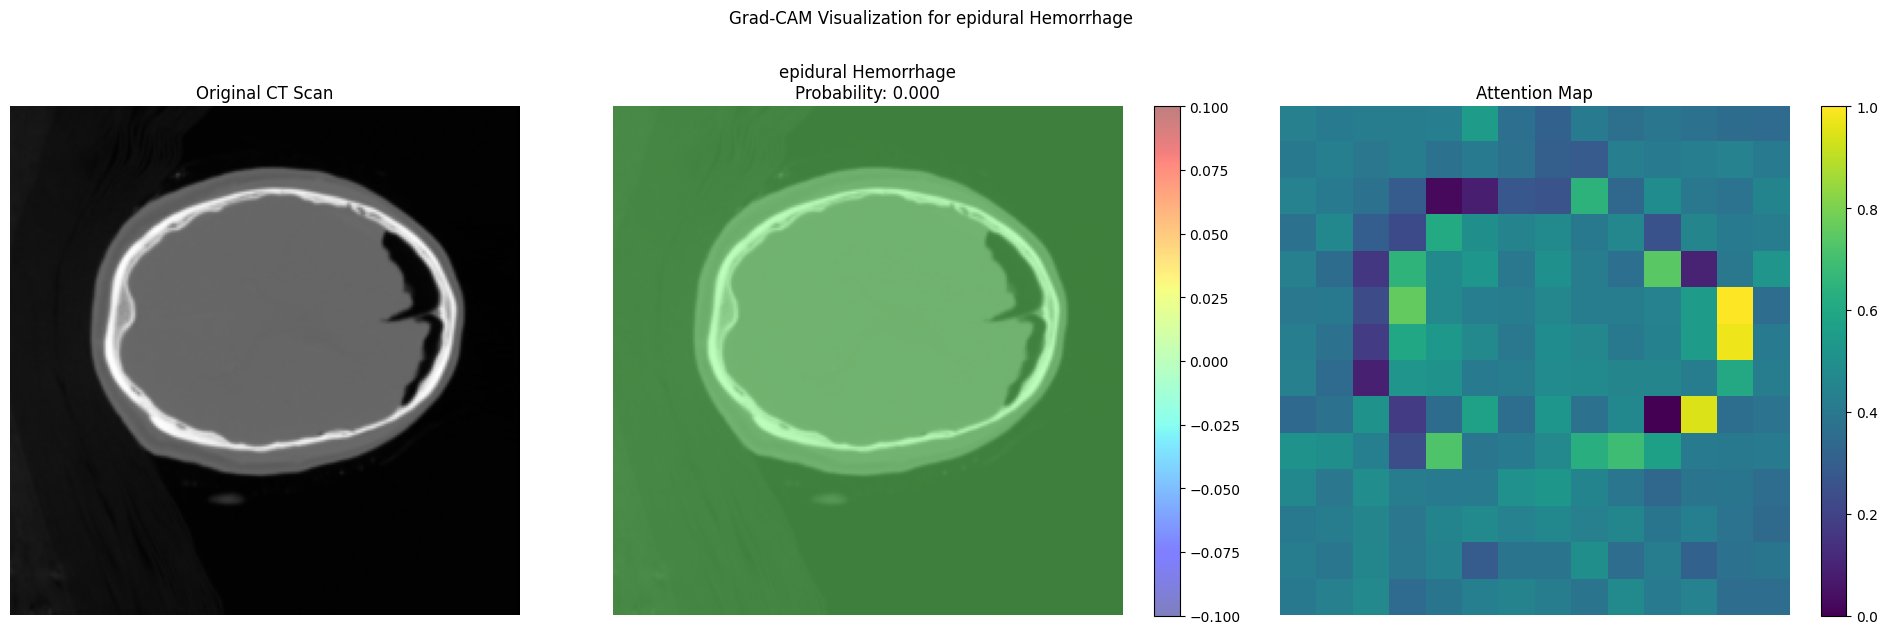

In [32]:
# Test another specific case
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_1e03295964/ID_1e03295964.nii.gz"  # Replace with new file path
results, image = analyze_hemorrhage_with_gradcam(model, test_file)
visualize_gradcam_results(image, results, display=True)

In [ ]:
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_2ad3829f51/ID_2ad3829f51.nii.gz"  # Replace with new file path
results, image = analyze_hemorrhage_with_gradcam(model, test_file)
visualize_gradcam_results(image, results, display=True)

In [ ]:
# intraparenchymal
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_2dfd378443/ID_2dfd378443.nii.gz"  # Replace with new file path
results, image = analyze_hemorrhage_with_gradcam(model, test_file)
visualize_gradcam_results(image, results, display=True)